# **SentimentArcs (Part 5): Transformer Models**

```
Jon Chun
12 Jun 2021: Started
12 Apr 2022: Last Update
```

In [ ]:
# Make sure using a GPU

# Tesla V100 = (3.0 x) P100 (2 vCPUs)
#       P100 = (1.6 x) K80  (2 vCPUs/12GB RAM)
#       P100 ~ T4 
#       K80  = (     ) NVIDA GeForce RTX 3080 Ti
#
# High RAM Colab Pro  32GB RAM     $9.99/mo
#          Colab Pro+ 52GB        $49.95/mo

# Paperspace Free & Paid JupyterLab vs Google Colab
# https://blog.paperspace.com/alternative-to-google-colab-pro/#:~:text=Most%20notable%20is%20that%20the,and%2012%20GB%20of%20RAM.&text=Meanwhile%2C%20in%20Paperspace%20Gradient%2C%20GPU,a%20Free%20or%20Paid%20instance. 
# https://www.kaggle.com/general/198232
# https://towardsdatascience.com/deep-learning-on-a-budget-450-egpu-vs-google-colab-494f9a2ff0db (3080 vs Colab)
# https://towardsdatascience.com/when-to-use-cpus-vs-gpus-vs-tpus-in-a-kaggle-competition-9af708a8c3eb (Kaggle Comp)
# https://towardsdatascience.com/google-colab-pro-is-it-worth-49-99-c542770b8e56 (Colab Pro+)
# https://www.quora.com/Which-is-better-Google-Colab-or-Kaggle-Notebook (Kaggle vs Colab GPUs)

!nvidia-smi

Mon Apr 18 17:41:49 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# **[RESTART RUNTIME] May be Required for these Libaries**

# **[STEP 1] Manual Configuration/Setup**



In [ ]:
!pip install transformers[sentencepiece]

     |████████████████████████████████| 4.0 MB 8.1 MB/s 
     |████████████████████████████████| 77 kB 8.4 MB/s 
     |████████████████████████████████| 6.6 MB 48.1 MB/s 
     |████████████████████████████████| 895 kB 58.1 MB/s 
     |████████████████████████████████| 596 kB 62.2 MB/s 
     |████████████████████████████████| 1.2 MB 55.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


## (Popups) Connect Google gDrive

In [ ]:
# [INPUT REQUIRED]: Authorize access to Google gDrive

# Connect this Notebook to your permanent Google Drive
#   so all generated output is saved to permanent storage there

try:
  from google.colab import drive
  IN_COLAB=True
except:
  IN_COLAB=False

if IN_COLAB:
  print("Attempting to attach your Google gDrive to this Colab Jupyter Notebook")
  drive.mount('/gdrive')
else:
  print("Your Google gDrive is attached to this Colab Jupyter Notebook")

Attempting to attach your Google gDrive to this Colab Jupyter Notebook
Mounted at /gdrive


## (3 Inputs) Define Directory Tree

In [ ]:
# [CUSTOMIZE]: Change the text after the Unix '%cd ' command below (change directory)
#              to math the full path to your gDrive subdirectory which should be the 
#              root directory cloned from the SentimentArcs github repo.

# NOTE: Make sure this subdirectory already exists and there are 
#       no typos, spaces or illegals characters (e.g. periods) in the full path after %cd

# NOTE: In Python all strings must begin with an upper or lowercase letter, and only
#         letter, number and underscores ('_') characters should appear afterwards.
#         Make sure your full path after %cd obeys this constraint or errors may appear.

# #@markdown **Instructions**

# #@markdown Set Directory and Corpus names:
# #@markdown <li> Set <b>Path_to_SentimentArcs</b> to the project root in your **GDrive folder**
# #@markdown <li> Set <b>Corpus_Genre</b> = [novels, finance, social_media]
# #@markdown <li> <b>Corpus_Type</b> = [reference_corpus, new_corpus]
# #@markdown <li> <b>Corpus_Number</b> = [1-20] (id nunmber if a new_corpus)

#@markdown <hr>

# Step #1: Get full path to SentimentArcs subdir on gDrive
# =======
#@markdown **Accept default path on gDrive or Enter new one:**

Path_to_SentimentArcs = "/gdrive/MyDrive/sentimentarcs_notebooks/" #@param ["/gdrive/MyDrive/sentiment_arcs/"] {allow-input: true}


#@markdown Set this to the project root in your <b>GDrive folder</b>
#@markdown <br> (e.g. /<wbr><b>gdrive/MyDrive/research/sentiment_arcs/</b>)

#@markdown <hr>

#@markdown **Which type of texts are you cleaning?** \

Corpus_Genre = "finance" #@param ["novels", "social_media", "finance"]

# Corpus_Type = "reference" #@param ["new", "reference"]
Corpus_Type = "new" #@param ["new", "reference"]


Corpus_Number = 9 #@param {type:"slider", min:1, max:10, step:1}


#@markdown Put in the corresponding Subdirectory under **./text_raw**:
#@markdown <li> All Texts as clean <b>plaintext *.txt</b> files 
#@markdown <li> A <b>YAML Configuration File</b> describing each Texts

#@markdown Please verify the required textfiles and YAML file exist in the correct subdirectories before continuing.

print('Current Working Directory:')
%cd $Path_to_SentimentArcs

print('\n')

if Corpus_Type == 'reference':
  SUBDIR_SENTIMENT_RAW = f'sentiment_raw_{Corpus_Genre}_reference'
  SUBDIR_TEXT_CLEAN = f'text_clean_{Corpus_Genre}_reference'
else:
  SUBDIR_SENTIMENT_RAW = f'sentiment_raw_{Corpus_Genre}_{Corpus_Type}_corpus{Corpus_Number}/'
  SUBDIR_TEXT_CLEAN = f'text_clean_{Corpus_Genre}_{Corpus_Type}_corpus{Corpus_Number}/'

# PATH_SENTIMENT_RAW = f'./sentiment_raw/{SUBDIR_TEXT_RAW}'
# PATH_TEXT_CLEAN = f'./text_clean/{SUBDIR_TEXT_CLEAN}'
PATH_SENTIMENT_RAW = f'./sentiment_raw/{SUBDIR_SENTIMENT_RAW}'
PATH_TEXT_CLEAN = f'./text_clean/{SUBDIR_TEXT_CLEAN}'

# TODO: Clean up
# SUBDIR_TEXT_CLEAN = PATH_TEXT_CLEAN

print(f'PATH_SENTIMENT_RAW:\n  [{PATH_SENTIMENT_RAW}]')
print(f'SUBDIR_SENTIMENT_RAW:\n  [{SUBDIR_SENTIMENT_RAW}]')

print('\n')

print(f'PATH_TEXT_CLEAN:\n  [{PATH_TEXT_CLEAN}]')
print(f'SUBDIR_TEXT_CLEAN:\n  [{SUBDIR_TEXT_CLEAN}]')

Current Working Directory:
/gdrive/MyDrive/sentimentarcs_notebooks


PATH_SENTIMENT_RAW:
  [./sentiment_raw/sentiment_raw_finance_new_corpus9/]
SUBDIR_SENTIMENT_RAW:
  [sentiment_raw_finance_new_corpus9/]


PATH_TEXT_CLEAN:
  [./text_clean/text_clean_finance_new_corpus9/]
SUBDIR_TEXT_CLEAN:
  [text_clean_finance_new_corpus9/]


# **[STEP 2] Automatic Configuration/Setup**

## (each time) Custom Libraries & Define Globals

In [ ]:
# Add PATH for ./utils subdirectory

import sys
import os

!python --version

print('\n')

PATH_UTILS = f'{Path_to_SentimentArcs}utils'
PATH_UTILS

sys.path.append(PATH_UTILS)

print('Contents of Subdirectory [./sentiment_arcs/utils/]\n')
!ls $PATH_UTILS

# More Specific than PATH for searching libraries
# !echo $PYTHONPATH

Python 3.7.13




'/gdrive/MyDrive/sentimentarcs_notebooks/utils'

Contents of Subdirectory [./sentiment_arcs/utils/]

config_matplotlib.py   get_subdirs.py	    sentiment_analysis.py
config_seaborn.py      global_constants.py  sentiment_arcs_config.py
file_utils.py	       global_vars.py	    set_globals.py
get_fullpath.py        __init__.py	    subdir_constants.py
get_model_families.py  __pycache__	    text_cleaners_new.py
get_sentimentr.R       read_yaml.py	    text_cleaners.py
get_sentiments.py      sa_config.py


In [ ]:
# Review Global Variables and set the first few

import global_vars as global_vars

global_vars.SUBDIR_SENTIMENTARCS = Path_to_SentimentArcs
global_vars.Corpus_Genre = Corpus_Genre
global_vars.Corpus_Type = Corpus_Type
global_vars.Corpus_Number = Corpus_Number

global_vars.SUBDIR_SENTIMENT_RAW = SUBDIR_SENTIMENT_RAW
global_vars.PATH_SENTIMENT_RAW = PATH_SENTIMENT_RAW

global_vars.SUBDIR_TEXT_CLEAN = SUBDIR_TEXT_CLEAN
global_vars.PATH_TEXT_CLEAN = PATH_TEXT_CLEAN

from utils import sa_config # (e.g. define TEST_WORDS_LS)

sa_config.set_globals()

global_vars.TEST_WORDS_LS
print('\n')

dir(global_vars)

['Love',
 'Hate',
 'bizarre',
 'strange',
 'furious',
 'elated',
 'curious',
 'beserk',
 'gambaro']

['Corpus_Genre',
 'Corpus_Number',
 'Corpus_Type',
 'FNAME_SENTIMENT_RAW',
 'MIN_PARAG_LEN',
 'MIN_SENT_LEN',
 'NotebookModels',
 'PATH_SENTIMENT_RAW',
 'PATH_TEXT_CLEAN',
 'PATH_TEXT_RAW_CORPUS',
 'SLANG_DT',
 'STOPWORDS_ADD_EN',
 'STOPWORDS_DEL_EN',
 'SUBDIR_CRUXES',
 'SUBDIR_DATA',
 'SUBDIR_GRAPHS',
 'SUBDIR_SENTIMENTARCS',
 'SUBDIR_SENTIMENT_CLEAN',
 'SUBDIR_SENTIMENT_RAW',
 'SUBDIR_TEXT_CLEAN',
 'SUBDIR_TEXT_RAW',
 'SUBDIR_TIMESERIES_CLEAN',
 'SUBDIR_TIMESERIES_RAW',
 'SUBDIR_UTILS',
 'TEST_SENTENCES_LS',
 'TEST_WORDS_LS',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'corpus_texts_dt',
 'corpus_titles_dt',
 'corpus_titles_ls',
 'lexicons_dt',
 'model_ensemble_dt',
 'model_titles_dt',
 'models_titles_dt']

In [ ]:
# Initialize and clean for each iteration of notebook

# dir(global_vars)

global_vars.corpus_texts_dt = {}
global_vars.corpus_titles_dt = {}

In [ ]:
# Import SentimentArcs Utilities to define Directory Structure
#   based the Selected Corpus Genre, Type and Number

!pwd 
print('\n')

# from utils import sa_config # .sentiment_arcs_utils
from utils import sa_config

print('Objects in sa_config()')
print(dir(sa_config))
print('\n')

# Directory Structure for the Selected Corpus Genre, Type and Number
sa_config.get_subdirs(Path_to_SentimentArcs, Corpus_Genre, Corpus_Type, Corpus_Number, 'none')


/gdrive/MyDrive/sentimentarcs_notebooks


Objects in sa_config()
['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'get_subdirs', 'global_vars', 'set_globals']


Verify the Directory Structure:

-------------------------------

           [Corpus Genre]: finance

            [Corpus Type]: new


    [FNAME_SENTIMENT_RAW]: [NONE]




INPUTS:
-------------------------------

   [SUBDIR_SENTIMENTARCS]: /gdrive/MyDrive/sentimentarcs_notebooks/


STEP 1: Clean Text
--------------------

        [SUBDIR_TEXT_RAW]: ./text_raw/text_raw_finance_new_corpus9/

      [SUBDIR_TEXT_CLEAN]: ./text_clean/text_clean_finance_new_corpus9/


STEP 2: Get Sentiments
--------------------

   [SUBDIR_SENTIMENT_RAW]: ./sentiment_raw/sentiment_raw_finance_new_corpus9/

 [SUBDIR_SENTIMENT_CLEAN]: ./sentiment_clean/sentiemnt_clean_finance_new_corpus9/


STEP 3: Smooth Time Series and Get Crux Points
--------------------

  [SUBDIR_TIMESERIES_RAW]: ./sentime

In [ ]:
%whos 

Variable                              Type                          Data/Info
-----------------------------------------------------------------------------
AutoModelForSequenceClassification    type                          <class 'transformers.mode<...>rSequenceClassification'>
AutoTokenizer                         type                          <class 'transformers.mode<...>tion_auto.AutoTokenizer'>
Corpus_Genre                          str                           finance
Corpus_Number                         int                           9
Corpus_Type                           str                           new
CountVectorizer                       type                          <class 'sklearn.feature_e<...>on.text.CountVectorizer'>
Force_Recompute                       bool                          False
GaussianNB                            ABCMeta                       <class 'sklearn.naive_bayes.GaussianNB'>
GridSearchCV                          ABCMeta                       <cl

## (each time) Read YAML Configuration for Corpus and Models 

In [ ]:
# from utils import sa_config # .sentiment_arcs_utils

import yaml

from utils import read_yaml

print('Objects in read_yaml()')
print(dir(read_yaml))
print('\n')

# Directory Structure for the Selected Corpus Genre, Type and Number
read_yaml.read_corpus_yaml(Corpus_Genre, Corpus_Type, Corpus_Number)

print('SentimentArcs Model Ensemble ------------------------------\n')
model_titles_ls = global_vars.models_titles_dt.keys()
print('\n'.join(model_titles_ls))


print('\n\nCorpus Texts ------------------------------\n')
corpus_titles_ls = list(global_vars.corpus_titles_dt.keys())
print('\n'.join(corpus_titles_ls))


print(f'\n\nThere are {len(model_titles_ls)} Models in the SentimentArcs Ensemble above.\n')
print(f'\nThere are {len(corpus_titles_ls)} Texts in the Corpus above.\n')
print('\n')

global_vars.corpus_titles_dt

Objects in read_yaml()
['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'global_vars', 'read_corpus_yaml', 'yaml']


YAML Directory: text_raw/text_raw_finance_new_corpus9
YAML File: text_raw_finance_new_corpus9_info.yaml
SentimentArcs Model Ensemble ------------------------------

AutoGluon_Text
BERT_2IMDB
BERT_Dual_Coding
BERT_Multilingual
BERT_Yelp
CNN_DNN
Distilled_BERT
FLAML_AutoML
Fully_Connected_Network
HyperOpt_CNN_Flair_AutoML
LSTM_DNN
Logistic_Regression
Logistic_Regression_CV
Multilingual_CNN_Stanza_AutoML
Multinomial_Naive_Bayes
Pattern
Random_Forest
RoBERTa_Large_15DB
RoBERTa_XML_8Language
FinBERT
FinBERT_Tone
DistilRoBERTa_FinNews
SentimentR_JockersRinker
SentimentR_Jockers
SentimentR_Bing
SentimentR_NRC
SentimentR_SentiWord
SentimentR_SenticNet
SentimentR_LMcD
SentimentR_SentimentR
PySentimentR_JockersRinker
PySentimentR_Huliu
PySentimentR_NRC
PySentimentR_SentiWord
PySentimentR_SenticNet
PySentimentR_LMcD
SyuzhetR

{'nyfederalreserve_speeches_2007': ['New York Federal Reserve Bank Speeches (Jan 2007 - Dec 2007)',
  datetime.date(2007, 1, 12),
  datetime.date(2007, 12, 17)]}

In [ ]:
global_vars.models_titles_dt.items()

dict_items([('AutoGluon_Text', ['autogluon', 'tradml', 'autogluon_text']), ('BERT_2IMDB', ['imdb2way', 'transformer', 'bert']), ('BERT_Dual_Coding', ['hinglish', 'transformer', 'bert']), ('BERT_Multilingual', ['nlptown', 'transformer', 'bert']), ('BERT_Yelp', ['yelp', 'transformer', 'bert']), ('CNN_DNN', ['cnn', 'dnn', 1315937]), ('Distilled_BERT', ['huggingface', 'transformer', 'bert']), ('FLAML_AutoML', ['flaml', 'tradml', 'flaml']), ('Fully_Connected_Network', ['fcn', 'dnn', 6287671]), ('HyperOpt_CNN_Flair_AutoML', ['flair', 'dnn', 0]), ('LSTM_DNN', ['lstm', 'dnn', 7109089]), ('Logistic_Regression', ['logreg', 'tradml', 'scikit']), ('Logistic_Regression_CV', ['logreg_cv', 'tradml', 'scikit']), ('Multilingual_CNN_Stanza_AutoML', ['stanza', 'dnn', 0]), ('Multinomial_Naive_Bayes', ['multinb', 'tradml', 'scikit']), ('Pattern', ['pattern', 'heuristic', 2918]), ('Random_Forest', ['rf', 'tradml', 'scikit']), ('RoBERTa_Large_15DB', ['roberta15lg', 'transformer', 'roberta']), ('RoBERTa_XML_8

In [ ]:
global_vars.corpus_titles_dt

{'nyfederalreserve_speeches_2007': ['New York Federal Reserve Bank Speeches (Jan 2007 - Dec 2007)',
  datetime.date(2007, 1, 12),
  datetime.date(2007, 12, 17)]}

## Configure Jupyter Notebook

In [ ]:
# Configure Jupyter

# To reload modules under development

# Option (a)
%load_ext autoreload
%autoreload 2
# Option (b)
# import importlib
# importlib.reload(functions.readfunctions)


# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Enable multiple outputs from one code cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from IPython.display import display
from IPython.display import Image
from ipywidgets import widgets, interactive

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Install Python Libraries

In [ ]:
# Intentionally left blank

## Load Libraries

In [ ]:
import numpy as np

from tqdm._tqdm_notebook import tqdm_notebook
import pandas as pd
tqdm_notebook.pandas()

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
pd.set_option('max_colwidth', 100) # -1)

from glob import glob
import copy
import json

2022-04-18 17:43:55,950 : INFO : NumExpr defaulting to 2 threads.


In [ ]:
# Scikit Utilities, Metrics, Pipelines and Models

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer

from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB


In [ ]:
"""

# Define Globals

# Main data structure: Dictionary (key=text_name) of DataFrames (cols: text_raw, text_clean)
corpus_texts_dt = {}

# Verify in SentimentArcs Root Directory
os.chdir('/gdrive/MyDrive/cdh/sentiment_arcs/')

%run -i './utils/get_globals.py'

SLANG_DT.keys()
""";

## Setup Matplotlib Style

* https://matplotlib.org/stable/tutorials/introductory/customizing.html

In [ ]:
# Configure Matplotlib

# View available styles
# plt.style.available

# Verify in SentimentArcs Root Directory
os.chdir(Path_to_SentimentArcs)

%run -i './utils/config_matplotlib.py'

config_matplotlib()

print('Matplotlib Configuration ------------------------------')
print('\n  (Uncomment to view)')
# plt.rcParams.keys()
print('\n  Edit ./utils/config_matplotlib.py to change')




 New figure size:  (20, 10)
Matplotlib Configuration ------------------------------

  (Uncomment to view)

  Edit ./utils/config_matplotlib.py to change


<Figure size 1440x720 with 0 Axes>

## Setup Seaborn Style

In [ ]:
# Configure Seaborn

# Verify in SentimentArcs Root Directory
os.chdir(Path_to_SentimentArcs)

%run -i './utils/config_seaborn.py'

config_seaborn()

print('Seaborn Configuration ------------------------------\n')
# print('\n  Update ./utils/config_seaborn.py to display seaborn settings')





Seaborn Configuration ------------------------------



## Python Utility Functions

### (each time) Generate Convenient Data Lists

In [ ]:
# Derive List of Texts in Corpus a)keys and b)full author and titles

print('Dictionary: corpus_titles_dt')
global_vars.corpus_titles_dt
print('\n')

corpus_texts_ls = list(global_vars.corpus_titles_dt.keys())
print(f'\nCorpus Texts:')
for akey in corpus_texts_ls:
  print(f'  {akey}')
print('\n')

print(f'\nNatural Corpus Titles:')
corpus_titles_ls = [x[0] for x in list(global_vars.corpus_titles_dt.values())]
for akey in corpus_titles_ls:
  print(f'  {akey}')


Dictionary: corpus_titles_dt


{'nyfederalreserve_speeches_2007': ['New York Federal Reserve Bank Speeches (Jan 2007 - Dec 2007)',
  datetime.date(2007, 1, 12),
  datetime.date(2007, 12, 17)]}




Corpus Texts:
  nyfederalreserve_speeches_2007



Natural Corpus Titles:
  New York Federal Reserve Bank Speeches (Jan 2007 - Dec 2007)


In [ ]:
# Get Model Families of Ensemble

from utils.get_model_families import get_ensemble_model_famalies

global_vars.model_ensemble_dt = get_ensemble_model_famalies(global_vars.models_titles_dt)

print('\nTest: Lexicon Family of Models:')
global_vars.model_ensemble_dt['lexicon']


There are 12 Lexicon Models
  Lexicon Model #0: sentimentr_sentimentr
  Lexicon Model #1: pysentimentr_jockersrinker
  Lexicon Model #2: pysentimentr_huliu
  Lexicon Model #3: pysentimentr_nrc
  Lexicon Model #4: pysentimentr_sentiword
  Lexicon Model #5: pysentimentr_senticnet
  Lexicon Model #6: pysentimentr_lmcd
  Lexicon Model #7: syuzhetr_afinn
  Lexicon Model #8: syuzhetr_bing
  Lexicon Model #9: syuzhetr_nrc
  Lexicon Model #10: syuzhetr_syuzhetr
  Lexicon Model #11: afinn

There are 9 Heuristic Models
  Heuristic Model #0: pattern
  Heuristic Model #1: sentimentr_jockersrinker
  Heuristic Model #2: sentimentr_jockers
  Heuristic Model #3: sentimentr_bing
  Heuristic Model #4: sentimentr_nrc
  Heuristic Model #5: sentimentr_sentiword
  Heuristic Model #6: sentimentr_senticnet
  Heuristic Model #7: sentimentr_lmcd
  Heuristic Model #8: vader

There are 8 Traditional ML Models
  Traditional ML Model #0: autogluon
  Traditional ML Model #1: flaml
  Traditional ML Model #2: logreg


['sentimentr_sentimentr',
 'pysentimentr_jockersrinker',
 'pysentimentr_huliu',
 'pysentimentr_nrc',
 'pysentimentr_sentiword',
 'pysentimentr_senticnet',
 'pysentimentr_lmcd',
 'syuzhetr_afinn',
 'syuzhetr_bing',
 'syuzhetr_nrc',
 'syuzhetr_syuzhetr',
 'afinn']

### File Functions

In [ ]:
# Verify in SentimentArcs Root Directory
os.chdir(Path_to_SentimentArcs)

%run -i './utils/file_utils.py'
# from utils.file_utils import *

# %run -i './utils/file_utils.py'

# TODO: Not used? Delete?
# get_fullpath(text_title_str, ftype='data_clean', fig_no='', first_note = '',last_note='', plot_ext='png', no_date=False)

# **[STEP 3] Read all Preprocessed Novels**

## Read Cleaned Text

In [ ]:
# Verify cwd and subdir of Cleaned Corpus Texts

print('Current Working Directory:')
!pwd

print(f'\nSubdir with all Cleaned Texts of Corpus:\n  {SUBDIR_TEXT_CLEAN}')

print(f'\n\nFilenames of Cleaned Texts:\n')
!ls -1 {Path_to_SentimentArcs}{PATH_TEXT_CLEAN}

print('\n')

print(corpus_texts_ls)

Current Working Directory:
/gdrive/MyDrive/sentimentarcs_notebooks

Subdir with all Cleaned Texts of Corpus:
  text_clean_finance_new_corpus9/


Filenames of Cleaned Texts:

nyfederalreserve_speeches_2007.csv


['nyfederalreserve_speeches_2007']


In [ ]:
"""

# Create a List (preprocessed_ls) of all preprocessed text files

# Verify in SentimentArcs Root Directory
os.chdir(Path_to_SentimentArcs)

try:
    preprocessed_ls = glob(f'{PATH_TEXT_CLEAN}/*.csv')
    preprocessed_ls = [x.split('/')[-1] for x in preprocessed_ls]
    preprocessed_ls = [x.split('.')[0] for x in preprocessed_ls]
except IndexError:
    raise RuntimeError('No csv file found')

print('\n'.join(preprocessed_ls))
print('\n')
print(f'Found {len(preprocessed_ls)} Preprocessed files in {SUBDIR_TEXT_CLEAN}')

"""

"\n\n# Create a List (preprocessed_ls) of all preprocessed text files\n\n# Verify in SentimentArcs Root Directory\nos.chdir(Path_to_SentimentArcs)\n\ntry:\n    preprocessed_ls = glob(f'{PATH_TEXT_CLEAN}/*.csv')\n    preprocessed_ls = [x.split('/')[-1] for x in preprocessed_ls]\n    preprocessed_ls = [x.split('.')[0] for x in preprocessed_ls]\nexcept IndexError:\n    raise RuntimeError('No csv file found')\n\nprint('\n'.join(preprocessed_ls))\nprint('\n')\nprint(f'Found {len(preprocessed_ls)} Preprocessed files in {SUBDIR_TEXT_CLEAN}')\n\n"

In [ ]:
# Read all preprocessed text files into master DataFrame (corpus_dt)

global_vars.corpus_texts_dt = {}

for i,atext in enumerate(corpus_texts_ls):
  print(f'Processing #{i}: {atext}...')
  afile_fullpath = f'{PATH_TEXT_CLEAN}/{atext}.csv'
  print(f'               {afile_fullpath}')
  atext_df = pd.read_csv(afile_fullpath, index_col=[0])
  global_vars.corpus_texts_dt[atext] = atext_df

Processing #0: nyfederalreserve_speeches_2007...
               ./text_clean/text_clean_finance_new_corpus9//nyfederalreserve_speeches_2007.csv


In [ ]:
# Verify the Text read into master Dictionary of DataFrames

global_vars.corpus_texts_dt.keys()
print('\n')
print(f'There were {len(global_vars.corpus_texts_dt)} preprocessed Text read into the Dict global_vars.corpus_texts_dt')

dict_keys(['nyfederalreserve_speeches_2007'])



There were 1 preprocessed Text read into the Dict global_vars.corpus_texts_dt


In [ ]:
# Check if there are any Null strings in the text_clean columns

for i, atext in enumerate(list(global_vars.corpus_texts_dt.keys())):
  print(f'\nNovel #{i}: {atext}')
  nan_ct = global_vars.corpus_texts_dt[atext].text_clean.isna().sum()
  if nan_ct > 0:
    print(f'      {nan_ct} Null strings in the text_clean column')


Novel #0: nyfederalreserve_speeches_2007


In [ ]:
# Fill in all the Null value of text_clean with placeholder 'empty_string'

for i, atext in enumerate(list(global_vars.corpus_texts_dt.keys())):
  # print(f'Novel #{i}: {atext}')
  # Fill all text_clean == Null with 'empty_string' so sentimentr::sentiment doesn't break
  global_vars.corpus_texts_dt[atext].iloc[global_vars.corpus_texts_dt[atext].text_clean.isna()] = 'empty_string'

In [ ]:
# Verify DataFrame of first Text in Corpus Dictionary

global_vars.corpus_texts_dt[next(iter(global_vars.corpus_texts_dt))].head()

,text_raw,text_clean
0,Timothy F Geithner: Developments in the global economy and implications for the United States Re...,timothy f geithner development in the global economy and implication for the unite state remark ...
1,"It is a pleasure to be here at the Council on Foreign Relations, and to be here with Jerry Corri...",it be a pleasure to be here at the council on foreign relation and to be here with jerry corrigan
2,"A few brief remarks about the global economy, both the real and financial dimensions, to provide...",a few brief remark about the global economy both the real and financial dimension to provide a b...
3,2006 marked the fourth successive year of a global expansion that has been remarkable for its st...,mark the 4 successive year of a global expansion that have be remarkable for its strength for it...
4,This period of broad-based growth in income has been supported by a number of important fundamen...,this period of broad base growth in income have be support by a numb of important fundamental force


In [ ]:
# [SKIP]

In [ ]:
"""

print(f'Trying to find EXISTING Raw Sentiment Datafile:\n  [{FNAME_SENTIMENT_RAW}]\n  in Raw Sentiment Subdir: {SUBDIR_SENTIMENT_RAW}\n')

corpus_texts_dt = {}
subdir_sentiment_raw_ls = os.listdir(SUBDIR_SENTIMENT_RAW)

# Verify in SentimentArcs Root Directory and cd into ./utils for R programs
os.chdir('/gdrive/MyDrive/cdh/sentiment_arcs/')
!pwd

if FNAME_SENTIMENT_RAW not in subdir_sentiment_raw_ls:
  # No Existing Raw Sentiment Data, Just read in Clean Text
  print(f'No EXISTING Raw Sentiment Datafile exists, Start from Stratch...\n')

  # Create a List (texts_clean_ls) of all preprocessed text files
  try:
    texts_clean_ls = glob(f'{SUBDIR_TEXT_CLEAN}*.csv')
    texts_clean_ls = [x.split('/')[-1] for x in texts_clean_ls]
    texts_clean_ls = [x.split('.')[0] for x in texts_clean_ls]
  except IndexError:
    raise RuntimeError('No csv file found')

  # Read all preprocessed text files into master DataFrame (corpus_dt)
  for i,anovel in enumerate(texts_clean_ls):
    print(f'Processing #{i}: {anovel}...')
    afile_fullpath = f'{SUBDIR_TEXT_CLEAN}{anovel}.csv'
    print(f'               {afile_fullpath}')
    anovel_df = pd.read_csv(afile_fullpath, index_col=[0])
    corpus_texts_dt[anovel] = anovel_df

  print('\n'.join(texts_clean_ls))
  print('\n')
  print(f'Found {len(texts_clean_ls)} Preprocessed files in {SUBDIR_TEXT_CLEAN}')
else:
  # Found Existing Raw Sentiment Data with Clean Text, Read Both
  print(f'Found EXISTING  Raw Sentiment Datafile exists, Loading...\n')
  corpus_texts_dt = read_dict_dfs(in_file=FNAME_SENTIMENT_RAW, in_dir=SUBDIR_SENTIMENT_RAW)
  print(f'The  Models have Analyzed these Texts in the Corpus:\n\n  {corpus_texts_dt.keys()}\n\n')    

# Verify Corpus DataFrame
corpus_titles_ls = list(corpus_texts_dt.keys())
# corpus_texts_dt[corpus_titles_ls[0]].head()
corpus_texts_dt[corpus_titles_ls[0]].info()

""";

In [ ]:
models_ls = list(set(global_vars.corpus_texts_dt[corpus_texts_ls[0]].columns) - set(['text_clean','text_raw']))
print(f'There are [{len(models_ls)} Models] Pre-Existing in the Datafile for this Notebook:\n')
models_ls
print('\n')

print(f'There are [{len(corpus_texts_ls)} Texts] in the current Corpus:\n')
corpus_titles_ls

There are [0 Models] Pre-Existing in the Datafile for this Notebook:



[]



There are [1 Texts] in the current Corpus:



['New York Federal Reserve Bank Speeches (Jan 2007 - Dec 2007)']

## (del?) If Sentiment Time Series exist, Verify with Plots

In [ ]:
from sklearn.preprocessing import StandardScaler, RobustScaler

r_scaler = RobustScaler() 
z_scaler = StandardScaler()

In [ ]:
global_vars.corpus_texts_dt[corpus_texts_ls[0]].head()

In [ ]:
global_vars.corpus_texts_dt[corpus_texts_ls[0]].head()

In [ ]:
df.shape

## (del?) zScale Prior Sentiment Time Series

In [ ]:
# Plot Sentiment Time Series for all Models in this Notebook run so far

df = pd.DataFrame()

for i, atext in enumerate(corpus_texts_ls):
  col_rzscores_ls = []
  print(f"Title #{i}: {atext}")
  df = global_vars.corpus_texts_dt[atext].copy()
  numeric_cols_ls = df.select_dtypes(include=[np.number]).columns
  for anum_col_str in numeric_cols_ls:
    print(f'Processing anum_col: {anum_col_str}')
    anum_col_robust_np = r_scaler.fit_transform(df[anum_col_str].values.reshape(-1, 1) )
    anum_col_rzscore_np = z_scaler.fit_transform(anum_col_robust_np)
    anum_col_rzscore_str = f'{anum_col_str}_rzscore'
    df[anum_col_rzscore_str] = pd.Series(anum_col_rzscore_np.squeeze(-1,))
    col_rzscores_ls.append(anum_col_rzscore_str)

  print(f'df.columns: {df.columns}')
  win_10per = int(0.10 * df.shape[0])
  # df[col_rzscores_ls].rolling(win_10per, center=True, min_periods=0).mean() # .plot(title=f"Sentiment Analysis\n{global_vars.corpus_texts_dt[atext][0]}\nProcessing: SMA 10% (+ Robust IQR, zScore Scaling)")


# **[STEP 4] Transformer Models**

## Common Transformer Setup

In [ ]:
from transformers import pipeline

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import BertTokenizer, BertForSequenceClassification

from transformers import AutoTokenizer, AutoModelWithLMHead  # T5Base 50k

In [ ]:
# Define all Corpus Texts & Ensemble Models as global CONSTANTS

model_family = 'transformer'

# Verify in SentimentArcs Root Directory
os.chdir(Path_to_SentimentArcs)
%run -i './utils/get_sentiments.py'

#@markdown If Model Values already exist, Recompute anyway and Overwrite?

Force_Recompute = False #@param {type:"boolean"}

# Get list Names for This Section of Python Lexicon Models

# models_lexicon_ls = ensemble_models_dt['lexicon']
models_pylex_ls = [x for x in global_vars.model_ensemble_dt[model_family]]
print(f'Lexicon Models in this Section:\n')
print(models_pylex_ls)

Lexicon Models in this Section:

['imdb2way', 'hinglish', 'nlptown', 'yelp', 'huggingface', 'roberta15lg', 'robertaxml8lang', 'finbert', 'finberttone', 'distilrobertafinnews', 't5imdb50k']


In [ ]:
global_vars.corpus_texts_dt.keys()

dict_keys(['nyfederalreserve_speeches_2007'])

In [ ]:
"""

# from utils import sa_config (e.g. define TEST_WORDS_LS)

from utils import sa_config

sa_config.set_globals()
""";

global_vars.TEST_WORDS_LS



'\n\n# from utils import sa_config (e.g. define TEST_WORDS_LS)\n\nfrom utils import sa_config\n\nsa_config.set_globals()\n'

['Love',
 'Hate',
 'bizarre',
 'strange',
 'furious',
 'elated',
 'curious',
 'beserk',
 'gambaro']

In [ ]:
global_vars.models_titles_dt

{'AFINN': ['afinn', 'lexicon', 7520],
 'AutoGluon_Text': ['autogluon', 'tradml', 'autogluon_text'],
 'BERT_2IMDB': ['imdb2way', 'transformer', 'bert'],
 'BERT_Dual_Coding': ['hinglish', 'transformer', 'bert'],
 'BERT_Multilingual': ['nlptown', 'transformer', 'bert'],
 'BERT_Yelp': ['yelp', 'transformer', 'bert'],
 'CNN_DNN': ['cnn', 'dnn', 1315937],
 'DistilRoBERTa_FinNews': ['distilrobertafinnews', 'transformer', 'roberta'],
 'Distilled_BERT': ['huggingface', 'transformer', 'bert'],
 'FLAML_AutoML': ['flaml', 'tradml', 'flaml'],
 'FinBERT': ['finbert', 'transformer', 'bert'],
 'FinBERT_Tone': ['finberttone', 'transformer', 'bert'],
 'Fully_Connected_Network': ['fcn', 'dnn', 6287671],
 'HyperOpt_CNN_Flair_AutoML': ['flair', 'dnn', 0],
 'LSTM_DNN': ['lstm', 'dnn', 7109089],
 'Logistic_Regression': ['logreg', 'tradml', 'scikit'],
 'Logistic_Regression_CV': ['logreg_cv', 'tradml', 'scikit'],
 'Multilingual_CNN_Stanza_AutoML': ['stanza', 'dnn', 0],
 'Multinomial_Naive_Bayes': ['multinb', '

In [ ]:
global_vars.model_ensemble_dt.keys()

dict_keys(['lexicon', 'heuristic', 'ml', 'dnn', 'transformer'])

## **RoBERTa Large 15 Datasets (5 cats)**

In [ ]:
%%time

# NOTE: 00m11s @12:39 on 20220301 Colab Pro 

sa_model = None
del sa_model
sa_model = pipeline("sentiment-analysis",model="siebert/sentiment-roberta-large-english")

print(sa_model("I love this!"))

Downloading:   0%|          | 0.00/687 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.32G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/256 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/780k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

[{'label': 'POSITIVE', 'score': 0.9988656044006348}]
CPU times: user 25.6 s, sys: 5 s, total: 30.7 s
Wall time: 36.8 s


In [ ]:
# Define Model and Test

model_title = 'RoBERTa Large 15DB'
model_name = 'roberta15lg'
model_type = 'Transformer'

# Test Words
print(f'Testing WORD Sentiment')
print('--------------------------------------------------')
for i, aword_str in enumerate(global_vars.TEST_WORDS_LS):

  word_sentiment_fl = sa_model(aword_str)
  print(f'Word: {aword_str}\n    {word_sentiment_fl}\n')

# Test Sentences
print(f'\nTesting SENTENCE Sentiment')
print('--------------------------------------------------')
for i, asent_str in enumerate(global_vars.TEST_SENTENCES_LS):

  sent_sentiment_fl = sa_model(asent_str)
  print(f'Sentence: {asent_str}\n    {sent_sentiment_fl}\n')

Testing WORD Sentiment
--------------------------------------------------
Word: Love
    [{'label': 'POSITIVE', 'score': 0.9969683289527893}]

Word: Hate
    [{'label': 'NEGATIVE', 'score': 0.9959344863891602}]

Word: bizarre
    [{'label': 'POSITIVE', 'score': 0.9868559241294861}]

Word: strange
    [{'label': 'NEGATIVE', 'score': 0.9920816421508789}]

Word: furious
    [{'label': 'NEGATIVE', 'score': 0.9632396101951599}]

Word: elated
    [{'label': 'POSITIVE', 'score': 0.9961071610450745}]

Word: curious
    [{'label': 'POSITIVE', 'score': 0.9934197068214417}]

Word: beserk
    [{'label': 'NEGATIVE', 'score': 0.9948800802230835}]

Word: gambaro
    [{'label': 'POSITIVE', 'score': 0.9791625738143921}]


Testing SENTENCE Sentiment
--------------------------------------------------
Sentence: I hate bad evil worthless Mondays.
    [{'label': 'NEGATIVE', 'score': 0.9989356398582458}]

Sentence: I love Paris in the springtime
    [{'label': 'POSITIVE', 'score': 0.9988493919372559}]

Sente

In [ ]:
# Verify saving results to correct model name

print(f'Saving results to Model: {model_name}')

Saving results to Model: roberta15lg


In [ ]:
%%time

# NOTE:   ~40m00s @12:39 on 20220301 Colab Pro P100 (1 Novels)
#       ~1h31m00s @12:39 on 20220301 Colab Pro P100 (2 Novels)

#        3h08m00s @03:12 on 20220412 Colab Pro P100 (3 Novels/Corpus2)
#         ~00m00s @19:31 on 20220411 Colab Pro T4 (2 Novels/Corpus1)


for i, atext in enumerate(global_vars.corpus_texts_dt.keys()):
  models_ls = global_vars.corpus_texts_dt[atext].columns
  print(f"Processing #{i}: {atext}")
  if (Force_Recompute == True) or (model_name not in models_ls):
    # global_vars.corpus_texts_dt[atext][model_name] = global_vars.corpus_texts_dt[atext]['text_clean'].apply(lambda x: labelscore2fl(classifier(x), sa_model=classifier))
    global_vars.corpus_texts_dt[atext][model_name] = global_vars.corpus_texts_dt[atext]['text_clean'].apply(lambda x: labelscore2fl(sa_model(x), sa_model=model_name))
    print(f'  [{model_name}] Sentiment Recomputed and Value Updated')
  else:
    print(f'  [{model_name}] Already in DataFrame and no Forced Recompute, so no update made')

Processing #0: nyfederalreserve_speeches_2007
  [roberta15lg] Sentiment Recomputed and Value Updated
CPU times: user 6min 19s, sys: 990 ms, total: 6min 20s
Wall time: 6min 19s


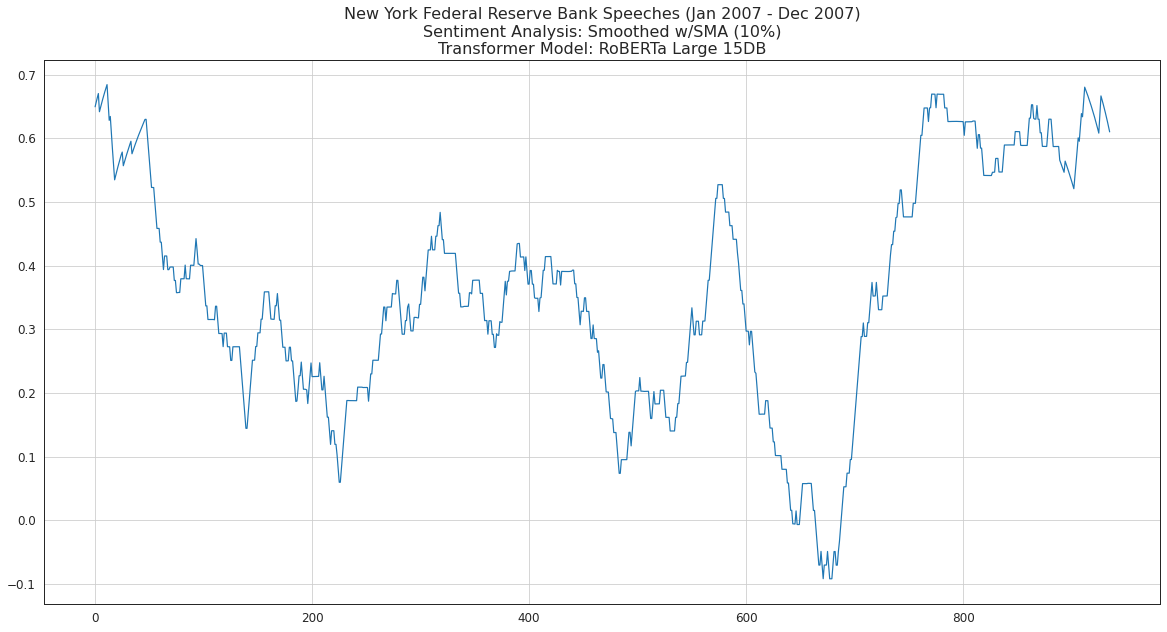

In [ ]:
# Verify Plausiblity of new Sentiment Values by Plotting

novel_indx = 0
corpus_text_str = corpus_texts_ls[novel_indx]
# amodel_str = 'huggingface' 
win_aper = 10

win_per = int((win_aper/100.)*global_vars.corpus_texts_dt[corpus_text_str][model_name].shape[0])
text_title_str = f"{global_vars.corpus_titles_dt[corpus_text_str][0]}\nSentiment Analysis: Smoothed w/SMA ({win_aper}%)\n{model_type} Model: {model_title}"
global_vars.corpus_texts_dt[corpus_text_str][model_name].rolling(win_per, center=True, min_periods=0).mean().plot(title=text_title_str)
plt.grid(True)
plt.show();

In [ ]:
global_vars.corpus_texts_dt[corpus_text_str].head()

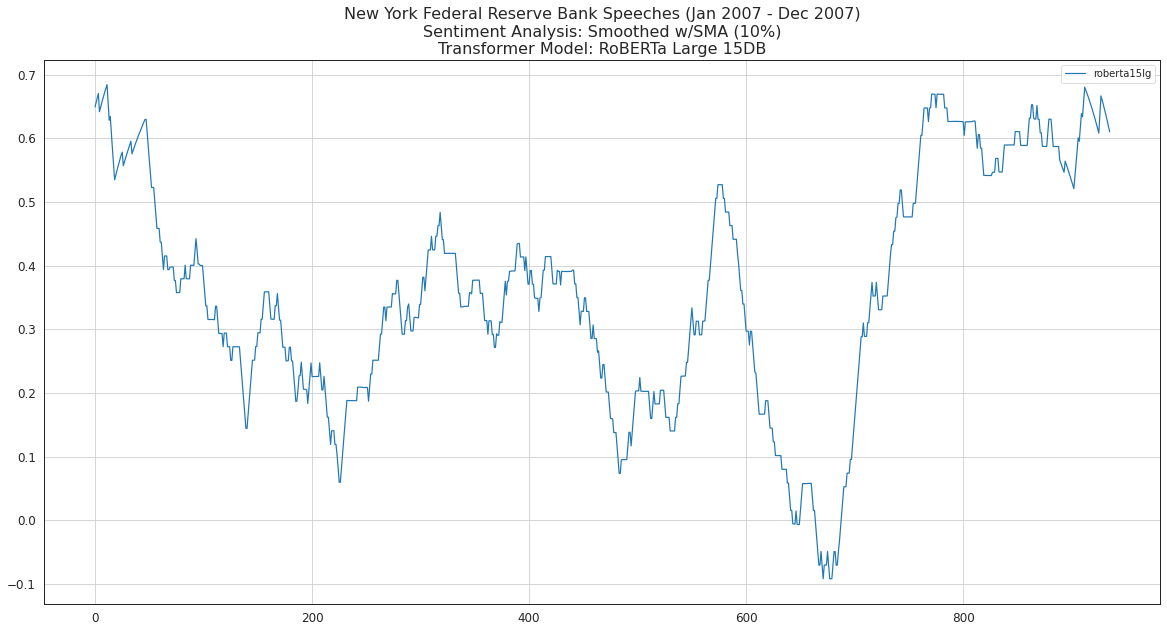

In [ ]:
# Plot all models

novel_indx = 0
corpus_text_str = corpus_texts_ls[novel_indx]
win_aper = 10

models_all_ls = list(global_vars.corpus_texts_dt[corpus_text_str].select_dtypes(include=[np.float]).columns)

win_per = int((win_aper/100.)*global_vars.corpus_texts_dt[corpus_text_str][model_name].shape[0])
text_title_str = f"{global_vars.corpus_titles_dt[corpus_text_str][0]}\nSentiment Analysis: Smoothed w/SMA ({win_aper}%)\n{model_type} Model: {model_title}"
global_vars.corpus_texts_dt[corpus_text_str][models_all_ls].rolling(win_per, center=True, min_periods=0).mean().plot(title=text_title_str)
plt.grid(True)
plt.show();

### **Save Checkpoint**

In [ ]:
# Verify in SentimentArcs Root Directory

model_current = 'roberta15lg'

os.chdir(Path_to_SentimentArcs)

print('Currently in SentimentArcs root directory:')
!pwd

print(f'Saving Text_Type: {Corpus_Genre}')
print(f'     Corpus_Type: {Corpus_Type}')

# Verify Subdir to save Cleaned Texts and Texts into..

print(f'\nThese Text Titles:\n')
global_vars.corpus_texts_dt.keys()

print(f'\nTo This Subdirectory:\n')
PATH_SENTIMENT_RAW


# Save sentiment values to subdir_sentiments

# os.chdir(Path_to_SentimentArcs)

if Corpus_Type == 'new':
  save_filename = f'sentiment_raw_{Corpus_Genre}_{Corpus_Type}_corpus{Corpus_Number}_transformer_{model_current}.json'
else:
  save_filename = f'sentiment_raw_{Corpus_Genre}_{Corpus_Type}_transformer_{model_current}.json'

# Filter out all models but Current One 
current_model_dt = {}
cols_current_model_ls = []

for i, atext in enumerate(corpus_texts_ls):
  print(f'Saving {model_current} Model for all Texts')
  current_model_dt[atext] = pd.DataFrame(global_vars.corpus_texts_dt[atext][model_current])

write_dict_dfs(current_model_dt, out_file=save_filename, out_dir=f'{PATH_SENTIMENT_RAW}/')



Currently in SentimentArcs root directory:
/gdrive/MyDrive/sentimentarcs_notebooks
Saving Text_Type: finance
     Corpus_Type: new

These Text Titles:



dict_keys(['nyfederalreserve_speeches_2007'])


To This Subdirectory:



'./sentiment_raw/sentiment_raw_finance_new_corpus9/'

Saving file to: ./sentiment_raw/sentiment_raw_finance_new_corpus9//sentiment_raw_finance_new_corpus9_transformer_huggingface.json


In [ ]:
# Verify json file created

!ls -altr $PATH_SENTIMENT_RAW

total 1632
-rw------- 1 root root 472859 Apr 18 18:54 sentiment_raw_finance_new_corpus9_all_4syuzhetr.json
-rw------- 1 root root 747037 Apr 18 18:56 sentiment_raw_finance_new_corpus9_all_8sentimentr.json
-rw------- 1 root root 386964 Apr 18 19:06 sentiment_raw_finance_new_corpus9_transformer_roberta15lg.json
-rw------- 1 root root  63091 Apr 18 19:09 sentiment_raw_finance_new_corpus9_transformer_huggingface.json


## **Huggingface Distill BERT SST**

In [ ]:
# BUG: Cannot reuse variable name 'sa_model', causes replicated results of first model declared (e.g. roberta15lg)
# sa_model = pipeline("sentiment-analysis")

sa_model = None
del sa_model
sa_model = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


In [ ]:
# Define Model and Test

model_title = 'Huggingface DistilBERT'
model_name = 'huggingface'
model_type = 'Transformer'

# Test Emoji
sa_model("We are very happy to show you the 🤗 Transformers library.")
print('\n\n')

# Test Words
print(f'Testing WORD Sentiment')
print('--------------------------------------------------')
for i, aword_str in enumerate(global_vars.TEST_WORDS_LS):

  word_sentiment_fl = sa_model(aword_str)
  print(f'Word: {aword_str}\n    {word_sentiment_fl}\n')

# Test Sentences
print(f'\nTesting SENTENCE Sentiment')
print('--------------------------------------------------')
for i, asent_str in enumerate(global_vars.TEST_SENTENCES_LS):

  sent_sentiment_fl = sa_model(asent_str)
  print(f'Sentence: {asent_str}\n    {sent_sentiment_fl}\n')

[{'label': 'POSITIVE', 'score': 0.9997795224189758}]




Testing WORD Sentiment
--------------------------------------------------
Word: Love
    [{'label': 'POSITIVE', 'score': 0.9998735189437866}]

Word: Hate
    [{'label': 'NEGATIVE', 'score': 0.9996899366378784}]

Word: bizarre
    [{'label': 'NEGATIVE', 'score': 0.9943822622299194}]

Word: strange
    [{'label': 'NEGATIVE', 'score': 0.9787243008613586}]

Word: furious
    [{'label': 'NEGATIVE', 'score': 0.999466598033905}]

Word: elated
    [{'label': 'POSITIVE', 'score': 0.9998383522033691}]

Word: curious
    [{'label': 'POSITIVE', 'score': 0.9969179630279541}]

Word: beserk
    [{'label': 'POSITIVE', 'score': 0.5606897473335266}]

Word: gambaro
    [{'label': 'POSITIVE', 'score': 0.9166504144668579}]


Testing SENTENCE Sentiment
--------------------------------------------------
Sentence: I hate bad evil worthless Mondays.
    [{'label': 'NEGATIVE', 'score': 0.9908758401870728}]

Sentence: I love Paris in the springtime
    [{'label': 'POSITIVE', 'score': 0.9998341798782349}]

Sen

In [ ]:
%%time

# NOTE: 

# NOTE:   10m25s @02:48 on 20220304 Colab Pro T4 (2 Novels ~1k sents each)
#         24m26s @08:58 on 20220412 Colab Pro P100 (3 Novels: 1.2M, 1.3M, 1.7M)
#         24m17s @11:20 on 20220412 Colab Pro P100 (3 Novels: 1.2M, 1.3M, 1.7M)
#          8m49s @13:52 on 20220412 Colab Pro T4 (2 Novels: 1M, 1.1M)

#        3m05s 22:10 on 20220415 Colab Pro K80 (3 Novels, 628k, 662k, 897k)

#       ~15m05s 13:45 on 20220418 Colab Pro P100 (2 Reference Finance, 3.4M 936k)

for i, atext in enumerate(global_vars.corpus_texts_dt.keys()):
  models_ls = global_vars.corpus_texts_dt[atext].columns
  print(f"Processing #{i}: {atext}")
  if (Force_Recompute == True) or (model_name not in models_ls):
    global_vars.corpus_texts_dt[atext][model_name] = global_vars.corpus_texts_dt[atext]['text_clean'].apply(lambda x: labelscore2fl(sa_model(x), sa_model='huggingface'))
    print(f'  [{model_name}] Sentiment Recomputed and Value Updated')
  else:
    print(f'  [{model_name}] Already in DataFrame and no Forced Recompute, so no update made')

Processing #0: nyfederalreserve_speeches_2007
  [huggingface] Sentiment Recomputed and Value Updated
CPU times: user 53.8 s, sys: 181 ms, total: 54 s
Wall time: 53.8 s


In [ ]:
global_vars.corpus_texts_dt[corpus_texts_ls[0]].head()

,text_raw,text_clean,roberta15lg,huggingface
0,Timothy F Geithner: Developments in the global economy and implications for the United States Re...,timothy f geithner development in the global economy and implication for the unite state remark ...,0.993093,0.848771
1,"It is a pleasure to be here at the Council on Foreign Relations, and to be here with Jerry Corri...",it be a pleasure to be here at the council on foreign relation and to be here with jerry corrigan,0.998892,0.999224
2,"A few brief remarks about the global economy, both the real and financial dimensions, to provide...",a few brief remark about the global economy both the real and financial dimension to provide a b...,0.998106,0.994493
3,2006 marked the fourth successive year of a global expansion that has been remarkable for its st...,mark the 4 successive year of a global expansion that have be remarkable for its strength for it...,0.998879,0.999847
4,This period of broad-based growth in income has been supported by a number of important fundamen...,this period of broad base growth in income have be support by a numb of important fundamental force,0.998546,0.972342


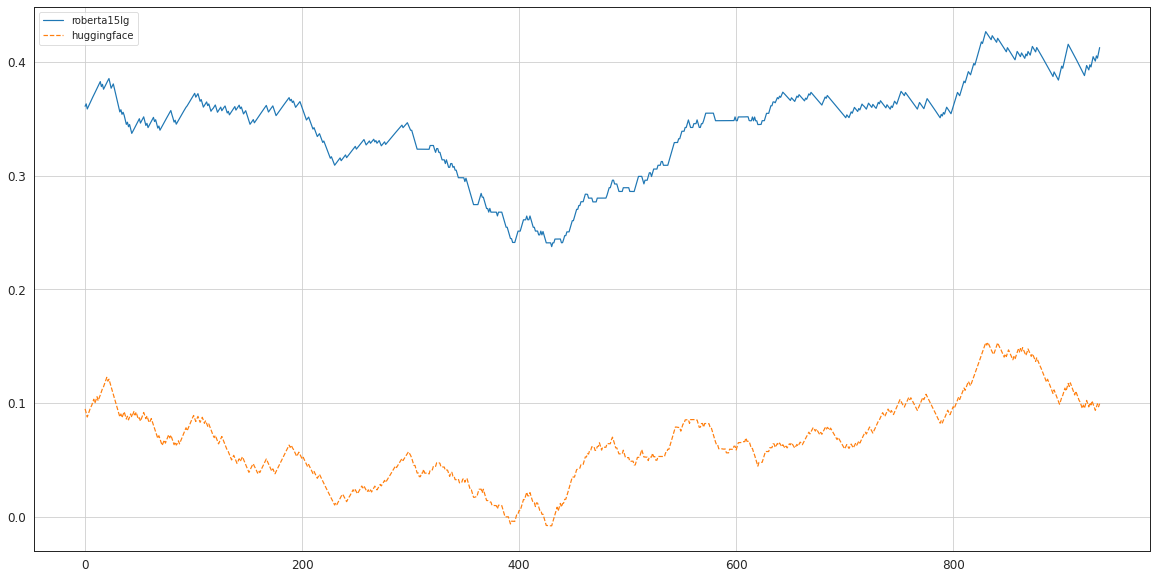

In [ ]:
# Plot all models

models_all_ls = list(global_vars.corpus_texts_dt[corpus_texts_ls[0]].select_dtypes(include=[np.float]).columns)

global_vars.corpus_texts_dt[corpus_texts_ls[0]][models_all_ls].rolling(600, center=True, min_periods=0).mean().plot()
plt.grid(True)
plt.show();

In [ ]:
global_vars.corpus_texts_dt[corpus_texts_ls[0]]

,text_raw,text_clean,roberta15lg,huggingface
0,Timothy F Geithner: Developments in the global economy and implications for the United States Re...,timothy f geithner development in the global economy and implication for the unite state remark ...,0.993093,0.848771
1,"It is a pleasure to be here at the Council on Foreign Relations, and to be here with Jerry Corri...",it be a pleasure to be here at the council on foreign relation and to be here with jerry corrigan,0.998892,0.999224
2,"A few brief remarks about the global economy, both the real and financial dimensions, to provide...",a few brief remark about the global economy both the real and financial dimension to provide a b...,0.998106,0.994493
3,2006 marked the fourth successive year of a global expansion that has been remarkable for its st...,mark the 4 successive year of a global expansion that have be remarkable for its strength for it...,0.998879,0.999847
4,This period of broad-based growth in income has been supported by a number of important fundamen...,this period of broad base growth in income have be support by a numb of important fundamental force,0.998546,0.972342
...,...,...,...,...
931,Many households including those previously lacking access to credit or with access only to expe...,many household include that previously lack access to credit or with access only to expensive cr...,0.998599,-0.997291
932,"Prices rose across a range of real and financial assets, most notably the prices of homes.",price rise across a range of real and financial asset much notably the price of home,0.997511,0.998915
933,This constellation of broad economic and financial conditions was accompanied by rapid innovatio...,this constellation of broad economic and financial condition be accompany by rapid innovation in...,0.998676,0.999097
934,These instruments allowed investors to buy insurance or protection against a broader range of in...,this instrument allow investor to buy insurance or protection against a broad range of individua...,0.998390,0.962778


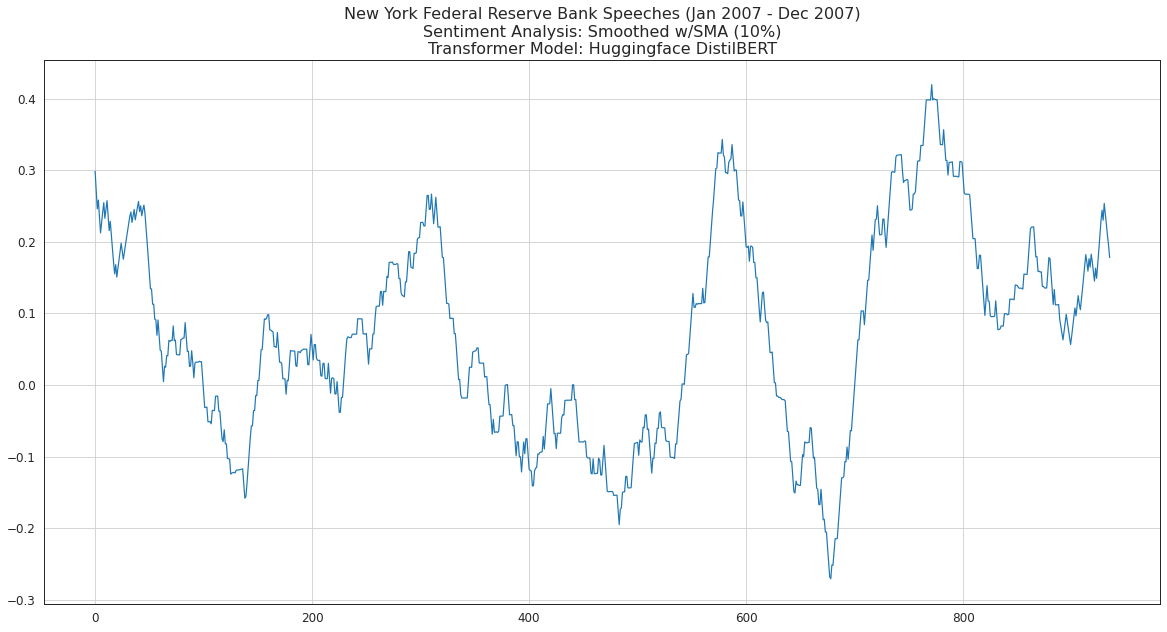

In [ ]:
# Verify Plausiblity of new Sentiment Values by Plotting

novel_indx = 0
corpus_text_str = corpus_texts_ls[novel_indx]
# amodel_str = 'huggingface' 
win_aper = 10

win_per = int((win_aper/100.)*global_vars.corpus_texts_dt[corpus_text_str][model_name].shape[0])
# print(f'win_per: {win_per}')
text_title_str = f"{global_vars.corpus_titles_dt[corpus_text_str][0]}\nSentiment Analysis: Smoothed w/SMA ({win_aper}%)\n{model_type} Model: {model_title}"
# print(f'text_title_str: {text_title_str}')
global_vars.corpus_texts_dt[corpus_text_str][model_name].rolling(win_per, center=True, min_periods=0).mean().plot(title=text_title_str)
plt.grid(True)
plt.show();

### **Save Checkpoint**

In [ ]:
# Verify in SentimentArcs Root Directory

model_current = 'huggingface'

os.chdir(Path_to_SentimentArcs)

print('Currently in SentimentArcs root directory:')
!pwd

print(f'Saving Text_Type: {Corpus_Genre}')
print(f'     Corpus_Type: {Corpus_Type}')

# Verify Subdir to save Cleaned Texts and Texts into..

print(f'\nThese Text Titles:\n')
global_vars.corpus_texts_dt.keys()

print(f'\nTo This Subdirectory:\n')
PATH_SENTIMENT_RAW


# Save sentiment values to subdir_sentiments

# os.chdir(Path_to_SentimentArcs)

if Corpus_Type == 'new':
  save_filename = f'sentiment_raw_{Corpus_Genre}_{Corpus_Type}_corpus{Corpus_Number}_transformer_{model_current}.json'
else:
  save_filename = f'sentiment_raw_{Corpus_Genre}_{Corpus_Type}_transformer_{model_current}.json'

# Filter out all models but Current One 
current_model_dt = {}
cols_current_model_ls = []

for i, atext in enumerate(corpus_texts_ls):
  print(f'Saving {model_current} Model for all Texts')
  current_model_dt[atext] = pd.DataFrame(global_vars.corpus_texts_dt[atext][model_current])

write_dict_dfs(current_model_dt, out_file=save_filename, out_dir=f'{PATH_SENTIMENT_RAW}/')



Currently in SentimentArcs root directory:
/gdrive/MyDrive/sentimentarcs_notebooks
Saving Text_Type: finance
     Corpus_Type: new

These Text Titles:



dict_keys(['nyfederalreserve_speeches_2007'])


To This Subdirectory:



'./sentiment_raw/sentiment_raw_finance_new_corpus9/'

Saving file to: ./sentiment_raw/sentiment_raw_finance_new_corpus9//sentiment_raw_finance_new_corpus9_transformer_huggingface.json


In [ ]:
# Verify json file created

!ls -altr $PATH_SENTIMENT_RAW

total 1632
-rw------- 1 root root 472859 Apr 18 18:54 sentiment_raw_finance_new_corpus9_all_4syuzhetr.json
-rw------- 1 root root 747037 Apr 18 18:56 sentiment_raw_finance_new_corpus9_all_8sentimentr.json
-rw------- 1 root root 386964 Apr 18 19:06 sentiment_raw_finance_new_corpus9_transformer_roberta15lg.json
-rw------- 1 root root  63091 Apr 18 19:09 sentiment_raw_finance_new_corpus9_transformer_huggingface.json


## **NLPTown Multilingual BERT (5 cats)**

In [ ]:
# NLPTown: Multilingual trained BERT Model

sa_model = None
del sa_model
sa_model = pipeline("sentiment-analysis",model="nlptown/bert-base-multilingual-uncased-sentiment")

# Test
# print(sa_nlptown("I love this!"))
print(sa_model("I love this!"))

[{'label': '5 stars', 'score': 0.9236246943473816}]


In [ ]:
# Define Model and Test

model_title = 'NLPTown MultiBERT'
model_name = 'nlptown'
model_type = 'Transformer'

# Test Emoji
sa_model("We are very happy to show you the 🤗 Transformers library.")
print('\n\n')

# Test Words
print(f'Testing WORD Sentiment')
print('--------------------------------------------------')
for i, aword_str in enumerate(global_vars.TEST_WORDS_LS):

  word_sentiment_fl = sa_model(aword_str)
  print(f'Word: {aword_str}\n    {word_sentiment_fl}\n')

# Test Sentences
print(f'\nTesting SENTENCE Sentiment')
print('--------------------------------------------------')
for i, asent_str in enumerate(global_vars.TEST_SENTENCES_LS):

  sent_sentiment_fl = sa_model(asent_str)
  print(f'Sentence: {asent_str}\n    {sent_sentiment_fl}\n')

[{'label': '5 stars', 'score': 0.7725350260734558}]




Testing WORD Sentiment
--------------------------------------------------
Word: Love
    [{'label': '5 stars', 'score': 0.6595041751861572}]

Word: Hate
    [{'label': '1 star', 'score': 0.693548321723938}]

Word: bizarre
    [{'label': '1 star', 'score': 0.3379124104976654}]

Word: strange
    [{'label': '1 star', 'score': 0.28947705030441284}]

Word: furious
    [{'label': '1 star', 'score': 0.6228679418563843}]

Word: elated
    [{'label': '2 stars', 'score': 0.34351810812950134}]

Word: curious
    [{'label': '3 stars', 'score': 0.387085884809494}]

Word: beserk
    [{'label': '5 stars', 'score': 0.312057226896286}]

Word: gambaro
    [{'label': '3 stars', 'score': 0.2532377541065216}]


Testing SENTENCE Sentiment
--------------------------------------------------
Sentence: I hate bad evil worthless Mondays.
    [{'label': '1 star', 'score': 0.8850790858268738}]

Sentence: I love Paris in the springtime
    [{'label': '5 stars', 'score': 0.6275702118873596}]

Sentence: It was We

In [ ]:
%%time

# NOTE:   9m05s @16:40 on 20220301 Colab Pro P100 (1 Novel: cmieville_thecityandthecity)
#        ~8m07s @16:49 on 20220201 Colab Pro P100 (1 Novel: scollins_thehungergames1)
#        25m14s @08:58 on 20220412 Colab Pro P100 (3 Novels, 1.2M, 1.3M, 1.7M)
#        25m14s @11:53 on 20220412 Colab Pro P100 (3 Novels, 1.2M, 1.3M, 1.7M)

#       ~18m30s @14:23 on 20220412 Colab Pro T4 (2 Novels: 1M, 1.1M)


for i, atext in enumerate(global_vars.corpus_texts_dt.keys()):
  models_ls = global_vars.corpus_texts_dt[atext].columns
  print(f"Processing #{i}: {atext}")
  if (Force_Recompute == True) or (model_name not in models_ls):
    global_vars.corpus_texts_dt[atext][model_name] = global_vars.corpus_texts_dt[atext]['text_clean'].apply(lambda x: labelscore2fl(sa_model(x), sa_model='nlptown'))
    print(f'  [{model_name}] Sentiment Recomputed and Value Updated')
  else:
    print(f'  [{model_name}] Already in DataFrame and no Forced Recompute, so no update made')

Processing #0: nyfederalreserve_speeches_2007
  [nlptown] Sentiment Recomputed and Value Updated
CPU times: user 1min 50s, sys: 327 ms, total: 1min 51s
Wall time: 1min 51s


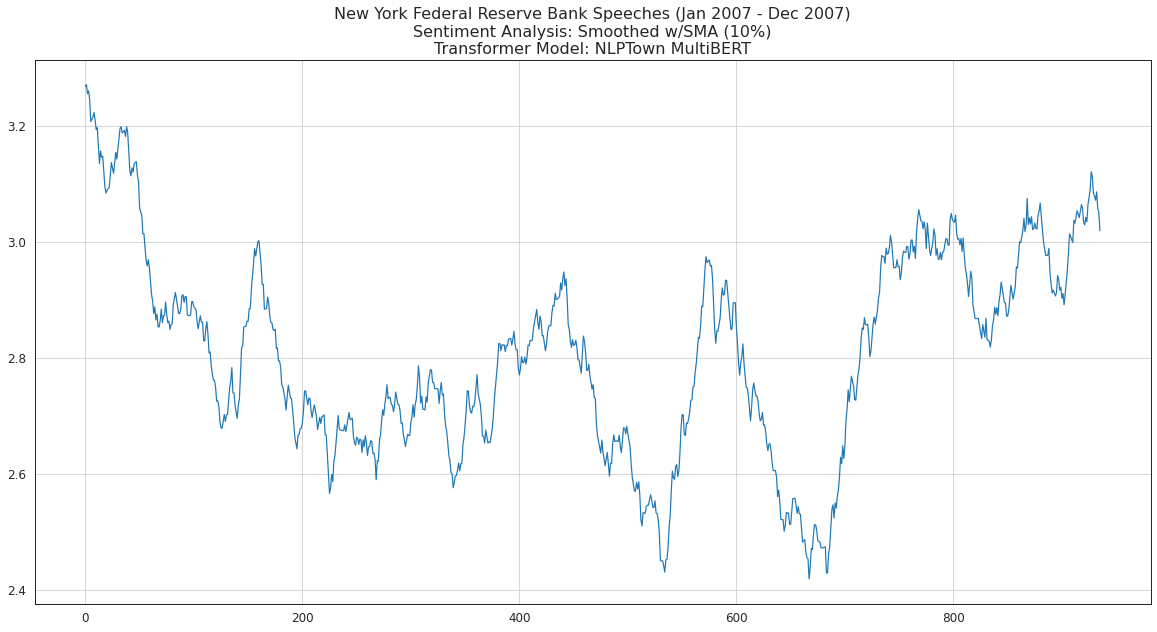

In [ ]:
# Verify Plausiblity of new Sentiment Values by Plotting

novel_indx = 0
corpus_text_str = corpus_texts_ls[novel_indx]
# amodel_str = 'huggingface' 
win_aper = 10

win_per = int((win_aper/100.)*global_vars.corpus_texts_dt[corpus_text_str][model_name].shape[0])
text_title_str = f"{global_vars.corpus_titles_dt[corpus_text_str][0]}\nSentiment Analysis: Smoothed w/SMA ({win_aper}%)\n{model_type} Model: {model_title}"
global_vars.corpus_texts_dt[corpus_text_str][model_name].rolling(win_per, center=True, min_periods=0).mean().plot(title=text_title_str)
plt.grid(True)
plt.show();

In [ ]:
global_vars.corpus_texts_dt[corpus_texts_ls[0]]

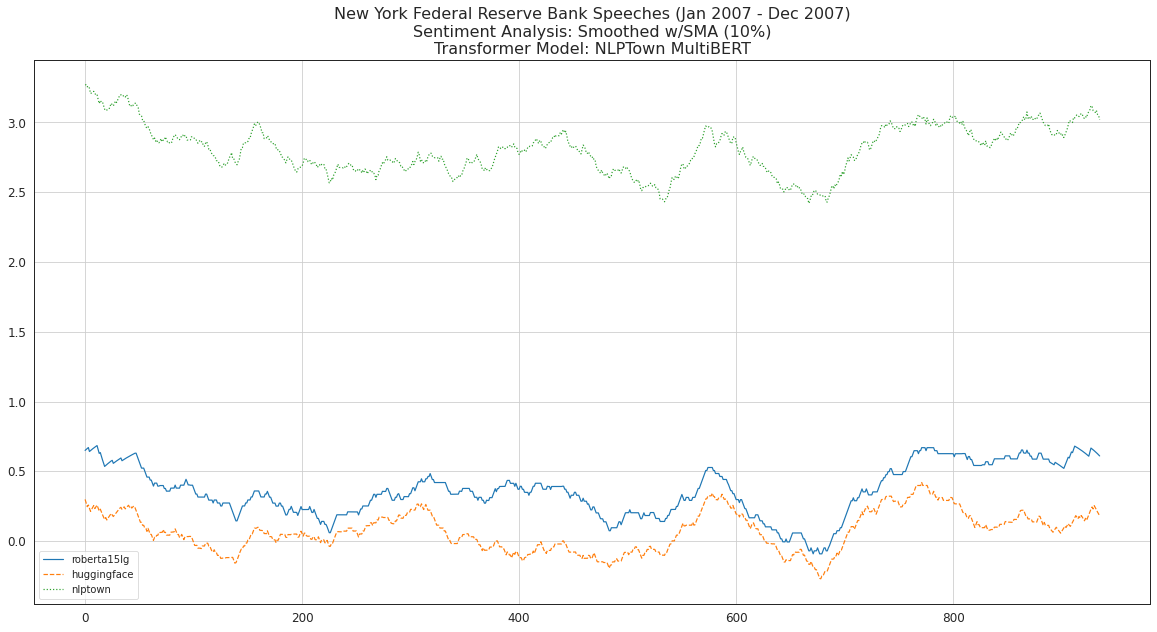

In [ ]:
# Plot all models

novel_indx = 0
corpus_text_str = corpus_texts_ls[novel_indx]
win_aper = 10

models_all_ls = list(global_vars.corpus_texts_dt[corpus_text_str].select_dtypes(include=[np.float]).columns)

win_per = int((win_aper/100.)*global_vars.corpus_texts_dt[corpus_text_str][model_name].shape[0])
text_title_str = f"{global_vars.corpus_titles_dt[corpus_text_str][0]}\nSentiment Analysis: Smoothed w/SMA ({win_aper}%)\n{model_type} Model: {model_title}"
global_vars.corpus_texts_dt[corpus_text_str][models_all_ls].rolling(win_per, center=True, min_periods=0).mean().plot(title=text_title_str)
plt.grid(True)
plt.show();

### **Save Checkpoint**

In [ ]:
# Verify in SentimentArcs Root Directory

model_current = 'nlptown'

os.chdir(Path_to_SentimentArcs)

print('Currently in SentimentArcs root directory:')
!pwd

print(f'Saving Text_Type: {Corpus_Genre}')
print(f'     Corpus_Type: {Corpus_Type}')

# Verify Subdir to save Cleaned Texts and Texts into..

print(f'\nThese Text Titles:\n')
global_vars.corpus_texts_dt.keys()

print(f'\nTo This Subdirectory:\n')
PATH_SENTIMENT_RAW


# Save sentiment values to subdir_sentiments

# os.chdir(Path_to_SentimentArcs)

if Corpus_Type == 'new':
  save_filename = f'sentiment_raw_{Corpus_Genre}_{Corpus_Type}_corpus{Corpus_Number}_transformer_{model_current}.json'
else:
  save_filename = f'sentiment_raw_{Corpus_Genre}_{Corpus_Type}_transformer_{model_current}.json'

# Filter out all models but Current One 
current_model_dt = {}
cols_current_model_ls = []

for i, atext in enumerate(corpus_texts_ls):
  print(f'Saving {model_current} Model for all Texts')
  current_model_dt[atext] = pd.DataFrame(global_vars.corpus_texts_dt[atext][model_current])

write_dict_dfs(current_model_dt, out_file=save_filename, out_dir=f'{PATH_SENTIMENT_RAW}/')



Currently in SentimentArcs root directory:
/gdrive/MyDrive/sentimentarcs_notebooks
Saving Text_Type: finance
     Corpus_Type: new

These Text Titles:



dict_keys(['nyfederalreserve_speeches_2007'])


To This Subdirectory:



'./sentiment_raw/sentiment_raw_finance_new_corpus9/'

Saving file to: ./sentiment_raw/sentiment_raw_finance_new_corpus9//sentiment_raw_finance_new_corpus9_transformer_nlptown.json


In [ ]:
# Verify json file created

!ls -altr $PATH_SENTIMENT_RAW

total 1747
-rw------- 1 root root 472859 Apr 18 18:54 sentiment_raw_finance_new_corpus9_all_4syuzhetr.json
-rw------- 1 root root 747037 Apr 18 18:56 sentiment_raw_finance_new_corpus9_all_8sentimentr.json
-rw------- 1 root root 386964 Apr 18 19:06 sentiment_raw_finance_new_corpus9_transformer_roberta15lg.json
-rw------- 1 root root  63091 Apr 18 19:09 sentiment_raw_finance_new_corpus9_transformer_huggingface.json
-rw------- 1 root root  58514 Apr 18 19:27 sentiment_raw_finance_new_corpus9_transformer_yelp.json
-rw------- 1 root root  58514 Apr 18 19:30 sentiment_raw_finance_new_corpus9_transformer_nlptown.json


## **Yelp Finetuned BERT (5 cats)**

In [ ]:
# Yelp Trained BERT Sentiment Classifier

tokenizer = AutoTokenizer.from_pretrained("gilf/english-yelp-sentiment")

sa_model = None
del sa_model
sa_model = AutoModelForSequenceClassification.from_pretrained("gilf/english-yelp-sentiment")

In [ ]:
# Test

text_str = "I love sunny days and happy puppy dogs."
text_enc = tokenizer(text_str, return_tensors='pt')
text_sentiment = sa_model(**text_enc)
print(f'Yelp SA Model:\n  INPUT: {text_str}\n  SENTIMENT: {text_sentiment}')
print(f'  TYPE: {type(text_sentiment)}')
text_smax_ls_ls = text_sentiment.logits.softmax(dim=-1).tolist()
text_smax_ls = text_smax_ls_ls[0]
print(type(text_smax_ls[0]))
print(f'  sMAX: {text_smax_ls}')
max_val = max(text_smax_ls)
max_indx = text_smax_ls.index(max_val)
print(f'   MAX: {max_val} at indx={max_indx}')

Yelp SA Model:
  INPUT: I love sunny days and happy puppy dogs.
  SENTIMENT: SequenceClassifierOutput(loss=None, logits=tensor([[-2.6225, -1.4072,  0.8254,  1.6360,  1.3209]],
       grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)
  TYPE: <class 'transformers.modeling_outputs.SequenceClassifierOutput'>
<class 'float'>
  sMAX: [0.00632500508800149, 0.02132244221866131, 0.19882361590862274, 0.4471935033798218, 0.3263353705406189]
   MAX: 0.4471935033798218 at indx=3


In [ ]:
# Test

text_str = "I love sunny days and happy puppy dogs."
text_enc = tokenizer(text_str, return_tensors='pt')
text_sentiment = sa_model(**text_enc)

sentiment_val, sentiment_scale, sentiment_prob = logitstensor2sentiment(text_sentiment)
print(f'\n\nSENTENCE: {text_str}')
print(f'          Sentiment: {sentiment_val} out of {sentiment_scale} (prob={sentiment_prob:.3f})')



SENTENCE: I love sunny days and happy puppy dogs.
          Sentiment: 3 out of 5 (prob=0.447)


In [ ]:
# Define Model and Test

model_title = 'Yelp BERT'
model_name = 'yelp'
model_type = 'Transformer'

# Test Emoji
emoji_str = "We are very happy to show you the 🤗 Transformers library."
aemoji_str_enc = tokenizer(emoji_str, return_tensors='pt')
logits_tensor = sa_model(**aemoji_str_enc)
sentiment_val, sentiment_scale, sentiment_prob = logitstensor2sentiment(logits_tensor)
print(f'Emoji String: {emoji_str}\n    Sentiment: {sentiment_val} out of {sentiment_scale} (prob={sentiment_prob:.3f})\n')
print('\n\n')

# Test Words
print(f'Testing WORD Sentiment')
print('--------------------------------------------------')
for i, aword_str in enumerate(global_vars.TEST_WORDS_LS):

  aword_enc = tokenizer(aword_str, return_tensors='pt')
  logits_tensor = sa_model(**aword_enc)
  sentiment_val, sentiment_scale, sentiment_prob = logitstensor2sentiment(logits_tensor)
  print(f'Word: {aword_str}\n    Sentiment: {sentiment_val} out of {sentiment_scale} (prob={sentiment_prob:.3f})\n')

# Test Sentences
print(f'\nTesting SENTENCE Sentiment')
print('--------------------------------------------------')
for i, asent_str in enumerate(global_vars.TEST_SENTENCES_LS):

  aword_enc = tokenizer(asent_str, return_tensors='pt')
  logits_tensor = sa_model(**aword_enc)
  sentiment_val, sentiment_scale, sentiment_prob = logitstensor2sentiment(logits_tensor)
  print(f'Word: {asent_str}\n    Sentiment: {sentiment_val} out of {sentiment_scale} (prob={sentiment_prob:.3f})\n')


Emoji String: We are very happy to show you the 🤗 Transformers library.
    Sentiment: 4 out of 5 (prob=0.493)




Testing WORD Sentiment
--------------------------------------------------
Word: Love
    Sentiment: 4 out of 5 (prob=0.550)

Word: Hate
    Sentiment: 0 out of 5 (prob=0.770)

Word: bizarre
    Sentiment: 2 out of 5 (prob=0.475)

Word: strange
    Sentiment: 2 out of 5 (prob=0.550)

Word: furious
    Sentiment: 0 out of 5 (prob=0.856)

Word: elated
    Sentiment: 2 out of 5 (prob=0.294)

Word: curious
    Sentiment: 2 out of 5 (prob=0.499)

Word: beserk
    Sentiment: 2 out of 5 (prob=0.370)

Word: gambaro
    Sentiment: 3 out of 5 (prob=0.543)


Testing SENTENCE Sentiment
--------------------------------------------------
Word: I hate bad evil worthless Mondays.
    Sentiment: 0 out of 5 (prob=0.297)

Word: I love Paris in the springtime
    Sentiment: 3 out of 5 (prob=0.485)

Word: It was Wednesday.
    Sentiment: 2 out of 5 (prob=0.517)

Word: You are a disgusting pig -

In [ ]:
# TODO: check for recovery from multiple runs/overwrites
# TODO: pull save repetitive 3code blocks checkpoint code into single def

Force_Recompute = True

In [ ]:
%%time

# NOTE:    10m45s @17:39 on 20220301 Colab Pro P100 (1 Novel: cmieville_thecityandthecity: 10.1k sentences)
#          10m19s @17:48 on 20220301 Colab Pro P100 (1 Novel: scollins_thehungergames1: 9.0k sentences)

#          49m55s @12:45 on 20220412 Colab Pro P100 (3 Novels, 1.2M, 1.3M, 1.7M)
#          49m55s @14:54 on 20220412 Colab Pro T4 (2 Novels: 1M, 1.1M)

#          30m27s @23:32 on 20220412 Colab Pro P100 (3 Novels, 1.2M, 1.3M, 1.7M)

for i, atext in enumerate(global_vars.corpus_texts_dt.keys()):
  models_ls = global_vars.corpus_texts_dt[atext].columns
  print(f"Processing #{i}: {atext}")
  if (Force_Recompute == True) or (model_name not in models_ls):
    # corpus_texts_dt[atext][model_name] = corpus_texts_dt[atext]['text_clean'].apply(lambda x: logitstensor2sentiment(sa_yelp(**tokenizer(x, return_tensors='pt')))[0])
    global_vars.corpus_texts_dt[atext][model_name] = global_vars.corpus_texts_dt[atext]['text_clean'].apply(lambda x: logitstensor2sentiment(sa_model(**tokenizer(x, return_tensors='pt')))[0])
    print(f'  [{model_name}] Sentiment Recomputed and Value Updated')
  else:
    print(f'  [{model_name}] Already in DataFrame and no Forced Recompute, so no update made')


Processing #0: nyfederalreserve_speeches_2007
  [yelp] Sentiment Recomputed and Value Updated
CPU times: user 2min 17s, sys: 872 ms, total: 2min 18s
Wall time: 2min 33s


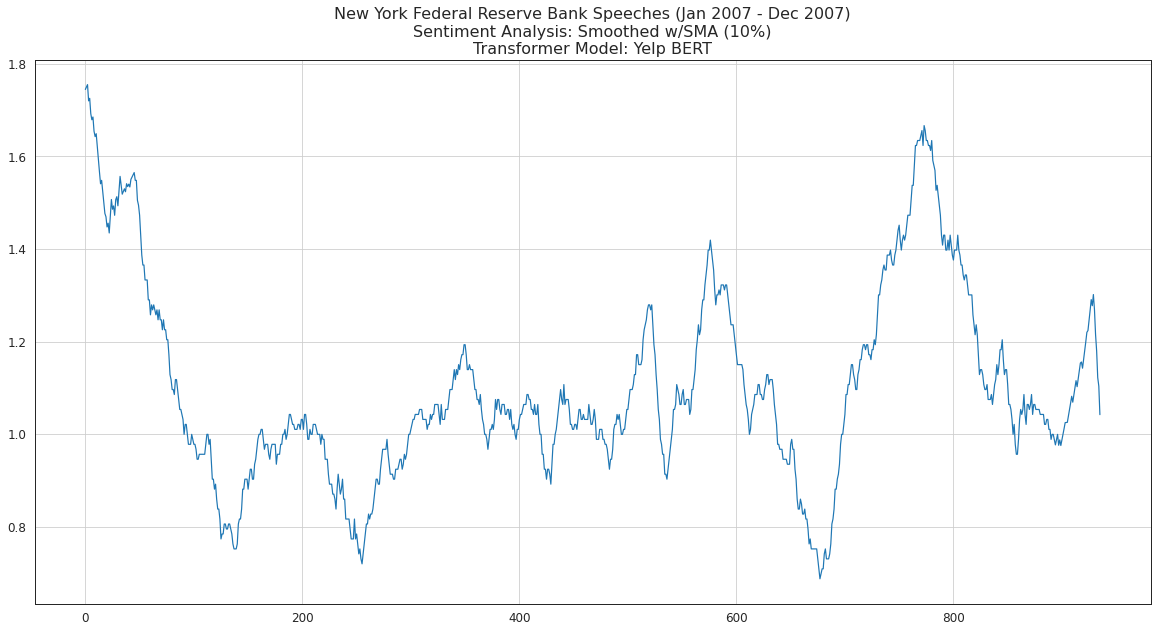

In [ ]:
# Verify Plausiblity of new Sentiment Values by Plotting

novel_indx = 0
corpus_text_str = corpus_texts_ls[novel_indx]
# amodel_str = 'huggingface' 
win_aper = 10

win_per = int((win_aper/100.)*global_vars.corpus_texts_dt[corpus_text_str][model_name].shape[0])
text_title_str = f"{global_vars.corpus_titles_dt[corpus_text_str][0]}\nSentiment Analysis: Smoothed w/SMA ({win_aper}%)\n{model_type} Model: {model_title}"
global_vars.corpus_texts_dt[corpus_text_str][model_name].rolling(win_per, center=True, min_periods=0).mean().plot(title=text_title_str)
plt.grid(True)
plt.show();

In [ ]:
global_vars.corpus_texts_dt[corpus_text_str].head()

,text_raw,text_clean,roberta15lg,huggingface,nlptown,yelp
0,Timothy F Geithner: Developments in the global economy and implications for the United States Re...,timothy f geithner development in the global economy and implication for the unite state remark ...,0.993093,0.848771,3.286715,0
1,"It is a pleasure to be here at the Council on Foreign Relations, and to be here with Jerry Corri...",it be a pleasure to be here at the council on foreign relation and to be here with jerry corrigan,0.998892,0.999224,4.483013,4
2,"A few brief remarks about the global economy, both the real and financial dimensions, to provide...",a few brief remark about the global economy both the real and financial dimension to provide a b...,0.998106,0.994493,3.481419,2
3,2006 marked the fourth successive year of a global expansion that has been remarkable for its st...,mark the 4 successive year of a global expansion that have be remarkable for its strength for it...,0.998879,0.999847,4.495041,4
4,This period of broad-based growth in income has been supported by a number of important fundamen...,this period of broad base growth in income have be support by a numb of important fundamental force,0.998546,0.972342,1.259609,4


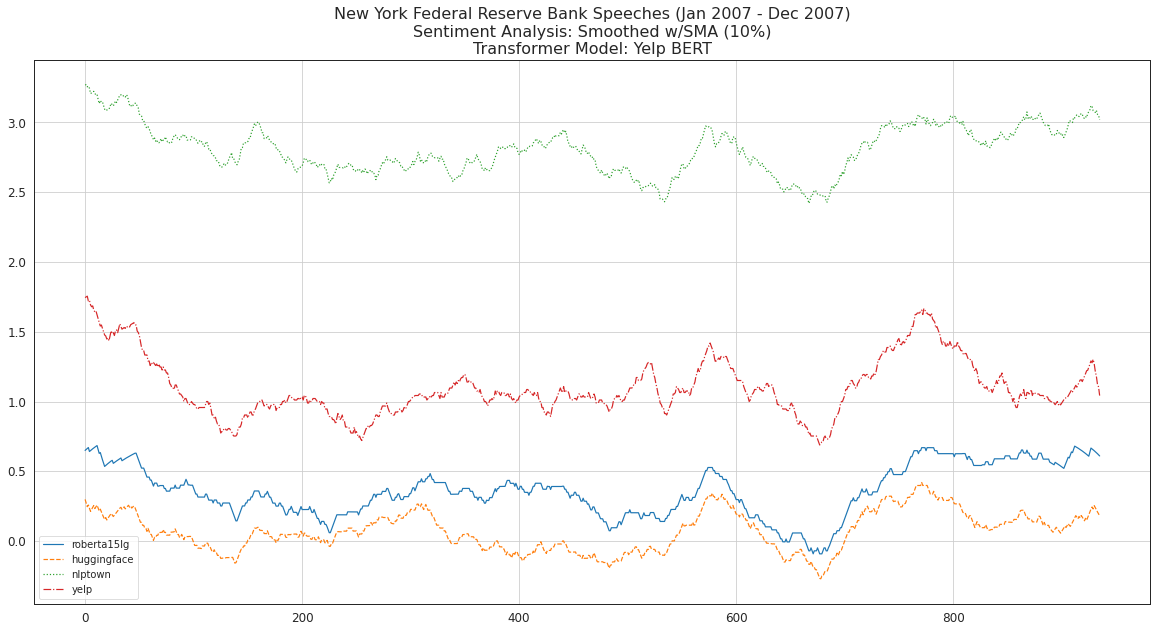

In [ ]:
# Plot all models

novel_indx = 0
corpus_text_str = corpus_texts_ls[novel_indx]
win_aper = 10

models_all_ls = list(global_vars.corpus_texts_dt[corpus_text_str].select_dtypes(include=[np.float,np.int]).columns)

win_per = int((win_aper/100.)*global_vars.corpus_texts_dt[corpus_text_str][model_name].shape[0])
text_title_str = f"{global_vars.corpus_titles_dt[corpus_text_str][0]}\nSentiment Analysis: Smoothed w/SMA ({win_aper}%)\n{model_type} Model: {model_title}"
global_vars.corpus_texts_dt[corpus_text_str][models_all_ls].rolling(win_per, center=True, min_periods=0).mean().plot(title=text_title_str)
plt.grid(True)
plt.show();

### **Save Checkpoint**

In [ ]:
# Verify in SentimentArcs Root Directory

model_current = 'yelp'

os.chdir(Path_to_SentimentArcs)

print('Currently in SentimentArcs root directory:')
!pwd

print(f'Saving Text_Type: {Corpus_Genre}')
print(f'     Corpus_Type: {Corpus_Type}')

# Verify Subdir to save Cleaned Texts and Texts into..

print(f'\nThese Text Titles:\n')
global_vars.corpus_texts_dt.keys()

print(f'\nTo This Subdirectory:\n')
PATH_SENTIMENT_RAW


# Save sentiment values to subdir_sentiments

# os.chdir(Path_to_SentimentArcs)

if Corpus_Type == 'new':
  save_filename = f'sentiment_raw_{Corpus_Genre}_{Corpus_Type}_corpus{Corpus_Number}_transformer_{model_current}.json'
else:
  save_filename = f'sentiment_raw_{Corpus_Genre}_{Corpus_Type}_transformer_{model_current}.json'


# Filter out all models but Current One to Save
current_model_dt = {}
cols_current_model_ls = []

for i, atext in enumerate(corpus_texts_ls):
  print(f'Saving {model_current} Model for all Texts')
  current_model_dt[atext] = pd.DataFrame(global_vars.corpus_texts_dt[atext][model_current])

write_dict_dfs(current_model_dt, out_file=save_filename, out_dir=f'{PATH_SENTIMENT_RAW}/')

Currently in SentimentArcs root directory:
/gdrive/MyDrive/sentimentarcs_notebooks
Saving Text_Type: finance
     Corpus_Type: new

These Text Titles:



dict_keys(['nyfederalreserve_speeches_2007'])


To This Subdirectory:



'./sentiment_raw/sentiment_raw_finance_new_corpus9/'

Saving file to: ./sentiment_raw/sentiment_raw_finance_new_corpus9//sentiment_raw_finance_new_corpus9_transformer_yelp.json


In [ ]:
# Verify json file created

!ls -altr $PATH_SENTIMENT_RAW

total 1729
-rw------- 1 root root 472859 Apr 18 18:54 sentiment_raw_finance_new_corpus9_all_4syuzhetr.json
-rw------- 1 root root 747037 Apr 18 18:56 sentiment_raw_finance_new_corpus9_all_8sentimentr.json
-rw------- 1 root root 386964 Apr 18 19:06 sentiment_raw_finance_new_corpus9_transformer_roberta15lg.json
-rw------- 1 root root  63091 Apr 18 19:09 sentiment_raw_finance_new_corpus9_transformer_huggingface.json
-rw------- 1 root root  58514 Apr 18 19:30 sentiment_raw_finance_new_corpus9_transformer_nlptown.json
-rw------- 1 root root  40296 Apr 18 19:35 sentiment_raw_finance_new_corpus9_transformer_yelp.json


## **Hinglish Mixed Code BERT (3 cats)**

In [ ]:
# Hindi-English Code Switching BERT Model

tokenizer = AutoTokenizer.from_pretrained("rohanrajpal/bert-base-multilingual-codemixed-cased-sentiment")

sa_model = None
del sa_model
sa_model = AutoModelForSequenceClassification.from_pretrained("rohanrajpal/bert-base-multilingual-codemixed-cased-sentiment")

In [ ]:
# Test

text_str = "I love sunny days and happy puppy dogs."
text_enc = tokenizer(text_str, return_tensors='pt')
text_sentiment = sa_model(**text_enc)
print(f'Hinglish SA Model:\n  INPUT: {text_str}\n  SENTIMENT: {text_sentiment}')
print(f'  TYPE: {type(text_sentiment)}')
text_smax_ls_ls = text_sentiment.logits.softmax(dim=-1).tolist()
text_smax_ls = text_smax_ls_ls[0]
print(type(text_smax_ls[0]))
print(f'  sMAX: {text_smax_ls}')
max_val = max(text_smax_ls)
max_indx = text_smax_ls.index(max_val)
print(f'   MAX: {max_val} at indx={max_indx}')

Hinglish SA Model:
  INPUT: I love sunny days and happy puppy dogs.
  SENTIMENT: SequenceClassifierOutput(loss=None, logits=tensor([[-0.8385, -2.0611,  2.9085]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)
  TYPE: <class 'transformers.modeling_outputs.SequenceClassifierOutput'>
<class 'float'>
  sMAX: [0.02289094403386116, 0.006740636192262173, 0.9703684449195862]
   MAX: 0.9703684449195862 at indx=2


In [ ]:
# Test

text_str = "I love sunny days and happy puppy dogs."
text_enc = tokenizer(text_str, return_tensors='pt')
text_sentiment = sa_model(**text_enc)

sentiment_val, sentiment_scale, sentiment_prob = logitstensor2sentiment(text_sentiment)
print(f'\n\nSENTENCE: {text_str}')
print(f'          Sentiment: {sentiment_val} out of {sentiment_scale} (prob={sentiment_prob:.3f})')



SENTENCE: I love sunny days and happy puppy dogs.
          Sentiment: 2 out of 3 (prob=0.970)


In [ ]:
# Define Model and Test

model_title = 'Hinglish Dual Code BERT'
model_name = 'hinglish'
model_type = 'Transformer'

# Test Emoji
emoji_str = "We are very happy to show you the 🤗 Transformers library."
aemoji_str_enc = tokenizer(emoji_str, return_tensors='pt')
logits_tensor = sa_model(**aemoji_str_enc)
sentiment_val, sentiment_scale, sentiment_prob = logitstensor2sentiment(logits_tensor)
print(f'Emoji String: {emoji_str}\n    Sentiment: {sentiment_val} out of {sentiment_scale} (prob={sentiment_prob:.3f})\n')
print('\n\n')

# Test Words
print(f'Testing WORD Sentiment')
print('--------------------------------------------------')
for i, aword_str in enumerate(global_vars.TEST_WORDS_LS):

  aword_enc = tokenizer(aword_str, return_tensors='pt')
  logits_tensor = sa_model(**aword_enc)
  sentiment_val, sentiment_scale, sentiment_prob = logitstensor2sentiment(logits_tensor)
  print(f'Word: {aword_str}\n    Sentiment: {sentiment_val} out of {sentiment_scale} (prob={sentiment_prob:.3f})\n')

# Test Sentences
print(f'\nTesting SENTENCE Sentiment')
print('--------------------------------------------------')
for i, asent_str in enumerate(global_vars.TEST_SENTENCES_LS):

  aword_enc = tokenizer(asent_str, return_tensors='pt')
  logits_tensor = sa_model(**aword_enc)
  sentiment_val, sentiment_scale, sentiment_prob = logitstensor2sentiment(logits_tensor)
  print(f'Word: {asent_str}\n    Sentiment: {sentiment_val} out of {sentiment_scale} (prob={sentiment_prob:.3f})\n')


Emoji String: We are very happy to show you the 🤗 Transformers library.
    Sentiment: 2 out of 3 (prob=0.970)




Testing WORD Sentiment
--------------------------------------------------
Word: Love
    Sentiment: 2 out of 3 (prob=0.940)

Word: Hate
    Sentiment: 1 out of 3 (prob=0.733)

Word: bizarre
    Sentiment: 2 out of 3 (prob=0.772)

Word: strange
    Sentiment: 2 out of 3 (prob=0.742)

Word: furious
    Sentiment: 2 out of 3 (prob=0.943)

Word: elated
    Sentiment: 2 out of 3 (prob=0.754)

Word: curious
    Sentiment: 2 out of 3 (prob=0.511)

Word: beserk
    Sentiment: 0 out of 3 (prob=0.702)

Word: gambaro
    Sentiment: 0 out of 3 (prob=0.601)


Testing SENTENCE Sentiment
--------------------------------------------------
Word: I hate bad evil worthless Mondays.
    Sentiment: 1 out of 3 (prob=0.880)

Word: I love Paris in the springtime
    Sentiment: 2 out of 3 (prob=0.958)

Word: It was Wednesday.
    Sentiment: 2 out of 3 (prob=0.584)

Word: You are a disgusting pig -

In [ ]:
%%time

# NOTE:    10m45s @17:39 on 20220301 Colab Pro P100 (1 Novel: cmieville_thecityandthecity: 10.1k sentences)
#          10m19s @17:48 on 20220301 Colab Pro P100 (1 Novel: scollins_thehungergames1: 9.0k sentences)

#          49m55s @12:45 on 20220412 Colab Pro P100 (3 Novels, 1.2M, 1.3M, 1.7M)
#          49m55s @14:54 on 20220412 Colab Pro T4 (2 Novels: 1M, 1.1M)

#          30m45s @00:06 on 20220413 Colab Pro P100 (3 Novels, 1.2M, 1.3M, 1.7M)


for i, atext in enumerate(global_vars.corpus_texts_dt.keys()):
  models_ls = global_vars.corpus_texts_dt[atext].columns
  print(f"Processing #{i}: {atext}")
  if (Force_Recompute == True) or (model_name not in models_ls):
    # corpus_texts_dt[atext][model_name] = corpus_texts_dt[atext]['text_clean'].apply(lambda x: logitstensor2sentiment(sa_yelp(**tokenizer(x, return_tensors='pt')))[0])
    global_vars.corpus_texts_dt[atext][model_name] = global_vars.corpus_texts_dt[atext]['text_clean'].apply(lambda x: logitstensor2sentiment(sa_model(**tokenizer(x, return_tensors='pt')))[0])
    print(f'  [{model_name}] Sentiment Recomputed and Value Updated')
  else:
    print(f'  [{model_name}] Already in DataFrame and no Forced Recompute, so no update made')


Processing #0: nyfederalreserve_speeches_2007
  [hinglish] Sentiment Recomputed and Value Updated
CPU times: user 1min 55s, sys: 631 ms, total: 1min 56s
Wall time: 1min 55s


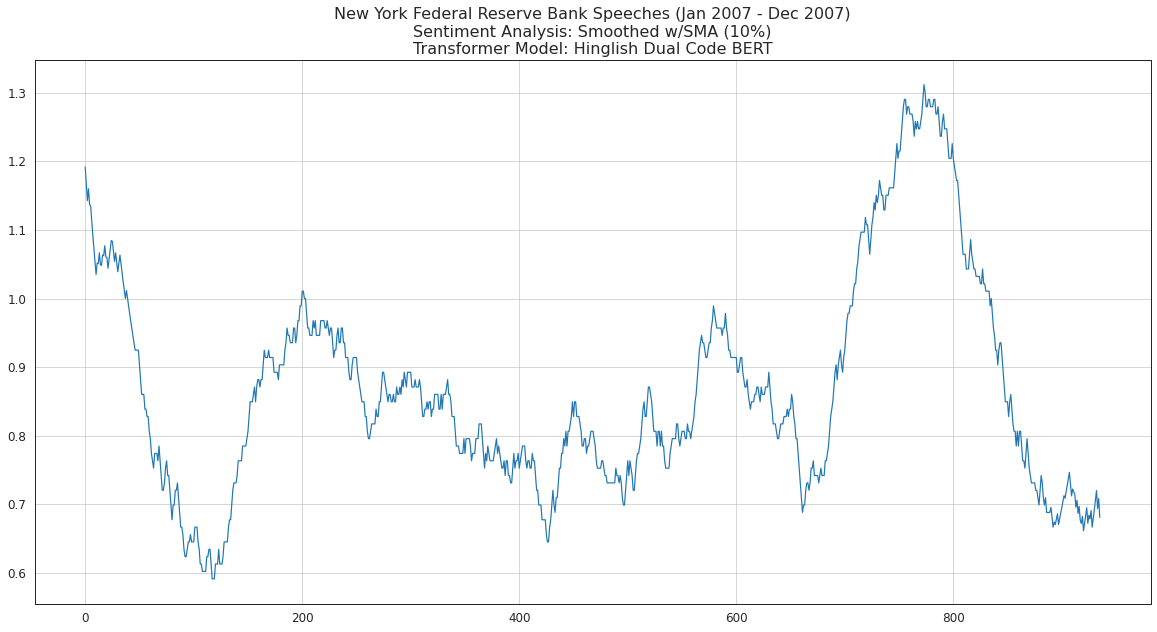

In [ ]:
# Verify Plausiblity of new Sentiment Values by Plotting

novel_indx = 0
corpus_text_str = corpus_texts_ls[novel_indx]
# amodel_str = 'huggingface' 
win_aper = 10

win_per = int((win_aper/100.)*global_vars.corpus_texts_dt[corpus_text_str][model_name].shape[0])
text_title_str = f"{global_vars.corpus_titles_dt[corpus_text_str][0]}\nSentiment Analysis: Smoothed w/SMA ({win_aper}%)\n{model_type} Model: {model_title}"
global_vars.corpus_texts_dt[corpus_text_str][model_name].rolling(win_per, center=True, min_periods=0).mean().plot(title=text_title_str)
plt.grid(True)
plt.show();

In [288]:
global_vars.corpus_texts_dt[corpus_text_str].head()

,text_raw,text_clean,roberta15lg,huggingface,nlptown,yelp,hinglish,imdb2way
0,Timothy F Geithner: Developments in the global economy and implications for the United States Re...,timothy f geithner development in the global economy and implication for the unite state remark ...,0.993093,0.848771,3.286715,0,0,1
1,"It is a pleasure to be here at the Council on Foreign Relations, and to be here with Jerry Corri...",it be a pleasure to be here at the council on foreign relation and to be here with jerry corrigan,0.998892,0.999224,4.483013,4,0,1
2,"A few brief remarks about the global economy, both the real and financial dimensions, to provide...",a few brief remark about the global economy both the real and financial dimension to provide a b...,0.998106,0.994493,3.481419,2,0,1
3,2006 marked the fourth successive year of a global expansion that has been remarkable for its st...,mark the 4 successive year of a global expansion that have be remarkable for its strength for it...,0.998879,0.999847,4.495041,4,2,1
4,This period of broad-based growth in income has been supported by a number of important fundamen...,this period of broad base growth in income have be support by a numb of important fundamental force,0.998546,0.972342,1.259609,4,2,1


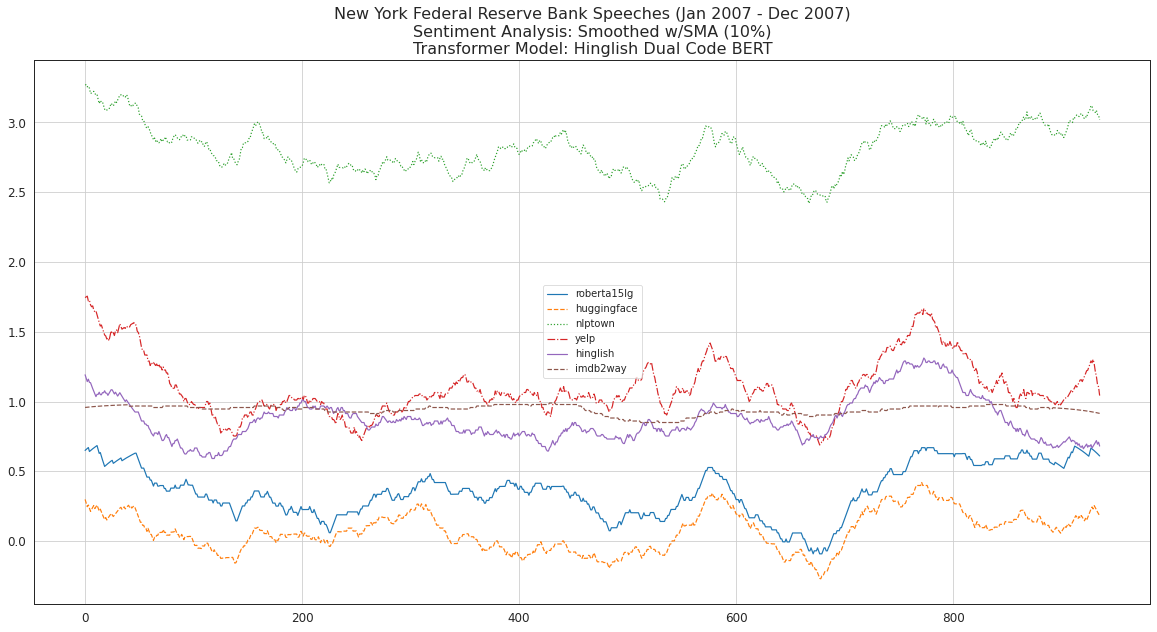

In [289]:
# Plot all models

novel_indx = 0
corpus_text_str = corpus_texts_ls[novel_indx]
win_aper = 10

models_all_ls = list(global_vars.corpus_texts_dt[corpus_text_str].select_dtypes(include=[np.float,np.int]).columns)

win_per = int((win_aper/100.)*global_vars.corpus_texts_dt[corpus_text_str][model_name].shape[0])
text_title_str = f"{global_vars.corpus_titles_dt[corpus_text_str][0]}\nSentiment Analysis: Smoothed w/SMA ({win_aper}%)\n{model_type} Model: {model_title}"
global_vars.corpus_texts_dt[corpus_text_str][models_all_ls].rolling(win_per, center=True, min_periods=0).mean().plot(title=text_title_str)
plt.grid(True)
plt.show();

### **Save Checkpoint**

In [290]:
# Verify in SentimentArcs Root Directory

model_current = 'hinglish'

os.chdir(Path_to_SentimentArcs)

print('Currently in SentimentArcs root directory:')
!pwd

print(f'Saving Text_Type: {Corpus_Genre}')
print(f'     Corpus_Type: {Corpus_Type}')

# Verify Subdir to save Cleaned Texts and Texts into..

print(f'\nThese Text Titles:\n')
global_vars.corpus_texts_dt.keys()

print(f'\nTo This Subdirectory:\n')
PATH_SENTIMENT_RAW


# Save sentiment values to subdir_sentiments

# os.chdir(Path_to_SentimentArcs)

if Corpus_Type == 'new':
  save_filename = f'sentiment_raw_{Corpus_Genre}_{Corpus_Type}_corpus{Corpus_Number}_transformer_{model_current}.json'
else:
  save_filename = f'sentiment_raw_{Corpus_Genre}_{Corpus_Type}_transformer_{model_current}.json'

# Filter out all models but Current One 
current_model_dt = {}
cols_current_model_ls = []

for i, atext in enumerate(corpus_texts_ls):
  print(f'Saving {model_current} Model for all Texts')
  current_model_dt[atext] = pd.DataFrame(global_vars.corpus_texts_dt[atext][model_current])

write_dict_dfs(current_model_dt, out_file=save_filename, out_dir=f'{PATH_SENTIMENT_RAW}/')



Currently in SentimentArcs root directory:
/gdrive/MyDrive/sentimentarcs_notebooks
Saving Text_Type: finance
     Corpus_Type: new

These Text Titles:



dict_keys(['nyfederalreserve_speeches_2007'])


To This Subdirectory:



'./sentiment_raw/sentiment_raw_finance_new_corpus9/'

Saving file to: ./sentiment_raw/sentiment_raw_finance_new_corpus9//sentiment_raw_finance_new_corpus9_transformer_hinglish.json


In [293]:
# Verify json file created

!ls -altr $PATH_SENTIMENT_RAW

total 1816
-rw------- 1 root root 472859 Apr 18 18:54 sentiment_raw_finance_new_corpus9_all_4syuzhetr.json
-rw------- 1 root root 747037 Apr 18 18:56 sentiment_raw_finance_new_corpus9_all_8sentimentr.json
-rw------- 1 root root 386964 Apr 18 19:06 sentiment_raw_finance_new_corpus9_transformer_roberta15lg.json
-rw------- 1 root root  63091 Apr 18 19:09 sentiment_raw_finance_new_corpus9_transformer_huggingface.json
-rw------- 1 root root  58514 Apr 18 19:30 sentiment_raw_finance_new_corpus9_transformer_nlptown.json
-rw------- 1 root root  40296 Apr 18 19:35 sentiment_raw_finance_new_corpus9_transformer_yelp.json
-rw------- 1 root root  44040 Apr 18 19:49 sentiment_raw_finance_new_corpus9_transformer_imdb2way.json
-rw------- 1 root root  44040 Apr 18 19:54 sentiment_raw_finance_new_corpus9_transformer_hinglish.json


## **BERT IMDB Sentiment (2 cats)**


In [ ]:
# BERT Sentiment Classifier fine-tuned on IMDB

tokenizer = AutoTokenizer.from_pretrained("abhishek/autonlp-imdb_sentiment_classification-31154")

sa_model = None
del sa_model
sa_model = AutoModelForSequenceClassification.from_pretrained("abhishek/autonlp-imdb_sentiment_classification-31154")

In [ ]:
# Test

text_str = "I love sunny days and happy puppy dogs."
text_enc = tokenizer(text_str, return_tensors='pt')
text_sentiment = sa_model(**text_enc)
print(f'IMDB SA Model:\n  INPUT: {text_str}\n  SENTIMENT: {text_sentiment}')
print(f'  TYPE: {type(text_sentiment)}')
text_smax_ls_ls = text_sentiment.logits.softmax(dim=-1).tolist()
text_smax_ls = text_smax_ls_ls[0]
print(type(text_smax_ls[0]))
print(f'  sMAX: {text_smax_ls}')
max_val = max(text_smax_ls)
max_indx = text_smax_ls.index(max_val)
print(f'   MAX: {max_val} at indx={max_indx}')

IMDB SA Model:
  INPUT: I love sunny days and happy puppy dogs.
  SENTIMENT: SequenceClassifierOutput(loss=None, logits=tensor([[-2.4812,  2.5836]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)
  TYPE: <class 'transformers.modeling_outputs.SequenceClassifierOutput'>
<class 'float'>
  sMAX: [0.006275225896388292, 0.9937247633934021]
   MAX: 0.9937247633934021 at indx=1


In [ ]:
# Test

text_str = "I love sunny days and happy puppy dogs."
text_enc = tokenizer(text_str, return_tensors='pt')
text_sentiment = sa_model(**text_enc)

sentiment_val, sentiment_scale, sentiment_prob = logitstensor2sentiment(text_sentiment)
print(f'\n\nSENTENCE: {text_str}')
print(f'          Sentiment: {sentiment_val} out of {sentiment_scale} (prob={sentiment_prob:.3f})')



SENTENCE: I love sunny days and happy puppy dogs.
          Sentiment: 1 out of 2 (prob=0.994)


In [ ]:
# Define Model and Test

model_title = 'IMDB BERT'
model_name = 'imdb2way'
model_type = 'Transformer'

# Test Emoji
emoji_str = "We are very happy to show you the 🤗 Transformers library."
aemoji_str_enc = tokenizer(emoji_str, return_tensors='pt')
logits_tensor = sa_model(**aemoji_str_enc)
sentiment_val, sentiment_scale, sentiment_prob = logitstensor2sentiment(logits_tensor)
print(f'Emoji String: {emoji_str}\n    Sentiment: {sentiment_val} out of {sentiment_scale} (prob={sentiment_prob:.3f})\n')
print('\n\n')

# Test Words
print(f'Testing WORD Sentiment')
print('--------------------------------------------------')
for i, aword_str in enumerate(global_vars.TEST_WORDS_LS):

  aword_enc = tokenizer(aword_str, return_tensors='pt')
  logits_tensor = sa_model(**aword_enc)
  sentiment_val, sentiment_scale, sentiment_prob = logitstensor2sentiment(logits_tensor)
  print(f'Word: {aword_str}\n    Sentiment: {sentiment_val} out of {sentiment_scale} (prob={sentiment_prob:.3f})\n')

# Test Sentences
print(f'\nTesting SENTENCE Sentiment')
print('--------------------------------------------------')
for i, asent_str in enumerate(global_vars.TEST_SENTENCES_LS):

  aword_enc = tokenizer(asent_str, return_tensors='pt')
  logits_tensor = sa_model(**aword_enc)
  sentiment_val, sentiment_scale, sentiment_prob = logitstensor2sentiment(logits_tensor)
  print(f'Word: {asent_str}\n    Sentiment: {sentiment_val} out of {sentiment_scale} (prob={sentiment_prob:.3f})\n')





Emoji String: We are very happy to show you the 🤗 Transformers library.
    Sentiment: 1 out of 2 (prob=0.996)




Testing WORD Sentiment
--------------------------------------------------
Word: Love
    Sentiment: 1 out of 2 (prob=0.930)

Word: Hate
    Sentiment: 0 out of 2 (prob=0.734)

Word: bizarre
    Sentiment: 0 out of 2 (prob=0.999)

Word: strange
    Sentiment: 1 out of 2 (prob=0.966)

Word: furious
    Sentiment: 1 out of 2 (prob=0.996)

Word: elated
    Sentiment: 0 out of 2 (prob=0.995)

Word: curious
    Sentiment: 1 out of 2 (prob=0.997)

Word: beserk
    Sentiment: 1 out of 2 (prob=0.782)

Word: gambaro
    Sentiment: 1 out of 2 (prob=0.941)


Testing SENTENCE Sentiment
--------------------------------------------------
Word: I hate bad evil worthless Mondays.
    Sentiment: 0 out of 2 (prob=0.998)

Word: I love Paris in the springtime
    Sentiment: 1 out of 2 (prob=0.997)

Word: It was Wednesday.
    Sentiment: 1 out of 2 (prob=0.979)

Word: You are a disgusting pig -

In [ ]:
# Verify saving results to correct model name

print(f'Saving results to Model: {model_name}')

sent_test_str = "I hate Mondays and bad doctors."
print(f"Sentence: {sent_test_str}\n {logitstensor2sentiment(sa_model(**tokenizer(sent_test_str, return_tensors='pt')))[0]}")

Saving results to Model: imdb2way
Sentence: I hate Mondays and bad doctors.
 0


In [ ]:
%%time

# NOTE:     4m32s @18:10 on 20220301 Colab Pro P100 (1 Novel: cmieville_thecityandthecity: 10.1k sentences)
#           4m08s @18:15 on 20220301 Colab Pro P100 (1 Novel: scollins_thehungergames1: 9.0k sentences)

#          00m00s @12:45 on 20220412 Colab Pro P100 (3 Novels, 1.2M, 1.3M, 1.7M)
#          00m00s @14:54 on 20220412 Colab Pro T4 (2 Novels: 1M, 1.1M)

#          17m03s @17:37 on 20220412 Colab Pro T4 (2 Novels: 1M, 1.1M)

#          15m07s @00:40 on 20220413 Colab Pro P100 (3 Novels, 1.2M, 1.3M, 1.7M)


for i, atext in enumerate(global_vars.corpus_texts_dt.keys()):
  models_ls = global_vars.corpus_texts_dt[atext].columns
  print(f"Processing #{i}: {atext}")
  if (Force_Recompute == True) or (model_name not in models_ls):
    # corpus_texts_dt[atext][model_name] = corpus_texts_dt[atext]['text_clean'].apply(lambda x: logitstensor2sentiment(sa_yelp(**tokenizer(x, return_tensors='pt')))[0])
    global_vars.corpus_texts_dt[atext][model_name] = global_vars.corpus_texts_dt[atext]['text_clean'].apply(lambda x: logitstensor2sentiment(sa_model(**tokenizer(x, return_tensors='pt')))[0])
    print(f'  [{model_name}] Sentiment Recomputed and Value Updated')
  else:
    print(f'  [{model_name}] Already in DataFrame and no Forced Recompute, so no update made')


Processing #0: nyfederalreserve_speeches_2007
  [imdb2way] Sentiment Recomputed and Value Updated
CPU times: user 55.3 s, sys: 250 ms, total: 55.5 s
Wall time: 55.3 s


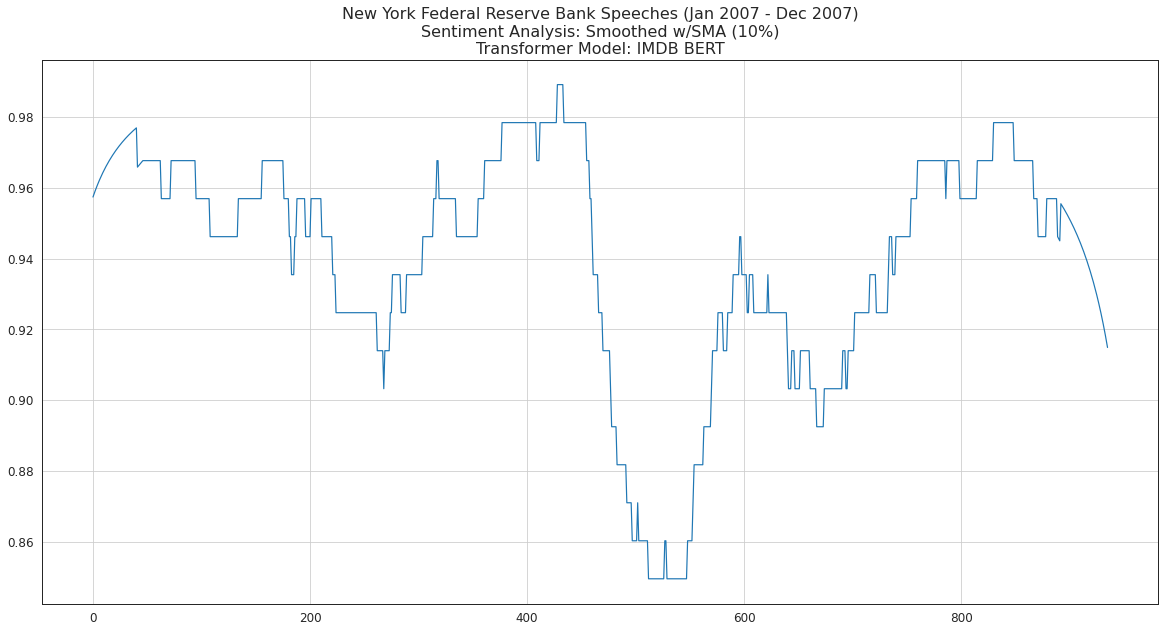

In [ ]:
# Verify Plausiblity of new Sentiment Values by Plotting

novel_indx = 0
corpus_text_str = corpus_texts_ls[novel_indx]
# amodel_str = 'huggingface' 
win_aper = 10

win_per = int((win_aper/100.)*global_vars.corpus_texts_dt[corpus_text_str][model_name].shape[0])
text_title_str = f"{global_vars.corpus_titles_dt[corpus_text_str][0]}\nSentiment Analysis: Smoothed w/SMA ({win_aper}%)\n{model_type} Model: {model_title}"
global_vars.corpus_texts_dt[corpus_text_str][model_name].rolling(win_per, center=True, min_periods=0).mean().plot(title=text_title_str)
plt.grid(True)
plt.show();

In [ ]:
global_vars.corpus_texts_dt[corpus_text_str].head()

,text_raw,text_clean,roberta15lg,huggingface,nlptown,yelp,hinglish,imdb2way
0,Timothy F Geithner: Developments in the global economy and implications for the United States Re...,timothy f geithner development in the global economy and implication for the unite state remark ...,0.993093,0.848771,3.286715,0,0,1
1,"It is a pleasure to be here at the Council on Foreign Relations, and to be here with Jerry Corri...",it be a pleasure to be here at the council on foreign relation and to be here with jerry corrigan,0.998892,0.999224,4.483013,4,0,1
2,"A few brief remarks about the global economy, both the real and financial dimensions, to provide...",a few brief remark about the global economy both the real and financial dimension to provide a b...,0.998106,0.994493,3.481419,2,0,1
3,2006 marked the fourth successive year of a global expansion that has been remarkable for its st...,mark the 4 successive year of a global expansion that have be remarkable for its strength for it...,0.998879,0.999847,4.495041,4,2,1
4,This period of broad-based growth in income has been supported by a number of important fundamen...,this period of broad base growth in income have be support by a numb of important fundamental force,0.998546,0.972342,1.259609,4,2,1


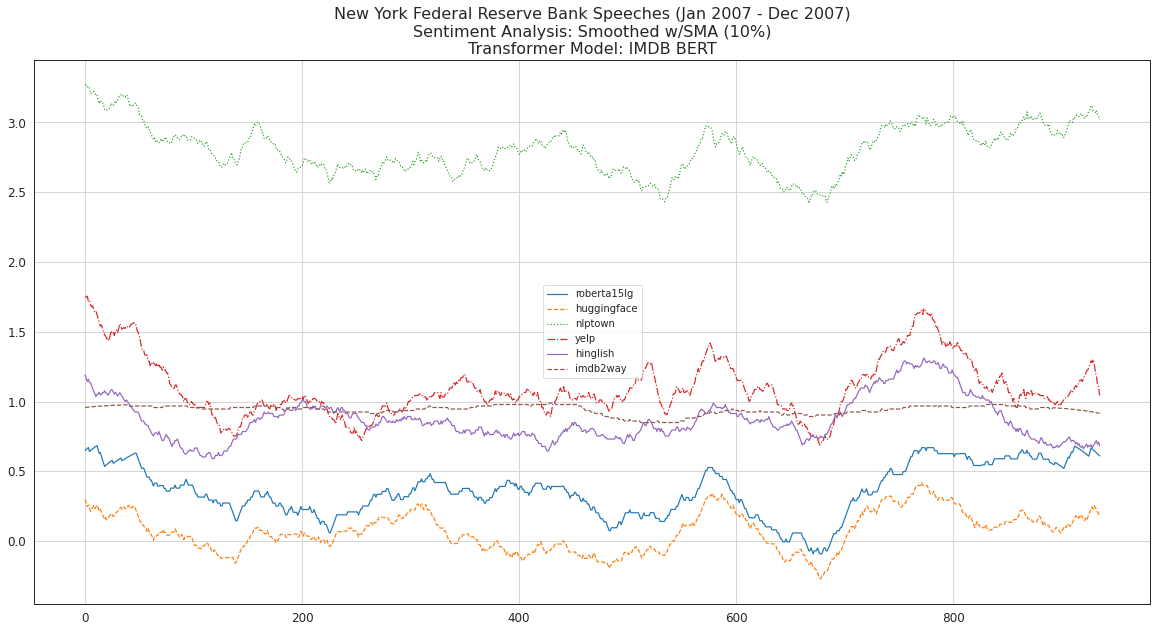

In [ ]:
# Plot all models

novel_indx = 0
corpus_text_str = corpus_texts_ls[novel_indx]
win_aper = 10

models_all_ls = list(global_vars.corpus_texts_dt[corpus_text_str].select_dtypes(include=[np.float,np.int]).columns)

win_per = int((win_aper/100.)*global_vars.corpus_texts_dt[corpus_text_str][model_name].shape[0])
text_title_str = f"{global_vars.corpus_titles_dt[corpus_text_str][0]}\nSentiment Analysis: Smoothed w/SMA ({win_aper}%)\n{model_type} Model: {model_title}"
global_vars.corpus_texts_dt[corpus_text_str][models_all_ls].rolling(win_per, center=True, min_periods=0).mean().plot(title=text_title_str)
plt.grid(True)
plt.show();

### **Save Checkpoint**

In [ ]:
# Verify in SentimentArcs Root Directory

model_current = 'imdb2way'

os.chdir(Path_to_SentimentArcs)

print('Currently in SentimentArcs root directory:')
!pwd

print(f'Saving Text_Type: {Corpus_Genre}')
print(f'     Corpus_Type: {Corpus_Type}')

# Verify Subdir to save Cleaned Texts and Texts into..

print(f'\nThese Text Titles:\n')
global_vars.corpus_texts_dt.keys()

print(f'\nTo This Subdirectory:\n')
PATH_SENTIMENT_RAW


# Save sentiment values to subdir_sentiments

# os.chdir(Path_to_SentimentArcs)

if Corpus_Type == 'new':
  save_filename = f'sentiment_raw_{Corpus_Genre}_{Corpus_Type}_corpus{Corpus_Number}_transformer_{model_current}.json'
else:
  save_filename = f'sentiment_raw_{Corpus_Genre}_{Corpus_Type}_transformer_{model_current}.json'

# Filter out all models but Current One 
current_model_dt = {}
cols_current_model_ls = []

for i, atext in enumerate(corpus_texts_ls):
  print(f'Saving {model_current} Model for all Texts')
  current_model_dt[atext] = pd.DataFrame(global_vars.corpus_texts_dt[atext][model_current])

write_dict_dfs(current_model_dt, out_file=save_filename, out_dir=f'{PATH_SENTIMENT_RAW}/')



Currently in SentimentArcs root directory:
/gdrive/MyDrive/sentimentarcs_notebooks
Saving Text_Type: finance
     Corpus_Type: new

These Text Titles:



dict_keys(['nyfederalreserve_speeches_2007'])


To This Subdirectory:



'./sentiment_raw/sentiment_raw_finance_new_corpus9/'

Saving file to: ./sentiment_raw/sentiment_raw_finance_new_corpus9//sentiment_raw_finance_new_corpus9_transformer_imdb2way.json


In [294]:
# Verify json file created

!ls -altr $PATH_SENTIMENT_RAW

total 1816
-rw------- 1 root root 472859 Apr 18 18:54 sentiment_raw_finance_new_corpus9_all_4syuzhetr.json
-rw------- 1 root root 747037 Apr 18 18:56 sentiment_raw_finance_new_corpus9_all_8sentimentr.json
-rw------- 1 root root 386964 Apr 18 19:06 sentiment_raw_finance_new_corpus9_transformer_roberta15lg.json
-rw------- 1 root root  63091 Apr 18 19:09 sentiment_raw_finance_new_corpus9_transformer_huggingface.json
-rw------- 1 root root  58514 Apr 18 19:30 sentiment_raw_finance_new_corpus9_transformer_nlptown.json
-rw------- 1 root root  40296 Apr 18 19:35 sentiment_raw_finance_new_corpus9_transformer_yelp.json
-rw------- 1 root root  44040 Apr 18 19:49 sentiment_raw_finance_new_corpus9_transformer_imdb2way.json
-rw------- 1 root root  44040 Apr 18 19:54 sentiment_raw_finance_new_corpus9_transformer_hinglish.json


## **T5Base 50k Finetuned IMDB Sentiment Extraction (2 cats)**

In [295]:
# T5 Base Model Fine-tuned on 50k IMDB 

tokenizer = AutoTokenizer.from_pretrained("mrm8488/t5-small-finetuned-imdb-sentiment")

amodel = None
del amodel
amodel = AutoModelWithLMHead.from_pretrained("mrm8488/t5-small-finetuned-imdb-sentiment")

sa_model = None
del sa_model

def sa_model(text):
  input_ids = tokenizer.encode(text + '</s>', return_tensors='pt')

  output = amodel.generate(input_ids=input_ids,
               max_length=2)
  
  dec = [tokenizer.decode(ids) for ids in output]
  label = dec[0]
  return label

sa_model("I dislike a lot that film")

Downloading:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.74k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/231M [00:00<?, ?B/s]

'<pad> negative'

In [296]:
# Test

text_str = "I love sunny days and happy puppy dogs."
res = sa_model(text_str)
# type(res)
print(f'res: [{res}]')


res: [<pad> positive]


In [297]:
def t5str2sentiment(t5_str):
  '''
  Given a T5 text string with sentiment and tags
  Return a -1,0,1 for negative,neutral/OOV,positive sentiment
  '''

  t5_sentiment1_str = t5_str.replace('<pad>','')
  t5_sentiment2_str = t5_sentiment1_str.replace('</s>','')
  t5_core_str = t5_sentiment2_str.strip().lower()
  # print(f't5_sentiment_raw_str: {t5_sentiment_raw_str}')
  # print(f't5_sentiment_str: {t5_sentiment_str}')
  # print(f't5_core_str: {t5_core_str}')
  if t5_core_str == 'positive':
    t5_sentiment_fl = 1
  elif t5_core_str == 'negative':
    t5_sentiment_fl = -1
  elif len(t5_core_str) > 0:
    # Out of Vocab (OOV) Word
    t5_sentiment_fl = 0
  elif len(t5_core_str) == 0:
    # Empty String
    t5_sentiment_fl = 0
  else:
    print(f'ERROR: Illegal value ts_sentiment_str: {t5_sentiment_str}')

  return int(t5_sentiment_fl)

# Test
asent_str = "I love the good and kind-hearted lovely lady who give me tasty cookies."
t5_response_str = sa_model(asent_str)
asentiment_int = t5str2sentiment(t5_response_str)
print(f'STRING: {asent_str}\nSENTIMENT: {asentiment_int}')

STRING: I love the good and kind-hearted lovely lady who give me tasty cookies.
SENTIMENT: 1


In [298]:
# Define Model and Test

model_title = 'T5 Base IMDB50K'
model_name = 't5imdb50k'
model_type = 'Transformer'

# Test Words
print(f'Testing WORD Sentiment')
print('--------------------------------------------------')
for i, aword_str in enumerate(global_vars.TEST_WORDS_LS):

  t5_sentiment_raw_str = t5str2sentiment(sa_model(aword_str))
  print(f'Word: {aword_str}\n    Sentiment: {t5_sentiment_raw_str}\n')

# Test Sentences
print(f'\nTesting SENTENCE Sentiment')
print('--------------------------------------------------')
for i, asent_str in enumerate(global_vars.TEST_SENTENCES_LS):

  t5_sentiment_raw_str = t5str2sentiment(sa_model(asent_str))
  print(f'Word: {asent_str}\n    Sentiment: {t5_sentiment_raw_str}\n')

Testing WORD Sentiment
--------------------------------------------------
Word: Love
    Sentiment: 1

Word: Hate
    Sentiment: -1

Word: bizarre
    Sentiment: 0

Word: strange
    Sentiment: -1

Word: furious
    Sentiment: 0

Word: elated
    Sentiment: -1

Word: curious
    Sentiment: 1

Word: beserk
    Sentiment: -1

Word: gambaro
    Sentiment: -1


Testing SENTENCE Sentiment
--------------------------------------------------
Word: I hate bad evil worthless Mondays.
    Sentiment: -1

Word: I love Paris in the springtime
    Sentiment: 1

Word: It was Wednesday.
    Sentiment: 1

Word: You are a disgusting pig - I hate you.
    Sentiment: -1

Word: What a delightfully funny and beautiful good man.
    Sentiment: 1

Word: That was it
    Sentiment: 0



In [299]:
# Verify saving results to correct model name

print(f'Saving results to Model: {model_name}\n')

sent_test_str = "I hate Mondays and bad doctors."
# sent_test_str = "You are a disgusting pig - I hate you."
print(f"SENTENCE: {sent_test_str}\nSENTIMENT: {t5str2sentiment(sa_model(sent_test_str))}")

Saving results to Model: t5imdb50k

SENTENCE: I hate Mondays and bad doctors.
SENTIMENT: -1


In [300]:
%%time

# NOTE:    10m45s @17:39 on 20220301 Colab Pro (1 Novel: cmieville_thecityandthecity: 10.1k sentences)
#          10m00s @17:48 on 20220301 Colab Pro (1 Novel: scollins_thehungergames1: 9.0k sentences)


#          15m21s @18:06 on 20220412 Colab Pro T4 (2 Novels: 1M, 1.1M)

#          15m57s @00:57 on 20220413 Colab Pro P100 (3 Novels, 1.2M, 1.3M, 1.7M)


for i, atext in enumerate(global_vars.corpus_texts_dt.keys()):
  models_ls = global_vars.corpus_texts_dt[atext].columns
  print(f"Processing #{i}: {atext}")
  if (Force_Recompute == True) or (model_name not in models_ls):
    global_vars.corpus_texts_dt[atext][model_name] = global_vars.corpus_texts_dt[atext]['text_clean'].apply(lambda x: t5str2sentiment(sa_model(x)))
    print(f'  [{model_name}] Sentiment Recomputed and Value Updated')
  else:
    print(f'  [{model_name}] Already in DataFrame and no Forced Recompute, so no update made')

Processing #0: nyfederalreserve_speeches_2007
  [t5imdb50k] Sentiment Recomputed and Value Updated
CPU times: user 58.9 s, sys: 229 ms, total: 59.1 s
Wall time: 1min 1s


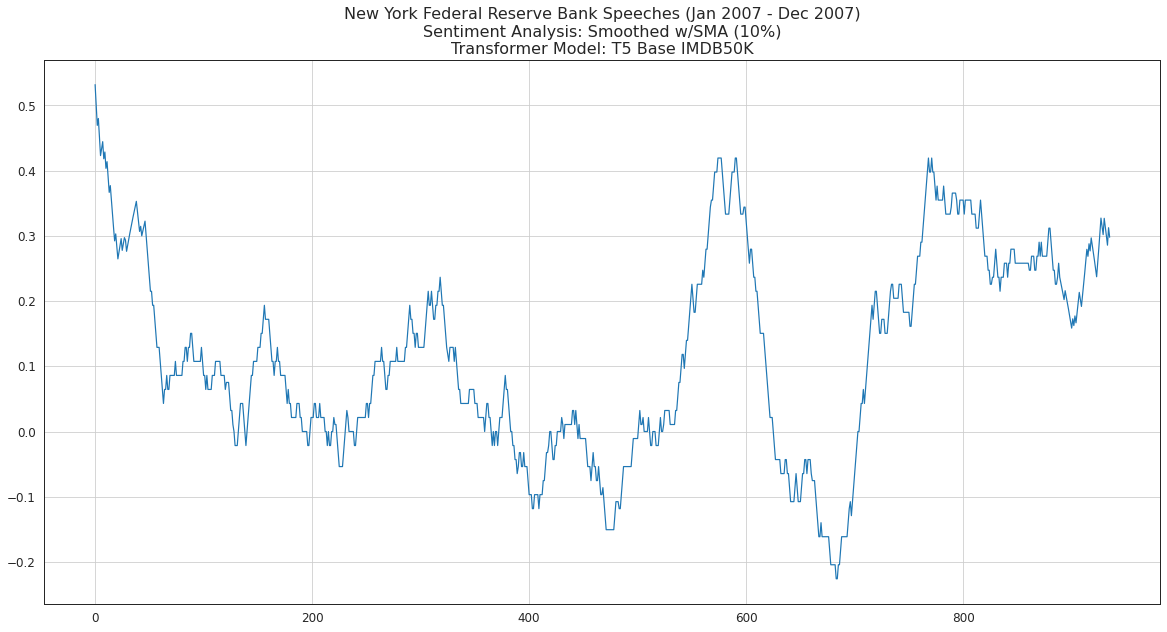

In [301]:
# Verify Plausiblity of new Sentiment Values by Plotting

novel_indx = 0
corpus_text_str = corpus_texts_ls[novel_indx]
# amodel_str = 'huggingface' 
win_aper = 10

win_per = int((win_aper/100.)*global_vars.corpus_texts_dt[corpus_text_str][model_name].shape[0])
text_title_str = f"{global_vars.corpus_titles_dt[corpus_text_str][0]}\nSentiment Analysis: Smoothed w/SMA ({win_aper}%)\n{model_type} Model: {model_title}"
global_vars.corpus_texts_dt[corpus_text_str][model_name].rolling(win_per, center=True, min_periods=0).mean().plot(title=text_title_str)
plt.grid(True)
plt.show();

In [302]:
global_vars.corpus_texts_dt[corpus_text_str].head()

,text_raw,text_clean,roberta15lg,huggingface,nlptown,yelp,hinglish,imdb2way,t5imdb50k
0,Timothy F Geithner: Developments in the global economy and implications for the United States Re...,timothy f geithner development in the global economy and implication for the unite state remark ...,0.993093,0.848771,3.286715,0,0,1,1
1,"It is a pleasure to be here at the Council on Foreign Relations, and to be here with Jerry Corri...",it be a pleasure to be here at the council on foreign relation and to be here with jerry corrigan,0.998892,0.999224,4.483013,4,0,1,1
2,"A few brief remarks about the global economy, both the real and financial dimensions, to provide...",a few brief remark about the global economy both the real and financial dimension to provide a b...,0.998106,0.994493,3.481419,2,0,1,1
3,2006 marked the fourth successive year of a global expansion that has been remarkable for its st...,mark the 4 successive year of a global expansion that have be remarkable for its strength for it...,0.998879,0.999847,4.495041,4,2,1,1
4,This period of broad-based growth in income has been supported by a number of important fundamen...,this period of broad base growth in income have be support by a numb of important fundamental force,0.998546,0.972342,1.259609,4,2,1,1


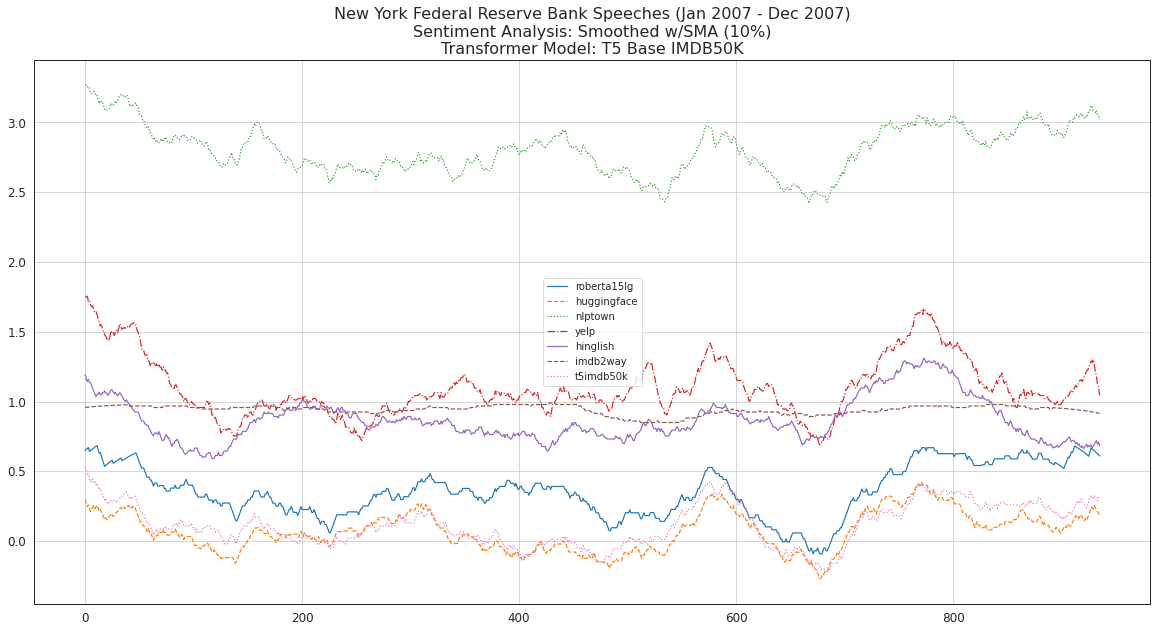

In [303]:
# Plot all models

novel_indx = 0
corpus_text_str = corpus_texts_ls[novel_indx]
win_aper = 10

models_all_ls = list(global_vars.corpus_texts_dt[corpus_text_str].select_dtypes(include=[np.float,np.int]).columns)

win_per = int((win_aper/100.)*global_vars.corpus_texts_dt[corpus_text_str][model_name].shape[0])
text_title_str = f"{global_vars.corpus_titles_dt[corpus_text_str][0]}\nSentiment Analysis: Smoothed w/SMA ({win_aper}%)\n{model_type} Model: {model_title}"
global_vars.corpus_texts_dt[corpus_text_str][models_all_ls].rolling(win_per, center=True, min_periods=0).mean().plot(title=text_title_str)
plt.grid(True)
plt.show();

### **Save Checkpoint**

In [304]:
# Verify in SentimentArcs Root Directory

model_current = 't5imdb50k'

os.chdir(Path_to_SentimentArcs)

print('Currently in SentimentArcs root directory:')
!pwd

print(f'Saving Text_Type: {Corpus_Genre}')
print(f'     Corpus_Type: {Corpus_Type}')

# Verify Subdir to save Cleaned Texts and Texts into..

print(f'\nThese Text Titles:\n')
global_vars.corpus_texts_dt.keys()

print(f'\nTo This Subdirectory:\n')
PATH_SENTIMENT_RAW


# Save sentiment values to subdir_sentiments

# os.chdir(Path_to_SentimentArcs)

if Corpus_Type == 'new':
  save_filename = f'sentiment_raw_{Corpus_Genre}_{Corpus_Type}_corpus{Corpus_Number}_transformer_{model_current}.json'
else:
  save_filename = f'sentiment_raw_{Corpus_Genre}_{Corpus_Type}_transformer_{model_current}.json'

# Filter out all models but Current One 
current_model_dt = {}
cols_current_model_ls = []

for i, atext in enumerate(corpus_texts_ls):
  print(f'Saving {model_current} Model for all Texts')
  current_model_dt[atext] = pd.DataFrame(global_vars.corpus_texts_dt[atext][model_current])

write_dict_dfs(current_model_dt, out_file=save_filename, out_dir=f'{PATH_SENTIMENT_RAW}/')



Currently in SentimentArcs root directory:
/gdrive/MyDrive/sentimentarcs_notebooks
Saving Text_Type: finance
     Corpus_Type: new

These Text Titles:



dict_keys(['nyfederalreserve_speeches_2007'])


To This Subdirectory:



'./sentiment_raw/sentiment_raw_finance_new_corpus9/'

Saving t5imdb50k Model for all Texts
Saving file to: ./sentiment_raw/sentiment_raw_finance_new_corpus9//sentiment_raw_finance_new_corpus9_transformer_t5imdb50k.json


In [305]:
# Verify json file created

!ls -altr $PATH_SENTIMENT_RAW

total 1861
-rw------- 1 root root 472859 Apr 18 18:54 sentiment_raw_finance_new_corpus9_all_4syuzhetr.json
-rw------- 1 root root 747037 Apr 18 18:56 sentiment_raw_finance_new_corpus9_all_8sentimentr.json
-rw------- 1 root root 386964 Apr 18 19:06 sentiment_raw_finance_new_corpus9_transformer_roberta15lg.json
-rw------- 1 root root  63091 Apr 18 19:09 sentiment_raw_finance_new_corpus9_transformer_huggingface.json
-rw------- 1 root root  58514 Apr 18 19:30 sentiment_raw_finance_new_corpus9_transformer_nlptown.json
-rw------- 1 root root  40296 Apr 18 19:35 sentiment_raw_finance_new_corpus9_transformer_yelp.json
-rw------- 1 root root  44040 Apr 18 19:49 sentiment_raw_finance_new_corpus9_transformer_imdb2way.json
-rw------- 1 root root  44040 Apr 18 19:54 sentiment_raw_finance_new_corpus9_transformer_hinglish.json
-rw------- 1 root root  45381 Apr 18 20:02 sentiment_raw_finance_new_corpus9_transformer_t5imdb50k.json


## **RoBERTa XLM Twitter 8 Multilingual (3 cats)**

In [314]:
# RoBERTa XLM Fine-tuend on 8 Multilingual Tweets

model_path = "cardiffnlp/twitter-xlm-roberta-base-sentiment"

sa_model = None
del sa_model
sa_model = pipeline("sentiment-analysis", model=model_path, tokenizer=model_path)

# Test
sa_model("T'estimo!")

[{'label': 'Positive', 'score': 0.6600587964057922}]

In [315]:
# from transformers.utils.dummy_pt_objects import SQUEEZEBERT_PRETRAINED_MODEL_ARCHIVE_LIST

# Define Model and Test

model_title = 'RoBERTa XLM Twitter 8Lang'
model_name = 'robertaxml8lang'
model_type = 'Transformer'

# Test Words
print(f'Testing WORD Sentiment')
print('--------------------------------------------------')
for i, aword_str in enumerate(global_vars.TEST_WORDS_LS):

  # word_sentiment_fl = SQUEEZEBERT_PRETRAINED_MODEL_ARCHIVE_LIST(aword_str)
  word_sentiment_fl = sa_model(aword_str)
  print(f'Word: {aword_str}\n    {word_sentiment_fl}\n')

# Test Sentences
print(f'\nTesting SENTENCE Sentiment')
print('--------------------------------------------------')
for i, asent_str in enumerate(global_vars.TEST_SENTENCES_LS):

  # sent_sentiment_fl = labelscore2fl(sa_model(asent_str), sa_model='robertaxml8lang')
  sent_sentiment_fl = labelscore2fl(sa_model(asent_str), sa_model='robertaxml8lang')
  print(f'Sentence: {asent_str}\n    {sent_sentiment_fl:.3f}\n')

Testing WORD Sentiment
--------------------------------------------------
Word: Love
    [{'label': 'Positive', 'score': 0.3964223563671112}]

Word: Hate
    [{'label': 'Negative', 'score': 0.5858043432235718}]

Word: bizarre
    [{'label': 'Negative', 'score': 0.4368371367454529}]

Word: strange
    [{'label': 'Negative', 'score': 0.37017685174942017}]

Word: furious
    [{'label': 'Negative', 'score': 0.4249660074710846}]

Word: elated
    [{'label': 'Neutral', 'score': 0.38555991649627686}]

Word: curious
    [{'label': 'Neutral', 'score': 0.49868229031562805}]

Word: beserk
    [{'label': 'Negative', 'score': 0.36750832200050354}]

Word: gambaro
    [{'label': 'Neutral', 'score': 0.3720065653324127}]


Testing SENTENCE Sentiment
--------------------------------------------------
Sentence: I hate bad evil worthless Mondays.
    -0.955

Sentence: I love Paris in the springtime
    0.846

Sentence: It was Wednesday.
    0.000

Sentence: You are a disgusting pig - I hate you.
    -0.96

In [316]:
%%time

# NOTE:   9m05s @16:40 on 20220301 Colab Pro P100 (1 Novel: cmieville_thecityandthecity)
#         ~8m07s @16:49 on 20220201 Colab Pro P100 (1 Novel: scollins_thehungergames1)

#          30m36s @18:33 on 20220412 Colab Pro T4 (2 Novels: 1M, 1.1M)

#          28m29s @01:16 on 20220413 Colab Pro P100 (3 Novels, 1.2M, 1.3M, 1.7M)


for i, atext in enumerate(global_vars.corpus_texts_dt.keys()):
  models_ls = global_vars.corpus_texts_dt[atext].columns
  print(f"Processing #{i}: {atext}")
  if (Force_Recompute == True) or (model_name not in models_ls):
    global_vars.corpus_texts_dt[atext][model_name] = global_vars.corpus_texts_dt[atext]['text_clean'].apply(lambda x: labelscore2fl(sa_model(x), sa_model='robertaxml8lang'))
    print(f'  [{model_name}] Sentiment Recomputed and Value Updated')
  else:
    print(f'  [{model_name}] Already in DataFrame and no Forced Recompute, so no update made')

Processing #0: nyfederalreserve_speeches_2007
  [robertaxml8lang] Sentiment Recomputed and Value Updated
CPU times: user 1min 58s, sys: 395 ms, total: 1min 59s
Wall time: 2min


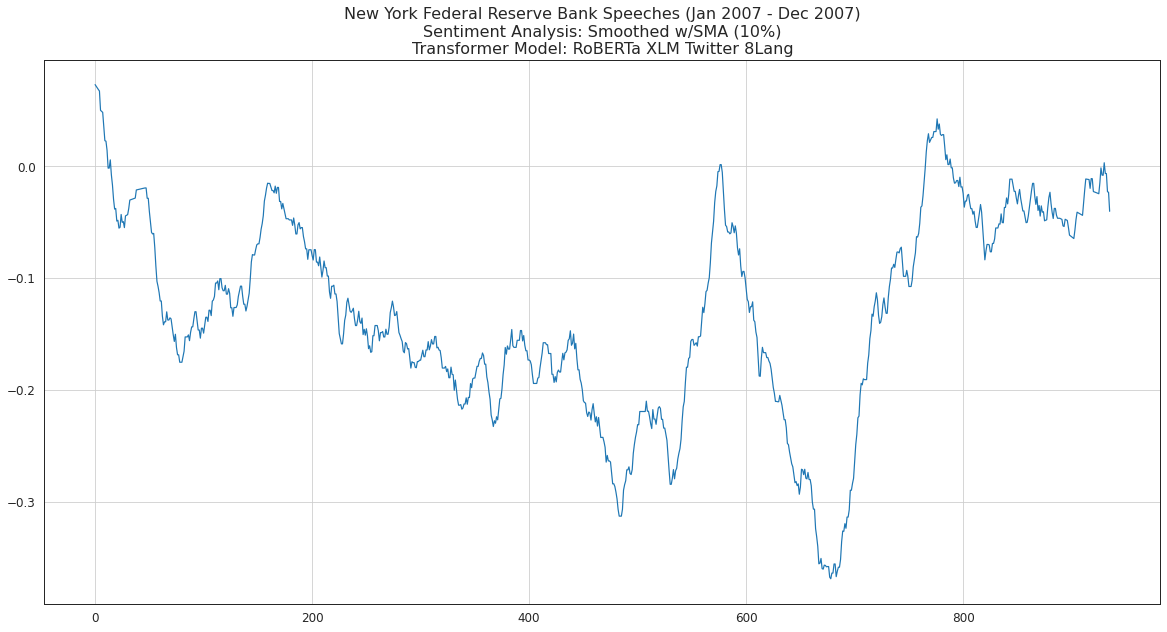

In [317]:
# Verify Plausiblity of new Sentiment Values by Plotting

novel_indx = 0
corpus_text_str = corpus_texts_ls[novel_indx] 
win_aper = 10

win_per = int((win_aper/100.)*global_vars.corpus_texts_dt[corpus_text_str][model_name].shape[0])
text_title_str = f"{global_vars.corpus_titles_dt[corpus_text_str][0]}\nSentiment Analysis: Smoothed w/SMA ({win_aper}%)\n{model_type} Model: {model_title}"
global_vars.corpus_texts_dt[corpus_text_str][model_name].rolling(win_per, center=True, min_periods=0).mean().plot(title=text_title_str)
plt.grid(True)
plt.show();

In [318]:
global_vars.corpus_texts_dt[corpus_text_str].head()

,text_raw,text_clean,roberta15lg,huggingface,nlptown,yelp,hinglish,imdb2way,t5imdb50k,robertaxml8lang
0,Timothy F Geithner: Developments in the global economy and implications for the United States Re...,timothy f geithner development in the global economy and implication for the unite state remark ...,0.993093,0.848771,3.286715,0,0,1,1,0.000000
1,"It is a pleasure to be here at the Council on Foreign Relations, and to be here with Jerry Corri...",it be a pleasure to be here at the council on foreign relation and to be here with jerry corrigan,0.998892,0.999224,4.483013,4,0,1,1,0.858362
2,"A few brief remarks about the global economy, both the real and financial dimensions, to provide...",a few brief remark about the global economy both the real and financial dimension to provide a b...,0.998106,0.994493,3.481419,2,0,1,1,0.000000
3,2006 marked the fourth successive year of a global expansion that has been remarkable for its st...,mark the 4 successive year of a global expansion that have be remarkable for its strength for it...,0.998879,0.999847,4.495041,4,2,1,1,0.599996
4,This period of broad-based growth in income has been supported by a number of important fundamen...,this period of broad base growth in income have be support by a numb of important fundamental force,0.998546,0.972342,1.259609,4,2,1,1,0.000000


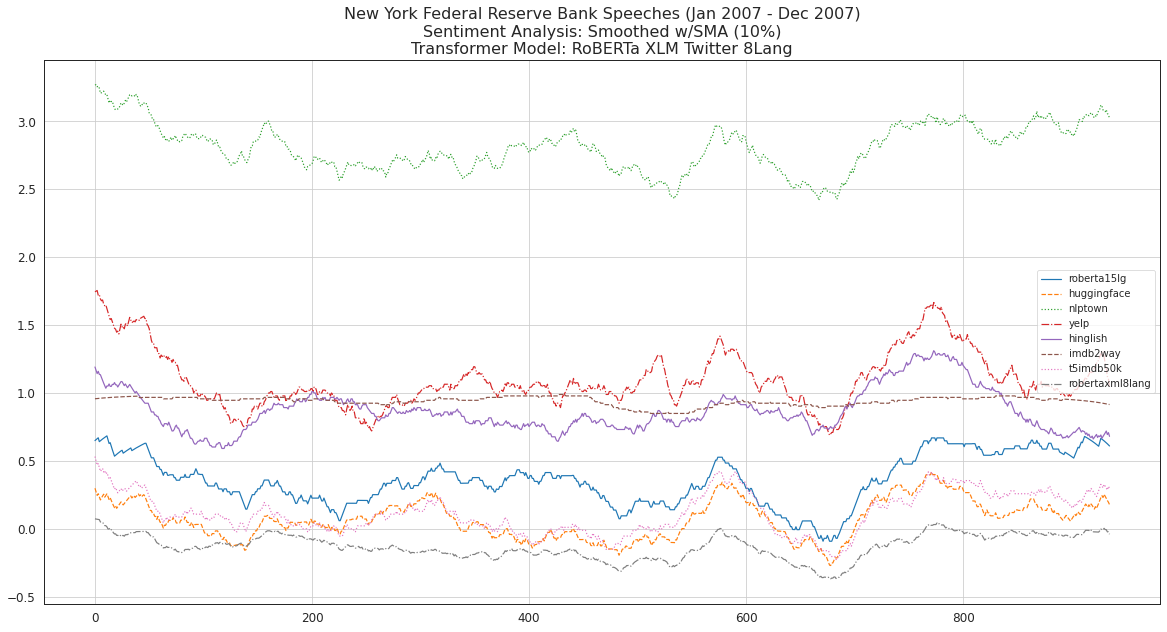

In [319]:
# Plot all models

novel_indx = 0
corpus_text_str = corpus_texts_ls[novel_indx]
win_aper = 10

models_all_ls = list(global_vars.corpus_texts_dt[corpus_text_str].select_dtypes(include=[np.float,np.int]).columns)

win_per = int((win_aper/100.)*global_vars.corpus_texts_dt[corpus_text_str][model_name].shape[0])
text_title_str = f"{global_vars.corpus_titles_dt[corpus_text_str][0]}\nSentiment Analysis: Smoothed w/SMA ({win_aper}%)\n{model_type} Model: {model_title}"
global_vars.corpus_texts_dt[corpus_text_str][models_all_ls].rolling(win_per, center=True, min_periods=0).mean().plot(title=text_title_str)
plt.grid(True)
plt.show();

### **Save Checkpoint**

In [320]:
# Verify in SentimentArcs Root Directory

model_current = 'robertaxml8lang'

os.chdir(Path_to_SentimentArcs)

print('Currently in SentimentArcs root directory:')
!pwd

print(f'Saving Text_Type: {Corpus_Genre}')
print(f'     Corpus_Type: {Corpus_Type}')

# Verify Subdir to save Cleaned Texts and Texts into..

print(f'\nThese Text Titles:\n')
global_vars.corpus_texts_dt.keys()

print(f'\nTo This Subdirectory:\n')
PATH_SENTIMENT_RAW


# Save sentiment values to subdir_sentiments

# os.chdir(Path_to_SentimentArcs)

if Corpus_Type == 'new':
  save_filename = f'sentiment_raw_{Corpus_Genre}_{Corpus_Type}_corpus{Corpus_Number}_transformer_{model_current}.json'
else:
  save_filename = f'sentiment_raw_{Corpus_Genre}_{Corpus_Type}_transformer_{model_current}.json'

# Filter out all models but Current One 
current_model_dt = {}
cols_current_model_ls = []

for i, atext in enumerate(corpus_texts_ls):
  print(f'Saving {model_current} Model for all Texts')
  current_model_dt[atext] = pd.DataFrame(global_vars.corpus_texts_dt[atext][model_current])

write_dict_dfs(current_model_dt, out_file=save_filename, out_dir=f'{PATH_SENTIMENT_RAW}/')



Currently in SentimentArcs root directory:
/gdrive/MyDrive/sentimentarcs_notebooks
Saving Text_Type: finance
     Corpus_Type: new

These Text Titles:



dict_keys(['nyfederalreserve_speeches_2007'])


To This Subdirectory:



'./sentiment_raw/sentiment_raw_finance_new_corpus9/'

Saving robertaxml8lang Model for all Texts
Saving file to: ./sentiment_raw/sentiment_raw_finance_new_corpus9//sentiment_raw_finance_new_corpus9_transformer_robertaxml8lang.json


In [321]:
# Verify json file created

!ls -altr $PATH_SENTIMENT_RAW

total 1920
-rw------- 1 root root 472859 Apr 18 18:54 sentiment_raw_finance_new_corpus9_all_4syuzhetr.json
-rw------- 1 root root 747037 Apr 18 18:56 sentiment_raw_finance_new_corpus9_all_8sentimentr.json
-rw------- 1 root root 386964 Apr 18 19:06 sentiment_raw_finance_new_corpus9_transformer_roberta15lg.json
-rw------- 1 root root  63091 Apr 18 19:09 sentiment_raw_finance_new_corpus9_transformer_huggingface.json
-rw------- 1 root root  58514 Apr 18 19:30 sentiment_raw_finance_new_corpus9_transformer_nlptown.json
-rw------- 1 root root  40296 Apr 18 19:35 sentiment_raw_finance_new_corpus9_transformer_yelp.json
-rw------- 1 root root  44040 Apr 18 19:49 sentiment_raw_finance_new_corpus9_transformer_imdb2way.json
-rw------- 1 root root  44040 Apr 18 19:54 sentiment_raw_finance_new_corpus9_transformer_hinglish.json
-rw------- 1 root root  45381 Apr 18 20:02 sentiment_raw_finance_new_corpus9_transformer_t5imdb50k.json
-rw------- 1 root root  60855 Apr 18 20:08 sentiment_raw_finance_new_cor

## **FinBERT Tone (3 cats)**

In [323]:
# FinBERT Tone

finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone',num_labels=3)
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')

sa_model = pipeline("sentiment-analysis", model=finbert, tokenizer=tokenizer)

Downloading:   0%|          | 0.00/533 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/419M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/221k [00:00<?, ?B/s]

In [324]:
# Test

fin_sentences_ls = ["there is a shortage of capital, and we need extra financing",  
             "growth is strong and we have plenty of liquidity", 
             "there are doubts about our finances", 
             "profits are flat"]
results_ls = sa_model(fin_sentences_ls)
print(results_ls)

[{'label': 'negative', 'score': 0.9966173768043518}, {'label': 'positive', 'score': 1.0}, {'label': 'negative', 'score': 0.9999710321426392}, {'label': 'neutral', 'score': 0.9889442920684814}]


In [325]:
# Test

fin_sentences_ls = ["I love sunny days and happy puppy dogs.",
                    "The market crashed and all indicators were down",
                    "Strong institutional buying resulted in rising share prices and a bull market"]
                  
results_ls = sa_model(fin_sentences_ls)

def dtlabelscore2fl(adict):
  """
  Given a dictionary of 2 keys ['label']=[positive|negative|neutral] and ['score']=[0.0 to +1.0]
  Return an adjusted sentiment score [-1.0 to +1.0]
  """
  adj_sentiment = 0.
  apolarity = adict['label']
  asentiment = adict['score']
  if apolarity == 'negative':
    adj_sentiment = -1. * float(asentiment)
  elif apolarity == 'positive':
    adj_sentiment = float(asentiment)
  else:
    adj_sentiment = 0.

  return adj_sentiment

for i, asent_dt in enumerate(results_ls):
  asentence = fin_sentences_ls[i]
  raw_results = results_ls[i]
  adj_senti = dtlabelscore2fl(asent_dt)
  # print(f'SENTENCE:\n    {asentence}\n    apolarity: {apolarity}\n    asentiment: {asentiment}\n    adj_sentiment: {adj_sentiment}') 
  print(f'SENTENCE:\n    {asentence}\n    raw_results: {raw_results}\n    adj_sentiment: {adj_senti}')


SENTENCE:
    I love sunny days and happy puppy dogs.
    raw_results: {'label': 'neutral', 'score': 0.9958643913269043}
    adj_sentiment: 0.0
SENTENCE:
    The market crashed and all indicators were down
    raw_results: {'label': 'negative', 'score': 0.9999221563339233}
    adj_sentiment: -0.9999221563339233
SENTENCE:
    Strong institutional buying resulted in rising share prices and a bull market
    raw_results: {'label': 'positive', 'score': 1.0}
    adj_sentiment: 1.0


In [326]:
# Define Model and Test

model_title = 'FinBERT Tone'
model_name = 'finberttone'
model_type = 'Transformer'

# Test Emoji
emoji_str = "We are very happy to show you the 🤗 Transformers library."
raw_sentiment = sa_model(emoji_str)[0]
adj_sentiment = dtlabelscore2fl(raw_sentiment)
print(f'Emoji String: {emoji_str}\n    Raw Sentiment: {raw_sentiment}\n    Adj Sentiment: {adj_sentiment}\n')
print('\n\n')

# Test Words
print(f'Testing WORD Sentiment')
print('--------------------------------------------------')
for i, aword_str in enumerate(global_vars.TEST_WORDS_LS):

  raw_sentiment = sa_model(aword_str)[0]
  adj_sentiment = dtlabelscore2fl(raw_sentiment)
  print(f'Word String: {aword_str}\n    Raw Sentiment: {raw_sentiment}\n    Adj Sentiment: {adj_sentiment}\n')
  # print('\n\n')
  # print(f'Word: {aword_str}\n    Raw Sentiment: {adj_sentiment} out of {sentiment_scale} (prob={sentiment_prob:.3f})\n')

# Test Sentences
print(f'\nTesting SENTENCE Sentiment')
print('--------------------------------------------------')
for i, asent_str in enumerate(global_vars.TEST_SENTENCES_LS):

  raw_sentiment = sa_model(asent_str)[0]
  adj_sentiment = dtlabelscore2fl(raw_sentiment)
  print(f'Sentence String: {asent_str}\n    Raw Sentiment: {raw_sentiment}\n    Adj Sentiment: {adj_sentiment}\n')
  # print(f'Sentence: {asent_str}\n    Sentiment: {sentiment_val} out of {sentiment_scale} (prob={sentiment_prob:.3f})\n')


Emoji String: We are very happy to show you the 🤗 Transformers library.
    Raw Sentiment: {'label': 'positive', 'score': 0.9999575614929199}
    Adj Sentiment: 0.9999575614929199




Testing WORD Sentiment
--------------------------------------------------
Word String: Love
    Raw Sentiment: {'label': 'neutral', 'score': 0.9546787142753601}
    Adj Sentiment: 0.0

Word String: Hate
    Raw Sentiment: {'label': 'neutral', 'score': 0.9850627183914185}
    Adj Sentiment: 0.0

Word String: bizarre
    Raw Sentiment: {'label': 'neutral', 'score': 0.9916641712188721}
    Adj Sentiment: 0.0

Word String: strange
    Raw Sentiment: {'label': 'neutral', 'score': 0.9986492991447449}
    Adj Sentiment: 0.0

Word String: furious
    Raw Sentiment: {'label': 'neutral', 'score': 0.8644612431526184}
    Adj Sentiment: 0.0

Word String: elated
    Raw Sentiment: {'label': 'neutral', 'score': 0.9996832609176636}
    Adj Sentiment: 0.0

Word String: curious
    Raw Sentiment: {'label': 'neutral', 'sco

In [327]:
%%time

# NOTE:    16m22s @21:56 on 20220301 Colab Pro T4 (2 Novels: 1M, 1.1M)

#          28m01s @01:48 on 20220413 Colab Pro P100 (3 Novels, 1.2M, 1.3M, 1.7M)



for i, atext in enumerate(global_vars.corpus_texts_dt.keys()):
  models_ls = global_vars.corpus_texts_dt[atext].columns
  print(f"Processing #{i}: {atext}")
  if (Force_Recompute == True) or (model_name not in models_ls):
    # corpus_texts_dt[atext][model_name] = corpus_texts_dt[atext]['text_clean'].apply(lambda x: logitstensor2sentiment(sa_yelp(**tokenizer(x, return_tensors='pt')))[0])
    global_vars.corpus_texts_dt[atext][model_name] = global_vars.corpus_texts_dt[atext]['text_clean'].apply(lambda x: dtlabelscore2fl(sa_model(x)[0]))
    print(f'  [{model_name}] Sentiment Recomputed and Value Updated')
  else:
    print(f'  [{model_name}] Already in DataFrame and no Forced Recompute, so no update made')


Processing #0: nyfederalreserve_speeches_2007
  [finberttone] Sentiment Recomputed and Value Updated
CPU times: user 1min 47s, sys: 267 ms, total: 1min 48s
Wall time: 1min 47s


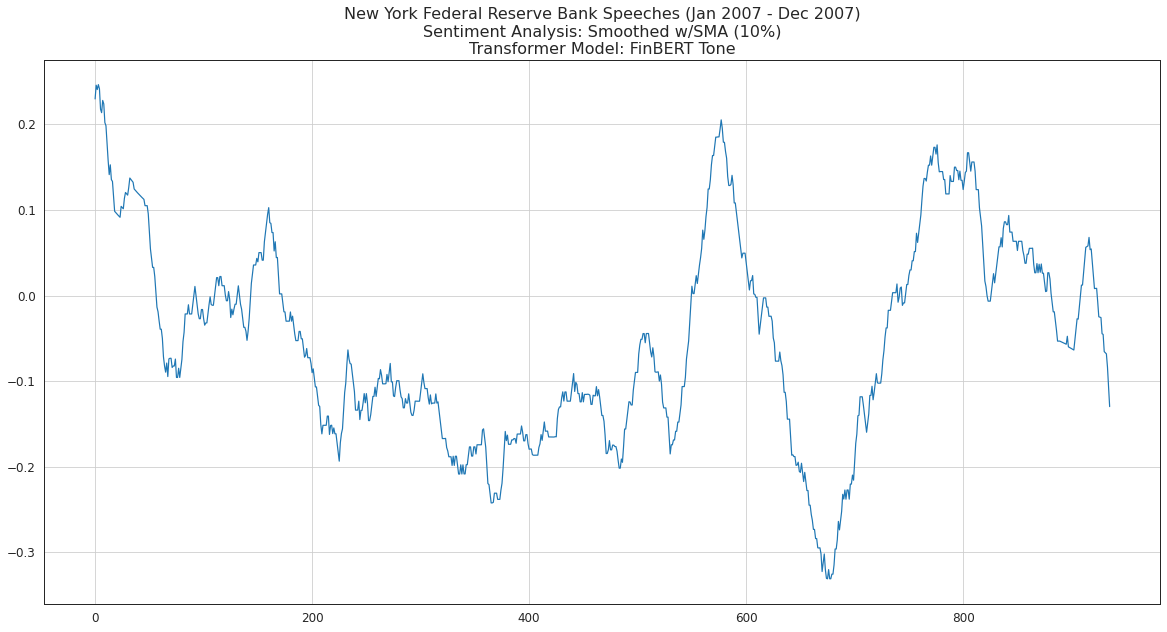

In [328]:
# Verify Plausiblity of new Sentiment Values by Plotting

novel_indx = 0
corpus_text_str = corpus_texts_ls[novel_indx]
# amodel_str = 'huggingface' 
win_aper = 10

win_per = int((win_aper/100.)*global_vars.corpus_texts_dt[corpus_text_str][model_name].shape[0])
text_title_str = f"{global_vars.corpus_titles_dt[corpus_text_str][0]}\nSentiment Analysis: Smoothed w/SMA ({win_aper}%)\n{model_type} Model: {model_title}"
global_vars.corpus_texts_dt[corpus_text_str][model_name].rolling(win_per, center=True, min_periods=0).mean().plot(title=text_title_str)
plt.grid(True)
plt.show();

In [329]:
global_vars.corpus_texts_dt[corpus_text_str].head()

,text_raw,text_clean,roberta15lg,huggingface,nlptown,yelp,hinglish,imdb2way,t5imdb50k,robertaxml8lang,finberttone
0,Timothy F Geithner: Developments in the global economy and implications for the United States Re...,timothy f geithner development in the global economy and implication for the unite state remark ...,0.993093,0.848771,3.286715,0,0,1,1,0.000000,0.000000
1,"It is a pleasure to be here at the Council on Foreign Relations, and to be here with Jerry Corri...",it be a pleasure to be here at the council on foreign relation and to be here with jerry corrigan,0.998892,0.999224,4.483013,4,0,1,1,0.858362,0.000000
2,"A few brief remarks about the global economy, both the real and financial dimensions, to provide...",a few brief remark about the global economy both the real and financial dimension to provide a b...,0.998106,0.994493,3.481419,2,0,1,1,0.000000,0.000000
3,2006 marked the fourth successive year of a global expansion that has been remarkable for its st...,mark the 4 successive year of a global expansion that have be remarkable for its strength for it...,0.998879,0.999847,4.495041,4,2,1,1,0.599996,1.000000
4,This period of broad-based growth in income has been supported by a number of important fundamen...,this period of broad base growth in income have be support by a numb of important fundamental force,0.998546,0.972342,1.259609,4,2,1,1,0.000000,0.999972


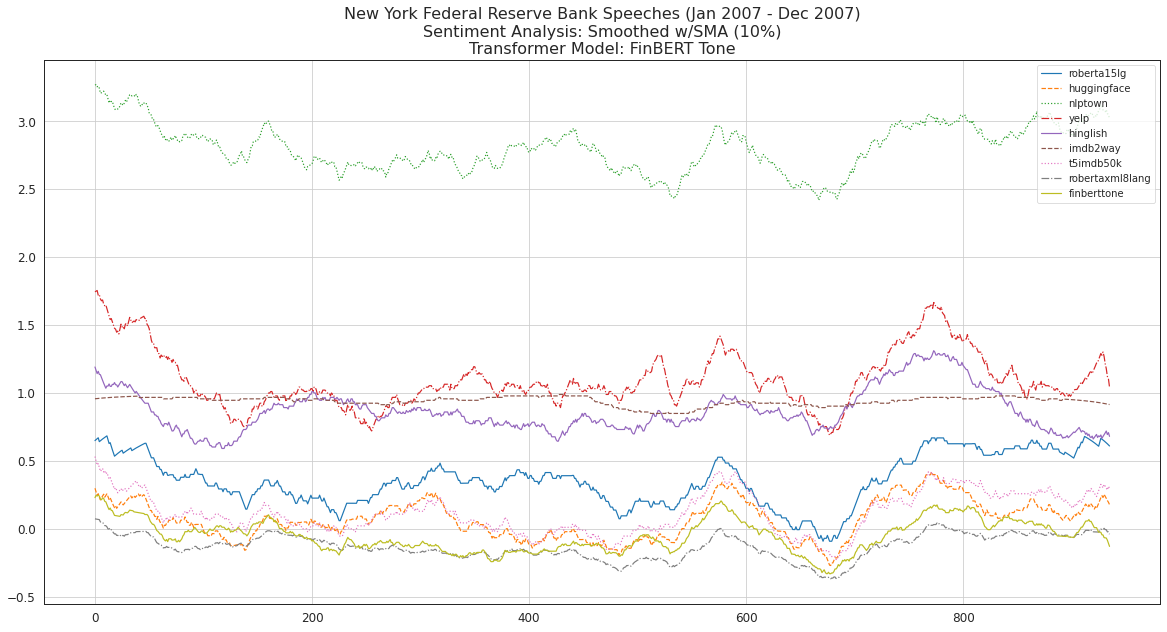

In [330]:
# Plot all models

novel_indx = 0
corpus_text_str = corpus_texts_ls[novel_indx]
win_aper = 10

models_all_ls = list(global_vars.corpus_texts_dt[corpus_text_str].select_dtypes(include=[np.float,np.int]).columns)

win_per = int((win_aper/100.)*global_vars.corpus_texts_dt[corpus_text_str][model_name].shape[0])
text_title_str = f"{global_vars.corpus_titles_dt[corpus_text_str][0]}\nSentiment Analysis: Smoothed w/SMA ({win_aper}%)\n{model_type} Model: {model_title}"
global_vars.corpus_texts_dt[corpus_text_str][models_all_ls].rolling(win_per, center=True, min_periods=0).mean().plot(title=text_title_str)
plt.grid(True)
plt.show();

### **Save Checkpoint**

In [331]:
# Verify in SentimentArcs Root Directory

model_current = 'finberttone'

os.chdir(Path_to_SentimentArcs)

print('Currently in SentimentArcs root directory:')
!pwd

print(f'Saving Text_Type: {Corpus_Genre}')
print(f'     Corpus_Type: {Corpus_Type}')

# Verify Subdir to save Cleaned Texts and Texts into..

print(f'\nThese Text Titles:\n')
global_vars.corpus_texts_dt.keys()

print(f'\nTo This Subdirectory:\n')
PATH_SENTIMENT_RAW


# Save sentiment values to subdir_sentiments

# os.chdir(Path_to_SentimentArcs)

if Corpus_Type == 'new':
  save_filename = f'sentiment_raw_{Corpus_Genre}_{Corpus_Type}_corpus{Corpus_Number}_transformer_{model_current}.json'
else:
  save_filename = f'sentiment_raw_{Corpus_Genre}_{Corpus_Type}_transformer_{model_current}.json'

# Filter out all models but Current One 
current_model_dt = {}
cols_current_model_ls = []

for i, atext in enumerate(corpus_texts_ls):
  print(f'Saving {model_current} Model for all Texts')
  current_model_dt[atext] = pd.DataFrame(global_vars.corpus_texts_dt[atext][model_current])

write_dict_dfs(current_model_dt, out_file=save_filename, out_dir=f'{PATH_SENTIMENT_RAW}/')



Currently in SentimentArcs root directory:
/gdrive/MyDrive/sentimentarcs_notebooks
Saving Text_Type: finance
     Corpus_Type: new

These Text Titles:



dict_keys(['nyfederalreserve_speeches_2007'])


To This Subdirectory:



'./sentiment_raw/sentiment_raw_finance_new_corpus9/'

Saving finberttone Model for all Texts
Saving file to: ./sentiment_raw/sentiment_raw_finance_new_corpus9//sentiment_raw_finance_new_corpus9_transformer_finberttone.json


In [332]:
# Verify json file created

!ls -altr $PATH_SENTIMENT_RAW

total 1975
-rw------- 1 root root 472859 Apr 18 18:54 sentiment_raw_finance_new_corpus9_all_4syuzhetr.json
-rw------- 1 root root 747037 Apr 18 18:56 sentiment_raw_finance_new_corpus9_all_8sentimentr.json
-rw------- 1 root root 386964 Apr 18 19:06 sentiment_raw_finance_new_corpus9_transformer_roberta15lg.json
-rw------- 1 root root  63091 Apr 18 19:09 sentiment_raw_finance_new_corpus9_transformer_huggingface.json
-rw------- 1 root root  58514 Apr 18 19:30 sentiment_raw_finance_new_corpus9_transformer_nlptown.json
-rw------- 1 root root  40296 Apr 18 19:35 sentiment_raw_finance_new_corpus9_transformer_yelp.json
-rw------- 1 root root  44040 Apr 18 19:49 sentiment_raw_finance_new_corpus9_transformer_imdb2way.json
-rw------- 1 root root  44040 Apr 18 19:54 sentiment_raw_finance_new_corpus9_transformer_hinglish.json
-rw------- 1 root root  45381 Apr 18 20:02 sentiment_raw_finance_new_corpus9_transformer_t5imdb50k.json
-rw------- 1 root root  60855 Apr 18 20:08 sentiment_raw_finance_new_cor

## **DistilRoBERTa Financial News (3 cats)**

In [334]:
# distilbertfinnews

distilrobertfinnews = AutoModelForSequenceClassification.from_pretrained("mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')

sa_model = None
del sa_model
sa_model = pipeline("sentiment-analysis", model=distilrobertfinnews, tokenizer=tokenizer)

Downloading:   0%|          | 0.00/933 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/313M [00:00<?, ?B/s]

In [335]:
# Test

fin_sentences_ls = ["there is a shortage of capital, and we need extra financing",  
             "growth is strong and we have plenty of liquidity", 
             "there are doubts about our finances", 
             "profits are flat"]
results_ls = sa_model(fin_sentences_ls)
print(results_ls)

[{'label': 'neutral', 'score': 0.9998612403869629}, {'label': 'neutral', 'score': 0.9998562335968018}, {'label': 'neutral', 'score': 0.9998594522476196}, {'label': 'neutral', 'score': 0.9839768409729004}]


In [336]:
# Test

fin_sentences_ls = ["I love sunny days and happy puppy dogs.",
                    "The market crashed and all indicators were down",
                    "Strong institutional buying resulted in rising share prices and a bull market"]
                  
results_ls = sa_model(fin_sentences_ls)

def dtlabelscore2fl(adict):
  """
  Given a dictionary of 2 keys ['label']=[positive|negative|neutral] and ['score']=[0.0 to +1.0]
  Return an adjusted sentiment score [-1.0 to +1.0]
  """
  adj_sentiment = 0.
  apolarity = adict['label']
  asentiment = adict['score']
  if apolarity == 'negative':
    adj_sentiment = -1. * float(asentiment)
  elif apolarity == 'positive':
    adj_sentiment = float(asentiment)
  else:
    adj_sentiment = 0.

  return adj_sentiment

for i, asent_dt in enumerate(results_ls):
  asentence = fin_sentences_ls[i]
  raw_results = results_ls[i]
  adj_senti = dtlabelscore2fl(asent_dt)
  # print(f'SENTENCE:\n    {asentence}\n    apolarity: {apolarity}\n    asentiment: {asentiment}\n    adj_sentiment: {adj_sentiment}') 
  print(f'SENTENCE:\n    {asentence}\n    raw_results: {raw_results}\n    adj_sentiment: {adj_senti}')


SENTENCE:
    I love sunny days and happy puppy dogs.
    raw_results: {'label': 'neutral', 'score': 0.9998555183410645}
    adj_sentiment: 0.0
SENTENCE:
    The market crashed and all indicators were down
    raw_results: {'label': 'positive', 'score': 0.9142069816589355}
    adj_sentiment: 0.9142069816589355
SENTENCE:
    Strong institutional buying resulted in rising share prices and a bull market
    raw_results: {'label': 'neutral', 'score': 0.9783400893211365}
    adj_sentiment: 0.0


In [337]:
# Define Model and Test

model_title = 'DistilBERT FinNews'
model_name = 'distilbertfinnews'
model_type = 'Transformer'

# Test Emoji
emoji_str = "We are very happy to show you the 🤗 Transformers library."
raw_sentiment = sa_model(emoji_str)[0]
adj_sentiment = dtlabelscore2fl(raw_sentiment)
print(f'Emoji String: {emoji_str}\n    Raw Sentiment: {raw_sentiment}\n    Adj Sentiment: {adj_sentiment}\n')
print('\n\n')

# Test Words
print(f'Testing WORD Sentiment')
print('--------------------------------------------------')
for i, aword_str in enumerate(global_vars.TEST_WORDS_LS):

  raw_sentiment = sa_model(aword_str)[0]
  adj_sentiment = dtlabelscore2fl(raw_sentiment)
  print(f'Word String: {aword_str}\n    Raw Sentiment: {raw_sentiment}\n    Adj Sentiment: {adj_sentiment}\n')
  # print('\n\n')
  # print(f'Word: {aword_str}\n    Raw Sentiment: {adj_sentiment} out of {sentiment_scale} (prob={sentiment_prob:.3f})\n')

# Test Sentences
print(f'\nTesting SENTENCE Sentiment')
print('--------------------------------------------------')
for i, asent_str in enumerate(global_vars.TEST_SENTENCES_LS):

  raw_sentiment = sa_model(asent_str)[0]
  adj_sentiment = dtlabelscore2fl(raw_sentiment)
  print(f'Sentence String: {asent_str}\n    Raw Sentiment: {raw_sentiment}\n    Adj Sentiment: {adj_sentiment}\n')
  # print(f'Sentence: {asent_str}\n    Sentiment: {sentiment_val} out of {sentiment_scale} (prob={sentiment_prob:.3f})\n')


Emoji String: We are very happy to show you the 🤗 Transformers library.
    Raw Sentiment: {'label': 'neutral', 'score': 0.9998525381088257}
    Adj Sentiment: 0.0




Testing WORD Sentiment
--------------------------------------------------
Word String: Love
    Raw Sentiment: {'label': 'neutral', 'score': 0.9997914433479309}
    Adj Sentiment: 0.0

Word String: Hate
    Raw Sentiment: {'label': 'neutral', 'score': 0.9995104074478149}
    Adj Sentiment: 0.0

Word String: bizarre
    Raw Sentiment: {'label': 'neutral', 'score': 0.9998428821563721}
    Adj Sentiment: 0.0

Word String: strange
    Raw Sentiment: {'label': 'neutral', 'score': 0.99965500831604}
    Adj Sentiment: 0.0

Word String: furious
    Raw Sentiment: {'label': 'neutral', 'score': 0.9998169541358948}
    Adj Sentiment: 0.0

Word String: elated
    Raw Sentiment: {'label': 'neutral', 'score': 0.9998276233673096}
    Adj Sentiment: 0.0

Word String: curious
    Raw Sentiment: {'label': 'neutral', 'score': 0.99981445074

In [338]:
%%time

# NOTE:    9m16s @21:56 on 20220301 Colab Pro T4 (2 Novels: 1M, 1.1M)


#         28m01s @02:17 on 20220413 Colab Pro P100 (3 Novels, 1.2M, 1.3M, 1.7M)


for i, atext in enumerate(global_vars.corpus_texts_dt.keys()):
  models_ls = global_vars.corpus_texts_dt[atext].columns
  print(f"Processing #{i}: {atext}")
  if (Force_Recompute == True) or (model_name not in models_ls):
    # corpus_texts_dt[atext][model_name] = corpus_texts_dt[atext]['text_clean'].apply(lambda x: logitstensor2sentiment(sa_yelp(**tokenizer(x, return_tensors='pt')))[0])
    global_vars.corpus_texts_dt[atext][model_name] = global_vars.corpus_texts_dt[atext]['text_clean'].apply(lambda x: dtlabelscore2fl(sa_model(x)[0]))
    print(f'  [{model_name}] Sentiment Recomputed and Value Updated')
  else:
    print(f'  [{model_name}] Already in DataFrame and no Forced Recompute, so no update made')


Processing #0: nyfederalreserve_speeches_2007
  [distilbertfinnews] Sentiment Recomputed and Value Updated
CPU times: user 59.4 s, sys: 188 ms, total: 59.6 s
Wall time: 1min


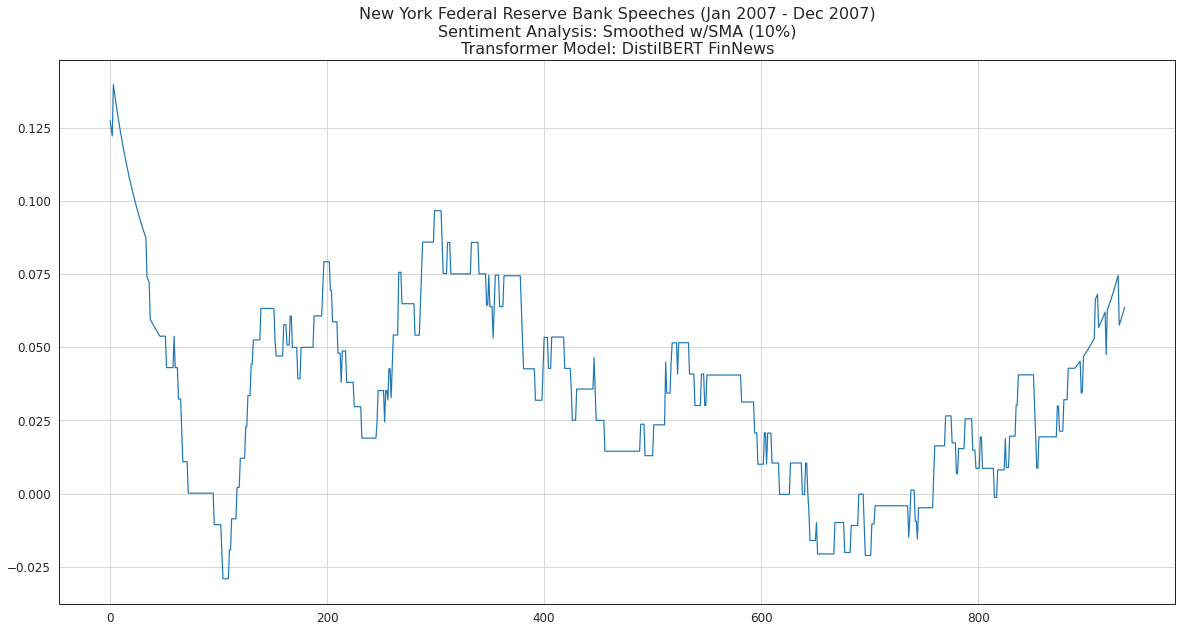

In [339]:
# Verify Plausiblity of new Sentiment Values by Plotting

novel_indx = 0
corpus_text_str = corpus_texts_ls[novel_indx]
# amodel_str = 'huggingface' 
win_aper = 10

win_per = int((win_aper/100.)*global_vars.corpus_texts_dt[corpus_text_str][model_name].shape[0])
text_title_str = f"{global_vars.corpus_titles_dt[corpus_text_str][0]}\nSentiment Analysis: Smoothed w/SMA ({win_aper}%)\n{model_type} Model: {model_title}"
global_vars.corpus_texts_dt[corpus_text_str][model_name].rolling(win_per, center=True, min_periods=0).mean().plot(title=text_title_str)
plt.grid(True)
plt.show();

In [340]:
global_vars.corpus_texts_dt[corpus_text_str].head()

,text_raw,text_clean,roberta15lg,huggingface,nlptown,yelp,hinglish,imdb2way,t5imdb50k,robertaxml8lang,finberttone,distilbertfinnews
0,Timothy F Geithner: Developments in the global economy and implications for the United States Re...,timothy f geithner development in the global economy and implication for the unite state remark ...,0.993093,0.848771,3.286715,0,0,1,1,0.000000,0.000000,0.0
1,"It is a pleasure to be here at the Council on Foreign Relations, and to be here with Jerry Corri...",it be a pleasure to be here at the council on foreign relation and to be here with jerry corrigan,0.998892,0.999224,4.483013,4,0,1,1,0.858362,0.000000,0.0
2,"A few brief remarks about the global economy, both the real and financial dimensions, to provide...",a few brief remark about the global economy both the real and financial dimension to provide a b...,0.998106,0.994493,3.481419,2,0,1,1,0.000000,0.000000,0.0
3,2006 marked the fourth successive year of a global expansion that has been remarkable for its st...,mark the 4 successive year of a global expansion that have be remarkable for its strength for it...,0.998879,0.999847,4.495041,4,2,1,1,0.599996,1.000000,0.0
4,This period of broad-based growth in income has been supported by a number of important fundamen...,this period of broad base growth in income have be support by a numb of important fundamental force,0.998546,0.972342,1.259609,4,2,1,1,0.000000,0.999972,0.0


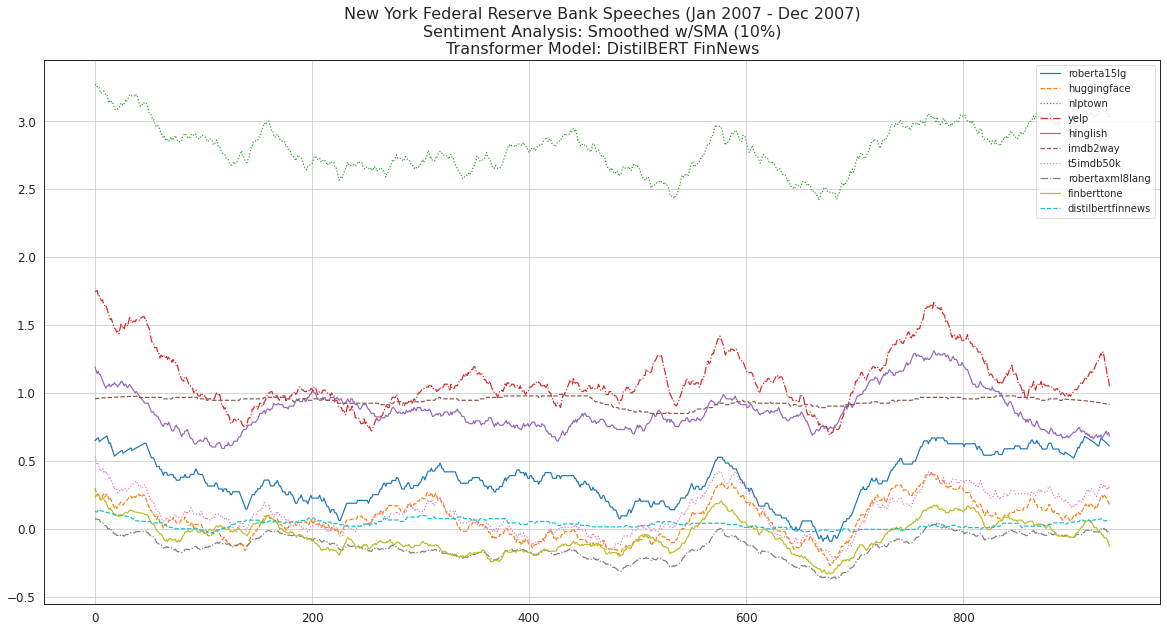

In [341]:
# Plot all models

novel_indx = 0
corpus_text_str = corpus_texts_ls[novel_indx]
win_aper = 10

models_all_ls = list(global_vars.corpus_texts_dt[corpus_text_str].select_dtypes(include=[np.float,np.int]).columns)

win_per = int((win_aper/100.)*global_vars.corpus_texts_dt[corpus_text_str][model_name].shape[0])
text_title_str = f"{global_vars.corpus_titles_dt[corpus_text_str][0]}\nSentiment Analysis: Smoothed w/SMA ({win_aper}%)\n{model_type} Model: {model_title}"
global_vars.corpus_texts_dt[corpus_text_str][models_all_ls].rolling(win_per, center=True, min_periods=0).mean().plot(title=text_title_str)
plt.grid(True)
plt.show();

### **Save Checkpoint**

In [342]:
# Verify in SentimentArcs Root Directory

model_current = 'distilbertfinnews'

os.chdir(Path_to_SentimentArcs)

print('Currently in SentimentArcs root directory:')
!pwd

print(f'Saving Text_Type: {Corpus_Genre}')
print(f'     Corpus_Type: {Corpus_Type}')

# Verify Subdir to save Cleaned Texts and Texts into..

print(f'\nThese Text Titles:\n')
global_vars.corpus_texts_dt.keys()

print(f'\nTo This Subdirectory:\n')
PATH_SENTIMENT_RAW


# Save sentiment values to subdir_sentiments

# os.chdir(Path_to_SentimentArcs)

if Corpus_Type == 'new':
  save_filename = f'sentiment_raw_{Corpus_Genre}_{Corpus_Type}_corpus{Corpus_Number}_transformer_{model_current}.json'
else:
  save_filename = f'sentiment_raw_{Corpus_Genre}_{Corpus_Type}_transformer_{model_current}.json'

# Filter out all models but Current One 
current_model_dt = {}
cols_current_model_ls = []

for i, atext in enumerate(corpus_texts_ls):
  print(f'Saving {model_current} Model for all Texts')
  current_model_dt[atext] = pd.DataFrame(global_vars.corpus_texts_dt[atext][model_current])

write_dict_dfs(current_model_dt, out_file=save_filename, out_dir=f'{PATH_SENTIMENT_RAW}/')



Currently in SentimentArcs root directory:
/gdrive/MyDrive/sentimentarcs_notebooks
Saving Text_Type: finance
     Corpus_Type: new

These Text Titles:



dict_keys(['nyfederalreserve_speeches_2007'])


To This Subdirectory:



'./sentiment_raw/sentiment_raw_finance_new_corpus9/'

Saving distilbertfinnews Model for all Texts
Saving file to: ./sentiment_raw/sentiment_raw_finance_new_corpus9//sentiment_raw_finance_new_corpus9_transformer_distilbertfinnews.json


In [343]:
# Verify json file created

!ls -altr $PATH_SENTIMENT_RAW

total 2030
-rw------- 1 root root 472859 Apr 18 18:54 sentiment_raw_finance_new_corpus9_all_4syuzhetr.json
-rw------- 1 root root 747037 Apr 18 18:56 sentiment_raw_finance_new_corpus9_all_8sentimentr.json
-rw------- 1 root root 386964 Apr 18 19:06 sentiment_raw_finance_new_corpus9_transformer_roberta15lg.json
-rw------- 1 root root  63091 Apr 18 19:09 sentiment_raw_finance_new_corpus9_transformer_huggingface.json
-rw------- 1 root root  58514 Apr 18 19:30 sentiment_raw_finance_new_corpus9_transformer_nlptown.json
-rw------- 1 root root  40296 Apr 18 19:35 sentiment_raw_finance_new_corpus9_transformer_yelp.json
-rw------- 1 root root  44040 Apr 18 19:49 sentiment_raw_finance_new_corpus9_transformer_imdb2way.json
-rw------- 1 root root  44040 Apr 18 19:54 sentiment_raw_finance_new_corpus9_transformer_hinglish.json
-rw------- 1 root root  45381 Apr 18 20:02 sentiment_raw_finance_new_corpus9_transformer_t5imdb50k.json
-rw------- 1 root root  60855 Apr 18 20:08 sentiment_raw_finance_new_cor

## **FinBERT (3 cats)**



In [344]:
# ProsusAI FinBERT

finbert = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")

sa_model = None
del sa_model
sa_model = pipeline("sentiment-analysis", model=finbert, tokenizer=tokenizer)

Downloading:   0%|          | 0.00/758 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/418M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/252 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [345]:
# Test

fin_sentences_ls = ["there is a shortage of capital, and we need extra financing",  
             "growth is strong and we have plenty of liquidity", 
             "there are doubts about our finances", 
             "profits are flat"]
results_ls = sa_model(fin_sentences_ls)
print(results_ls)

[{'label': 'negative', 'score': 0.865357518196106}, {'label': 'positive', 'score': 0.9025791883468628}, {'label': 'neutral', 'score': 0.4569738507270813}, {'label': 'neutral', 'score': 0.7185567021369934}]


In [346]:
# Test

fin_sentences_ls = ["I love sunny days and happy puppy dogs.",
                    "The market crashed and all indicators were down",
                    "Strong institutional buying resulted in rising share prices and a bull market"]
                  
results_ls = sa_model(fin_sentences_ls)

def dtlabelscore2fl(adict):
  """
  Given a dictionary of 2 keys ['label']=[positive|negative|neutral] and ['score']=[0.0 to +1.0]
  Return an adjusted sentiment score [-1.0 to +1.0]
  """
  adj_sentiment = 0.
  apolarity = adict['label']
  asentiment = adict['score']
  if apolarity == 'negative':
    adj_sentiment = -1. * float(asentiment)
  elif apolarity == 'positive':
    adj_sentiment = float(asentiment)
  else:
    adj_sentiment = 0.

  return adj_sentiment

for i, asent_dt in enumerate(results_ls):
  asentence = fin_sentences_ls[i]
  raw_results = results_ls[i]
  adj_senti = dtlabelscore2fl(asent_dt)
  # print(f'SENTENCE:\n    {asentence}\n    apolarity: {apolarity}\n    asentiment: {asentiment}\n    adj_sentiment: {adj_sentiment}') 
  print(f'SENTENCE:\n    {asentence}\n    raw_results: {raw_results}\n    adj_sentiment: {adj_senti}')


SENTENCE:
    I love sunny days and happy puppy dogs.
    raw_results: {'label': 'neutral', 'score': 0.9019231796264648}
    adj_sentiment: 0.0
SENTENCE:
    The market crashed and all indicators were down
    raw_results: {'label': 'negative', 'score': 0.8712065815925598}
    adj_sentiment: -0.8712065815925598
SENTENCE:
    Strong institutional buying resulted in rising share prices and a bull market
    raw_results: {'label': 'negative', 'score': 0.7816882133483887}
    adj_sentiment: -0.7816882133483887


In [347]:
# Define Model and Test

model_title = 'FinBERT'
model_name = 'finbert'
model_type = 'Transformer'

# Test Emoji
emoji_str = "We are very happy to show you the 🤗 Transformers library."
raw_sentiment = sa_model(emoji_str)[0]
adj_sentiment = dtlabelscore2fl(raw_sentiment)
print(f'Emoji String: {emoji_str}\n    Raw Sentiment: {raw_sentiment}\n    Adj Sentiment: {adj_sentiment}\n')
print('\n\n')

# Test Words
print(f'Testing WORD Sentiment')
print('--------------------------------------------------')
for i, aword_str in enumerate(global_vars.TEST_WORDS_LS):

  raw_sentiment = sa_model(aword_str)[0]
  adj_sentiment = dtlabelscore2fl(raw_sentiment)
  print(f'Word String: {aword_str}\n    Raw Sentiment: {raw_sentiment}\n    Adj Sentiment: {adj_sentiment}\n')
  # print('\n\n')
  # print(f'Word: {aword_str}\n    Raw Sentiment: {adj_sentiment} out of {sentiment_scale} (prob={sentiment_prob:.3f})\n')

# Test Sentences
print(f'\nTesting SENTENCE Sentiment')
print('--------------------------------------------------')
for i, asent_str in enumerate(global_vars.TEST_SENTENCES_LS):

  raw_sentiment = sa_model(asent_str)[0]
  adj_sentiment = dtlabelscore2fl(raw_sentiment)
  print(f'Sentence String: {asent_str}\n    Raw Sentiment: {raw_sentiment}\n    Adj Sentiment: {adj_sentiment}\n')
  # print(f'Sentence: {asent_str}\n    Sentiment: {sentiment_val} out of {sentiment_scale} (prob={sentiment_prob:.3f})\n')


Emoji String: We are very happy to show you the 🤗 Transformers library.
    Raw Sentiment: {'label': 'neutral', 'score': 0.8050117492675781}
    Adj Sentiment: 0.0




Testing WORD Sentiment
--------------------------------------------------
Word String: Love
    Raw Sentiment: {'label': 'neutral', 'score': 0.9022915363311768}
    Adj Sentiment: 0.0

Word String: Hate
    Raw Sentiment: {'label': 'neutral', 'score': 0.8657577037811279}
    Adj Sentiment: 0.0

Word String: bizarre
    Raw Sentiment: {'label': 'neutral', 'score': 0.8556274771690369}
    Adj Sentiment: 0.0

Word String: strange
    Raw Sentiment: {'label': 'neutral', 'score': 0.8701233863830566}
    Adj Sentiment: 0.0

Word String: furious
    Raw Sentiment: {'label': 'neutral', 'score': 0.8748984932899475}
    Adj Sentiment: 0.0

Word String: elated
    Raw Sentiment: {'label': 'neutral', 'score': 0.6881272196769714}
    Adj Sentiment: 0.0

Word String: curious
    Raw Sentiment: {'label': 'neutral', 'score': 0.848300576

In [348]:
%%time

# NOTE:    16m13s @22:39 on 20220301 Colab Pro T4 (2 Novels: 1M, 1.1M)

for i, atext in enumerate(global_vars.corpus_texts_dt.keys()):
  models_ls = global_vars.corpus_texts_dt[atext].columns
  print(f"Processing #{i}: {atext}")
  if (Force_Recompute == True) or (model_name not in models_ls):
    # corpus_texts_dt[atext][model_name] = corpus_texts_dt[atext]['text_clean'].apply(lambda x: logitstensor2sentiment(sa_yelp(**tokenizer(x, return_tensors='pt')))[0])
    global_vars.corpus_texts_dt[atext][model_name] = global_vars.corpus_texts_dt[atext]['text_clean'].apply(lambda x: dtlabelscore2fl(sa_model(x)[0]))
    print(f'  [{model_name}] Sentiment Recomputed and Value Updated')
  else:
    print(f'  [{model_name}] Already in DataFrame and no Forced Recompute, so no update made')


Processing #0: nyfederalreserve_speeches_2007
  [finbert] Sentiment Recomputed and Value Updated
CPU times: user 2min 18s, sys: 440 ms, total: 2min 19s
Wall time: 2min 22s


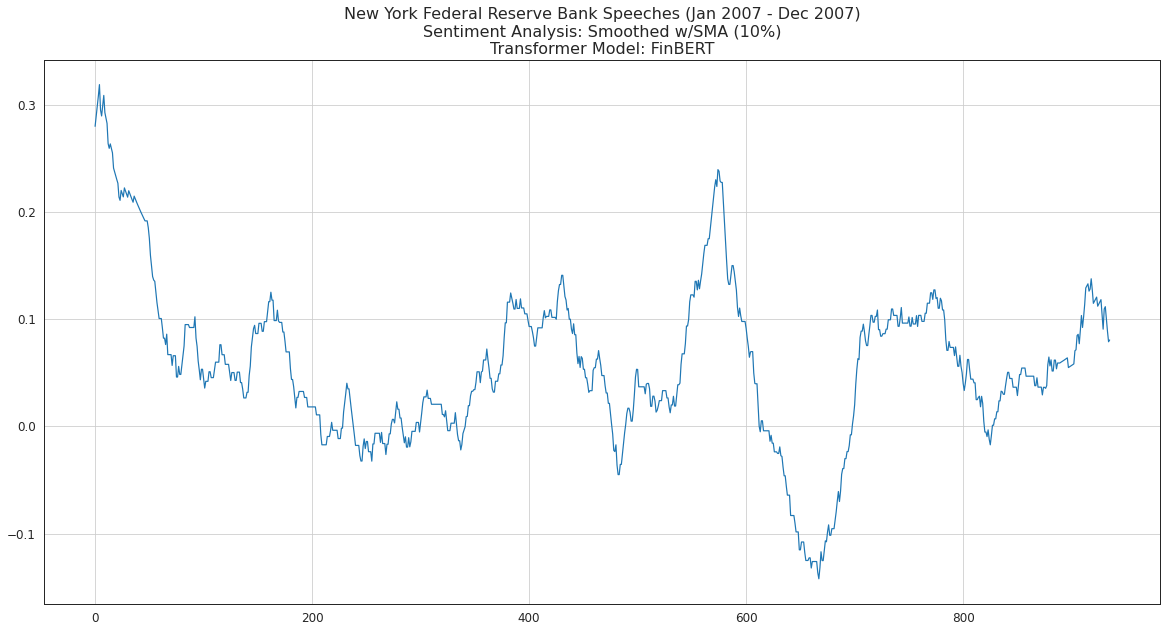

In [349]:
# Verify Plausiblity of new Sentiment Values by Plotting

novel_indx = 0
corpus_text_str = corpus_texts_ls[novel_indx]
# amodel_str = 'huggingface' 
win_aper = 10

win_per = int((win_aper/100.)*global_vars.corpus_texts_dt[corpus_text_str][model_name].shape[0])
text_title_str = f"{global_vars.corpus_titles_dt[corpus_text_str][0]}\nSentiment Analysis: Smoothed w/SMA ({win_aper}%)\n{model_type} Model: {model_title}"
global_vars.corpus_texts_dt[corpus_text_str][model_name].rolling(win_per, center=True, min_periods=0).mean().plot(title=text_title_str)
plt.grid(True)
plt.show();

In [350]:
global_vars.corpus_texts_dt[corpus_text_str].head()

,text_raw,text_clean,roberta15lg,huggingface,nlptown,yelp,hinglish,imdb2way,t5imdb50k,robertaxml8lang,finberttone,distilbertfinnews,finbert
0,Timothy F Geithner: Developments in the global economy and implications for the United States Re...,timothy f geithner development in the global economy and implication for the unite state remark ...,0.993093,0.848771,3.286715,0,0,1,1,0.000000,0.000000,0.0,0.000000
1,"It is a pleasure to be here at the Council on Foreign Relations, and to be here with Jerry Corri...",it be a pleasure to be here at the council on foreign relation and to be here with jerry corrigan,0.998892,0.999224,4.483013,4,0,1,1,0.858362,0.000000,0.0,0.000000
2,"A few brief remarks about the global economy, both the real and financial dimensions, to provide...",a few brief remark about the global economy both the real and financial dimension to provide a b...,0.998106,0.994493,3.481419,2,0,1,1,0.000000,0.000000,0.0,0.000000
3,2006 marked the fourth successive year of a global expansion that has been remarkable for its st...,mark the 4 successive year of a global expansion that have be remarkable for its strength for it...,0.998879,0.999847,4.495041,4,2,1,1,0.599996,1.000000,0.0,0.935559
4,This period of broad-based growth in income has been supported by a number of important fundamen...,this period of broad base growth in income have be support by a numb of important fundamental force,0.998546,0.972342,1.259609,4,2,1,1,0.000000,0.999972,0.0,0.586129


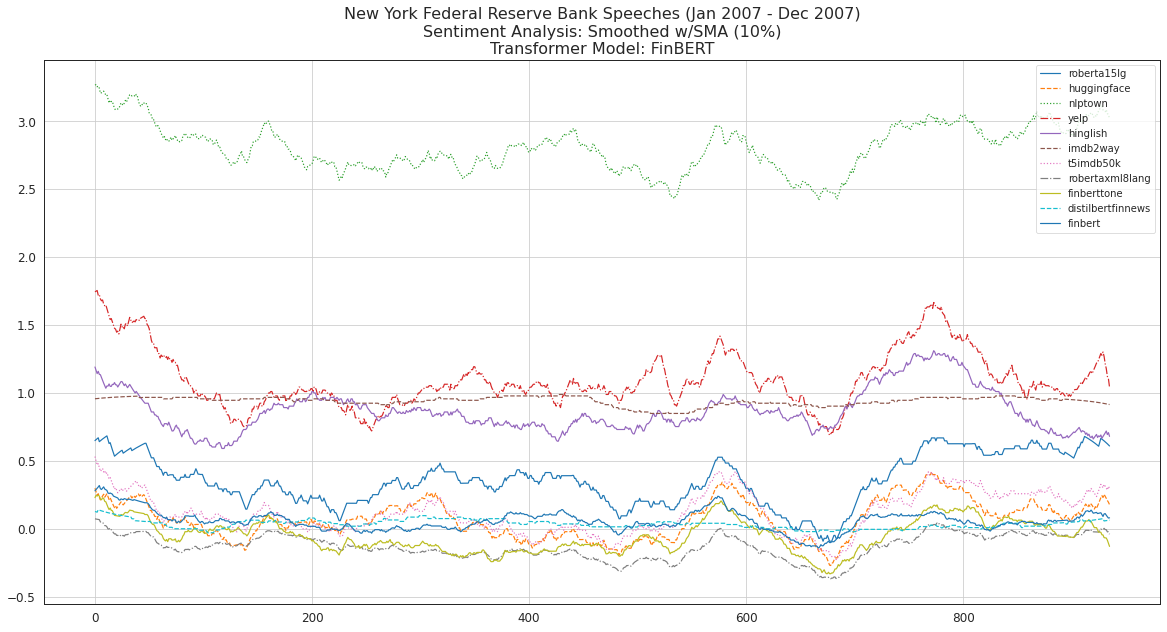

In [351]:
# Plot all models

novel_indx = 0
corpus_text_str = corpus_texts_ls[novel_indx]
win_aper = 10

models_all_ls = list(global_vars.corpus_texts_dt[corpus_text_str].select_dtypes(include=[np.float,np.int]).columns)

win_per = int((win_aper/100.)*global_vars.corpus_texts_dt[corpus_text_str][model_name].shape[0])
text_title_str = f"{global_vars.corpus_titles_dt[corpus_text_str][0]}\nSentiment Analysis: Smoothed w/SMA ({win_aper}%)\n{model_type} Model: {model_title}"
global_vars.corpus_texts_dt[corpus_text_str][models_all_ls].rolling(win_per, center=True, min_periods=0).mean().plot(title=text_title_str)
plt.grid(True)
plt.show();

### **Save Checkpoint**

In [352]:
# Verify in SentimentArcs Root Directory

model_current = 'finbert'

os.chdir(Path_to_SentimentArcs)

print('Currently in SentimentArcs root directory:')
!pwd

print(f'Saving Text_Type: {Corpus_Genre}')
print(f'     Corpus_Type: {Corpus_Type}')

# Verify Subdir to save Cleaned Texts and Texts into..

print(f'\nThese Text Titles:\n')
global_vars.corpus_texts_dt.keys()

print(f'\nTo This Subdirectory:\n')
PATH_SENTIMENT_RAW


# Save sentiment values to subdir_sentiments

# os.chdir(Path_to_SentimentArcs)

if Corpus_Type == 'new':
  save_filename = f'sentiment_raw_{Corpus_Genre}_{Corpus_Type}_corpus{Corpus_Number}_transformer_{model_current}.json'
else:
  save_filename = f'sentiment_raw_{Corpus_Genre}_{Corpus_Type}_transformer_{model_current}.json'

# Filter out all models but Current One 
current_model_dt = {}
cols_current_model_ls = []

for i, atext in enumerate(corpus_texts_ls):
  print(f'Saving {model_current} Model for all Texts')
  current_model_dt[atext] = pd.DataFrame(global_vars.corpus_texts_dt[atext][model_current])

write_dict_dfs(current_model_dt, out_file=save_filename, out_dir=f'{PATH_SENTIMENT_RAW}/')



Currently in SentimentArcs root directory:
/gdrive/MyDrive/sentimentarcs_notebooks
Saving Text_Type: finance
     Corpus_Type: new

These Text Titles:



dict_keys(['nyfederalreserve_speeches_2007'])


To This Subdirectory:



'./sentiment_raw/sentiment_raw_finance_new_corpus9/'

Saving finbert Model for all Texts
Saving file to: ./sentiment_raw/sentiment_raw_finance_new_corpus9//sentiment_raw_finance_new_corpus9_transformer_finbert.json


In [353]:
# Verify json file created

!ls -altr $PATH_SENTIMENT_RAW

total 2079
-rw------- 1 root root 472859 Apr 18 18:54 sentiment_raw_finance_new_corpus9_all_4syuzhetr.json
-rw------- 1 root root 747037 Apr 18 18:56 sentiment_raw_finance_new_corpus9_all_8sentimentr.json
-rw------- 1 root root 386964 Apr 18 19:06 sentiment_raw_finance_new_corpus9_transformer_roberta15lg.json
-rw------- 1 root root  63091 Apr 18 19:09 sentiment_raw_finance_new_corpus9_transformer_huggingface.json
-rw------- 1 root root  58514 Apr 18 19:30 sentiment_raw_finance_new_corpus9_transformer_nlptown.json
-rw------- 1 root root  40296 Apr 18 19:35 sentiment_raw_finance_new_corpus9_transformer_yelp.json
-rw------- 1 root root  44040 Apr 18 19:49 sentiment_raw_finance_new_corpus9_transformer_imdb2way.json
-rw------- 1 root root  44040 Apr 18 19:54 sentiment_raw_finance_new_corpus9_transformer_hinglish.json
-rw------- 1 root root  45381 Apr 18 20:02 sentiment_raw_finance_new_corpus9_transformer_t5imdb50k.json
-rw------- 1 root root  60855 Apr 18 20:08 sentiment_raw_finance_new_cor

# **END OF NOTEBOOK**